<a href="https://colab.research.google.com/github/HemantharajM/AI-Material/blob/master/1.Multi_agent_planning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import autograd
from torch.utils.data import DataLoader
from torch.nn.parameter import Parameter

import torch.nn.functional as F

In [0]:
import queue
import random

In [6]:
from google.colab import files
uploaded = files.upload()

Saving train_4_0.npz to train_4_0.npz
Saving train_4_data.npz to train_4_data.npz


In [0]:
def action(S,val,env,imsize):
    if val == 0 and S[1].item() > 0:
        if env[S[0].item()][S[1].item()-1] == 1.0 :
            return torch.tensor([S[0].item(),S[1].item()-1]), False
        else :
            return torch.tensor([S[0].item(),S[1].item()]), True
    elif val == 1 and S[0].item() > 0:
        if env[S[0].item()-1][S[1].item()] == 1.0 :
            return torch.tensor([S[0].item()-1,S[1].item()]), False
        else :
            return torch.tensor([S[0].item(),S[1].item()]), True
    elif val == 2 and S[1].item() < (imsize -1):
        if env[S[0].item()][S[1].item()+1] == 1.0 :
            return torch.tensor([S[0].item(),S[1].item()+1]), False
        else:
            return torch.tensor([S[0].item(),S[1].item()]), True
    elif val == 3 and S[0].item() < (imsize -1):
        if env[S[0].item()+1][S[1].item()] == 1.0 :
            return torch.tensor([S[0].item()+1,S[1].item()]), False
        else:
            return torch.tensor([S[0].item(),S[1].item()]), True
    else :
        return S, True

In [0]:
def rand_play(X,a_s,imsize,obst):
    #find possible action
    Action = []
    
    if (a_s[1] -1) >= 0:
        if X[0][a_s[0]][a_s[1]-1] and (not X[2][a_s[0]][a_s[1]-1]):
            Action.append(0)
    if (a_s[0] -1 ) >= 0:
        if X[0][a_s[0]-1][a_s[1]] and (not X[2][a_s[0]-1][a_s[1]]):
            Action.append(1)
    if (a_s[1] +1 ) < imsize:
        if X[0][a_s[0]][a_s[1]+1] and (not X[2][a_s[0]][a_s[1]+1]):
            Action.append(2)
    if (a_s[0] + 1) < imsize:    
        if X[0][a_s[0]+1][a_s[1]] and (not X[2][a_s[0]+1][a_s[1]]):
            Action.append(3)
    
    if len(Action) != 0:
        act = np.random.choice(Action)
        new_state,_ = action(a_s,act,obst,imsize)
    else:
        new_state = a_s
    
    return new_state

In [0]:
def goal_reach_check(agent_state,goal,goal_count,goal_reached):
    token = 0
    v = 0
    goal_position = -1
    for z in goal:
        #check goal is already reached
        if goal_reached[v] == 0:
            #if goal is not reached and compare with agent state
            if agent_state[0].item() == z[0] and agent_state[1].item() == z[1]:
                goal_reached[v] = 1
                goal_count += 1
                token = 1
                goal_position = v
        v = v+1    
    return token,goal_count,goal_reached,goal_position

In [0]:
def agent_env_H(X,agent_state,imsize,avoid_goal,token):
    
    Y = torch.zeros([1,3,imsize,imsize])
    Y[0,0,:,:] = X[0].clone()
    Y[0,1,:,:] = X[1].clone()
    
    if token :
        Y[0,2,:,:] = -1 * X[2].clone()
        Y[0,2,agent_state[0],agent_state[1]] = 0.0
        Y[0,0,:,:] = Y[0,0,:,:] + Y[0,2,:,:]
        Y[0,2,agent_state[0],agent_state[1]] = 1.0
    else :
        Y[0,2,:,:] = torch.zeros_like(X[2])
        Y[0,2,agent_state[0],agent_state[1]] = 1.0

        
    #avoid goal 
    for i in avoid_goal:
        Y[0,1,i[0],i[1]] = 0.0
    
    Y = Y.float()
   
    return Y

In [0]:
def agent_prediction(model,X,whole_traj_act,goal,imsize,max_random_play):
    #convert specific domain to generic domains
    X = abs(X)
    
    model.eval() 
    correct_goal,total_goal,traj_step_error,goal_count = 0.0,0.0,0.0,0.0
    
    #store agent initial state
    inter = np.where(X[2] == 1.0)
    agent_state = np.column_stack([inter[0],inter[1]])
    n_agent = agent_state.shape[0]
    
    agent_traj = [[agent_state[i].copy()] for i in range(n_agent)]
    
    #store number agent still playing
    current_play_agent = [1.0 for i in range(n_agent)]
    
    current_play_agent = np.array(current_play_agent)
    
    #keep which is reached
    goal_reached = np.zeros([goal.size])
    
    #store each agent random play chances
    random_play = np.zeros(n_agent)
    max_random_play = max_random_play
    
    avoid_goal= []
    play = 0
    while current_play_agent.sum() != 0.0 and play < 20:
        play += 1
        for i in range(n_agent):
            
            if current_play_agent[i] == 1.0:  
                Input = agent_env_H(X.clone(),agent_state[i],imsize,avoid_goal,1)
                Input = Input.to(device)
                S1 = torch.tensor(agent_state[i][0])
                S2 = torch.tensor(agent_state[i][1])
                S1 = S1.to(device)
                S2 = S2.to(device)
                output,prediction,_,_ = model(Input,S1,S2)
                _,index = torch.max(output,dim=1)
              
                #check agent (index = 4) means stop planning
                if index == 4:
                    #token whether agent reach goal or not
                    token,goal_count,goal_reached,goal_position = goal_reach_check(agent_state[i],goal,goal_count,goal_reached)
                    if token:
                        avoid_goal.append(goal[goal_position])
                        current_play_agent[i] = 0.0
                    else:
                        if random_play[i] >= max_random_play:
                            current_play_agent[i] = 0.0
                        else:
                            X[2][agent_state[i][0]][agent_state[i][1]] = 0.0
                            agent_state[i] =rand_play(X,agent_state[i].copy(),imsize)
                            random_play[i] += 1
                            X[2][agent_state[i][0]][agent_state[i][1]] = 1.0
                            agent_traj[i].append(agent_state[i].copy())
    
                else:
                    
                    agent_new_state,obst = action(S=agent_state[i],val=index,imsize=imsize,env=Input[0,0,:,:])
                    
                    if obst:
                      #  print('s')
                        current_play_agent[i] = 0.0
                        continue
                    X[2][agent_state[i][0]][agent_state[i][1]] = 0.0
                    agent_state[i] = agent_new_state
                    X[2][agent_state[i][0]][agent_state[i][1]] = 1.0
                    agent_traj[i].append(agent_state[i].copy())
                    
                    #stop agent which moves back and forward two on the goal
                    if len(agent_traj[i]) > 3 and (agent_traj[i][-1] == agent_traj[i][-3]).sum() == 2 and (agent_traj[i][-2] == agent_traj[i][-4]).sum() == 2:
                        
                        inter = agent_traj[i][-1]
                        token,goal_count,goal_reached,_ = goal_reach_check(inter,goal,goal_count,goal_reached)
                        if token:
                       #     print('d')
                            current_play_agent[i] = 0.0
                        else:     
                            inter = agent_traj[i][-2]
                            token,goal_count,goal_reached,_ = goal_reach_check(inter,goal,goal_count,goal_reached)
                            if token:
                        #        print('e')
                                current_play_agent[i] = 0.0
                                agent_traj[i].pop(-1)
                            else:
                                if random_play[i] < max_random_play:
                                    X[2][agent_state[i][0]][agent_state[i][1]] = 0.0
                                    
                                    agent_state[i] =rand_play(X,agent_state[i].copy(),imsize)
                                    random_play[i] += 1
                                    X[2][agent_state[i][0]][agent_state[i][1]] = 1.0
                                    agent_traj[i].append(agent_state[i].copy())
                                else:
                         #           print('e')
                                    current_play_agent[i] = 0.0
                    
    for j in range(len(whole_traj_act)):
        inter =  whole_traj_act[j][0][0].numpy() 
        for i in range(len(agent_traj)):
            if inter[0] == agent_traj[i][0][0] and inter[1] == agent_traj[i][0][1]:
                actual_len = len(agent_traj[i])
                pred_len = len(whole_traj_act[j][0])
                traj_step_error += (abs(pred_len - actual_len))
    
    
    correct_goal = goal_count
    
    if n_agent > len(goal):
        total_goal = len(goal)
    else:
        total_goal =  n_agent
        
    traj_step = -1000
    for i in agent_traj:
        if len(i) > traj_step:
            traj_step = len(i)
    
    return correct_goal,total_goal,(traj_step),agent_traj

In [0]:
def visualization(dom,traj):
    fig, ax = plt.subplots()
    implot = plt.imshow(dom, cmap="Greys_r")


    start = []
    for i in traj:
        start.append([i[0][0][0].item(),i[0][0][1].item()])

   
    for i in start:
        ax.plot(i[1], i[0], '-s')

    start = []
    for i in traj:
        path = []
        for j in i[0]:
            path.append([j[0].item(),j[1].item()])

        path = np.array(path)
        ax.plot(path[:, 1], path[:, 0], '-X', c='r')

 #   for i in goal:
 #       ax.plot(i[1], i[0], '-s')
   # legend = ax.legend(loc='upper right', shadow=False)
#    for label in legend.get_texts():
#        label.set_fontsize('x-small')  # the legend text size
#    for label in legend.get_lines():
#        label.set_linewidth(0.5)  # the legend line width
    plt.draw()
    plt.show()

In [0]:
def next_goal(Input,v_in,agent_pose,imsize,n_goal,goal_pose,avoid_goal) :
    visited = (Input[0,0,:,:].clone() == 0.0) + 0.0
    distance = torch.zeros_like(visited)
    parent = torch.ones_like(visited) * -1

    v_in = v_in.squeeze()
  
    pose = agent_pose

    visited[pose[0]][pose[1]] = 1.0
    distance[pose[0]][pose[1]] = 0.0
    parent[pose[0]][pose[1]] = 4

    av = len(avoid_goal)
    #valid goal location
    valid = [1.0 for i in range(n_goal)]
    for i in range(n_goal):
        for j in range(av):
            if avoid_goal[j][0] == goal_pose[i][0] and avoid_goal[j][1] == goal_pose[i][1]:
                valid[i] = 0.0
                
    S = queue.Queue()
    S.put(pose)

    dist = 0.0
    
    while not S.empty():
     
        node = S.get()

        node = torch.tensor(node)
        pose = node.clone()

        token = 1
        act_store = [-1,-1]
        dist += 1
        traj = [pose]

        loc = 0
        path_distance = 0
        #check for where this node
        while True:
   
            loc = loc + 1
            path_distance += 1
            pre_pose = pose
            act = v_in[pose[0]][pose[1]]

            act_store[loc % 2] = act

            #check for goal 
            goal_position = -1
            for j in range(n_goal):
                if valid[j] == 1.0:
                    if pose[0] == goal_pose[j][0] and pose[1] == goal_pose[j][1]:
                        goal_position = j
            if goal_position != -1:
                break
            #repeat same two action
            if (act_store[0]== 1 and act_store[1] == 3) or (act_store[0] == 3 and act_store[1] == 1):
                token = 0
                break

            if (act_store[0]== 0 and act_store[1] == 2) or (act_store[0] == 2 and act_store[1] == 0):
                token = 0
                break   

            if act.item() == 4:
                goal_position = -1
                for j in range(n_goal):
                    if pose[0] == goal_pose[j][0] and pose[1] == goal_pose[j][1]:
                        goal_position = j
                if goal_position != -1:
                    break
                else :
                    token = 0
                    break

            pose,obst = action(pose,act,Input[0,0,:,:].squeeze(),imsize)   

            traj.append(pose)

            #Hitting obstacle
            if obst:
                token = 0
                break
            #repeat same position    
            if pose[0] == pre_pose[0] and pose[1] == pre_pose[1]:
                token = 0
                break

        if token :
            pose = traj[0]

            traj1 = []
            while True:

                act = parent[pose[0]][pose[1]]
                if act == 4:
                    break
                pose,obst = action(pose,act,Input[0,0,:,:].squeeze(),imsize)  
                traj1.append(pose)
                path_distance += 1
            traj1.reverse()
            traj1.extend(traj)
            
            return goal_position,path_distance,traj1
        else :
            pose = node.clone()
            
            for i in range(4):
                new_pose,obst = action(S=pose,val=i,env=Input[0,0,:,:],imsize=imsize) 
               
                if not obst:
                   
                    if visited[new_pose[0]][new_pose[1]] == 0:
                        S.put(new_pose)
                        
                        visited[new_pose[0]][new_pose[1]] = 1.0
                       # distance[new_pose[0]][new_pose[1]] = dist
                        if i == 3:
                            parent[new_pose[0]][new_pose[1]] = 1
                        if i == 2:
                            parent[new_pose[0]][new_pose[1]] = 0
                        if i == 1:
                            parent[new_pose[0]][new_pose[1]] = 3
                        if i == 0:
                            parent[new_pose[0]][new_pose[1]] = 2
   
    return -1,0,[]

In [0]:
def find_next_goal(X,agent_pose,imsize,avoid_goal,model,agent_no,n_goal,goal_pose):
    
    model.eval()
    token = 0
    
    Input = agent_env_H(X.clone(),agent_pose,imsize,avoid_goal,token)
    Input = Input.to(device)
    S1 = torch.tensor(agent_pose[0])
    S2 = torch.tensor(agent_pose[1])
    S1 = S1.to(device)
    S2 = S2.to(device)
    output,prediction,v_max,v_in = model(Input,S1,S2)
    
    return next_goal(agent_pose=agent_pose,imsize=imsize,Input=Input,v_in=v_in,goal_pose=goal_pose,n_goal=n_goal,avoid_goal=avoid_goal)

In [0]:
def cooperative(X,model,imsize):
    age = np.where(X[2] == 1.0)
    agent_pose = np.column_stack([age[0],age[1]])
    n_agent = agent_pose.shape[0]

    go = np.where(X[1] == 1.0)
    goal_pose = np.column_stack([go[0],go[1]])
    n_goal = goal_pose.shape[0]

    change = 0
    if n_agent >= n_goal:
        temp = n_goal
        n_goal= n_agent
        n_agent = temp

        temp = agent_pose.copy()
        agent_pose = goal_pose.copy()
        goal_pose = temp.copy()

        temp = X[2].clone()
        X[2] = X[1].clone()
        X[1] = temp.clone()

        change = 1

    goal_agent = [[] for i in range(n_goal)]

    avoid_goal = [[] for i in range(n_agent)]

    trajectory = [[] for i in range(n_agent)]

    #find next goal for all agent
    for i in range(n_agent):
       # print(agent_pose,avoid_goal,goal_pose)
        g_pos,dist,traj = find_next_goal(X.clone(),agent_pose[i],imsize,avoid_goal[i],model,i,n_goal,goal_pose)
        goal_agent[g_pos].append([i,dist])
        #print(g_pos,dist,traj)
        trajectory[i].append(traj)
    
    count = 0
    while count < (n_agent * 10):
        count = count + 1
        token = 1
       # print(goal_agent,avoid_goal)
        for key1 in range(n_goal):
            if len(goal_agent[key1]) > 1:
                token = 0
        if token:
            count = 0
            for i in range(n_goal):
                if len(goal_agent[i]) == 1:
                    count += 1
            agent_traj = [[] for v in range(n_agent)]
            traj_length = -1000
            for v in range(n_agent):
                agent_traj[v].append(trajectory[v][-1])
                if len(trajectory[v][-1]) > traj_length:
                    traj_length = len(trajectory[v][-1])
                    
            return count,n_agent,traj_length,agent_traj,change
        #find the conflict
        for key1 in range(n_goal):
            #check for conflict
            if len(goal_agent[key1]) > 1:
                same_agent = []
                min_dist = 0
                min_index = -1
                for j in goal_agent[key1]:
                    same_agent.append(j[0])
                    if min_dist > j[1]:
                        min_dist = j[1]
                        min_index = j[0]

                next_goal_agent = [[] for i in range(n_goal)]

                #find goal next goal for conflicted agent
                L = len(same_agent)
                problem = 0
                for age in same_agent:
                    avoid_goal[age].append(goal_pose[key1])
                    g_pos,dist,traj = find_next_goal(X.clone(),agent_pose[age],imsize,avoid_goal[age],model,age,n_goal,goal_pose)
                    if g_pos != -1:
                        trajectory[age].append(traj)
                        next_goal_agent[g_pos].append([age,dist])
                    else :
                        problem = 1
                        avoid_goal[age].pop(-1)
                        for j in goal_agent[key1]:
                            if j[0] == age:
                                next_goal_agent[key1].append([j[0],j[1]])
                
               # print(next_goal_agent)
                #check for newly created conflict
                new_conflict = 0
                new_conflict_index = []
                non_conflict_index = []
                for v in range(n_goal):
                    if len(next_goal_agent[v]) == 1:
                      non_conflict_index.append(v)
                    if len(next_goal_agent[v]) > 1:
                        new_conflict +=1
                        new_conflict_index.append(v)


                next_next_goal_agent = [[] for i in range(n_goal)]
                
                #No new conflict
                if new_conflict == 0 and problem == 0:
                  
                    max_index = -1
                    max_dist = 0
                    
                    for key in non_conflict_index:
                        if next_goal_agent[key][0][1] > max_dist:
                            max_dist =next_goal_agent[key][0][1]
                            max_index = next_goal_agent[key][0][0]
                            
                    avoid_goal[max_index].pop(-1)
                    trajectory[max_index].pop(-1)
                    for key in range(n_goal):
                        if len(next_goal_agent[key]) == 1:
                            #find where this agent made goal and make them null set
                            if next_goal_agent[key][0][0] == max_index:
                                next_goal_agent[key] = []
                    
                    next_goal_agent[key1].append([max_index,max_dist])
                #    print(next_goal_agent)
                    goal_agent[key1] = []
                    for key in range(n_goal):
                        for j in next_goal_agent[key]:
                            goal_agent[key].append(j)
                else :
                    for key2 in new_conflict_index:
                        #code for same agent or partial agent
                        max_dist = 0
                        max_index = -1
                        for j in next_goal_agent[key2]:
                            if max_dist < j[1]:
                                max_dist = j[1]
                                max_index = j[0]

                        for j in next_goal_agent[key2]:
                            #put largest dist to goal
                            if j[0] == max_index:
                                trajectory[max_index].pop(-1)
                                avoid_goal[max_index].pop(-1)
                                for c in range(n_goal):
                                    for d in goal_agent[c]:
                                        if d[0] == max_index:
                                            next_next_goal_agent[key1].append([d[0],d[1]])
                            else :
                                next_next_goal_agent[key2].append([j[0],j[1]])

                        goal_agent[key1] = []
                        for key in range(n_goal):
                            for j in next_next_goal_agent[key]:
                                goal_agent[key].append(j)
                  
                    for key in non_conflict_index:
                        for j in next_goal_agent[key]:
                            goal_agent[key].append(j)



In [0]:
class MA_P(torch.nn.Module):
    def __init__(self, k, imsize):
        super(MA_P, self).__init__()
        self.k = k
        self.imsize = imsize
        self.h = torch.nn.Conv2d(
            in_channels=3,
            out_channels=150,
            kernel_size=(3, 3),
            stride=1,
            padding=1,
            bias=True)
        self.r = torch.nn.Conv2d(
            in_channels=150,
            out_channels=1,
            kernel_size=(1, 1),
            stride=1,
            padding=0,
            bias=False)
        self.q = torch.nn.Conv2d(
            in_channels=1,
            out_channels=5,
            kernel_size=(3, 3),
            stride=1,
            padding=1,
            bias=False)
        
        self.w = Parameter(torch.zeros(5, 1, 3, 3), requires_grad=True)
        self.sm = torch.nn.Softmax(dim=1)

    def forward(self, X, S1, S2):
        h = self.h(X)
        r = self.r(h)
        q = self.q(r)
        v, _ = torch.max(q, dim=1, keepdim=True)
        for i in range(0, self.k - 1):
            q = F.conv2d(
                torch.cat([r, v], 1),
                torch.cat([self.q.weight, self.w], 1),
                stride=1,
                padding=1)
            v, _ = torch.max(q, dim=1, keepdim=True)

        q = F.conv2d(
            torch.cat([r, v], 1),
            torch.cat([self.q.weight, self.w], 1),
            stride=1,
            padding=1)
        
        v_in,v_out = torch.max(q, dim=1, keepdim=True)

        slice_s1 = S1.long().expand(self.imsize, 1, 5, q.size(0))
        slice_s1 = slice_s1.permute(3, 2, 1, 0)
        q_out = q.gather(2, slice_s1).squeeze(2)

        slice_s2 = S2.long().expand(1, 5, q.size(0))
        slice_s2 = slice_s2.permute(2, 1, 0)
        q_out = q_out.gather(2, slice_s2).squeeze(2)

        logits = q_out
        
        return logits, self.sm(logits),v_in,v_out

In [0]:
test = []
with np.load('train_4_0.npz',mmap_mode='r',allow_pickle=True) as f:
    test = f['arr_0']

In [0]:
test_data = []

for i in test:
    env = -1 *(i[0] == 0) + 1.0
    goal = (i[0] == 0.5) + 0.0
    Agent = i[1]
    
    
    p_env = np.zeros([7,7])
    p_env[1:6,1:6] = env
    p_goal = np.zeros([7,7])
    p_goal[1:6,1:6] = goal
    p_agent = np.zeros([7,7])
    p_agent[1:6,1:6] = Agent
    
    domain = np.array([p_env,p_goal,p_agent])
    test_data.append([torch.tensor(domain),torch.tensor([i[2][0]+1,i[2][1]+1]),torch.tensor(i[3])])

In [93]:
model_5x5 = MA_P(8,7)
model_5x5.load_state_dict(torch.load('MA_P_2_9_2.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [94]:
model_5x5.cuda()

MA_P(
  (h): Conv2d(3, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (r): Conv2d(150, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (q): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (sm): Softmax()
)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "CPU")

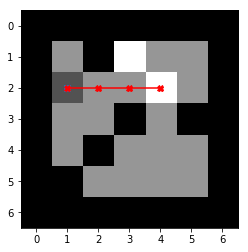

[2, 4]->[2, 3]->[2, 2]->[2, 1]->End


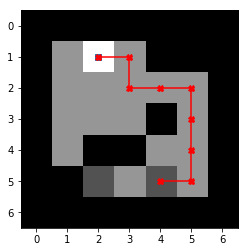

[1, 2]->[1, 3]->[2, 3]->[2, 4]->[2, 5]->[3, 5]->[4, 5]->[5, 5]->[5, 4]->End


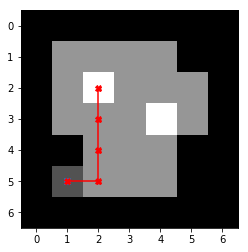

[2, 2]->[3, 2]->[4, 2]->[5, 2]->[5, 1]->End


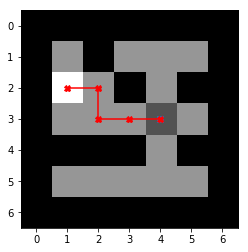

[2, 1]->[2, 2]->[3, 2]->[3, 3]->[3, 4]->End


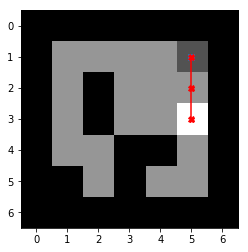

[3, 5]->[2, 5]->[1, 5]->End


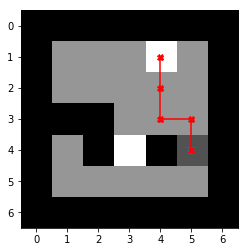

[1, 4]->[2, 4]->[3, 4]->[3, 5]->[4, 5]->End


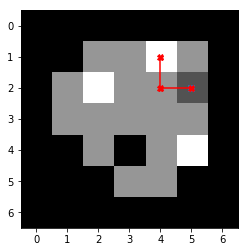

[1, 4]->[2, 4]->[2, 5]->End


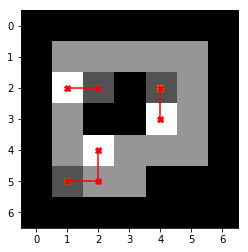

[2, 1]->[2, 2]->End
[3, 4]->[2, 4]->End
[4, 2]->[5, 2]->[5, 1]->End


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


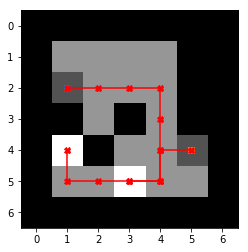

[5, 3]->[5, 4]->[4, 4]->[3, 4]->[2, 4]->[2, 3]->[2, 2]->[2, 1]->End
[4, 1]->[5, 1]->[5, 2]->[5, 3]->[5, 4]->[4, 4]->[4, 5]->End


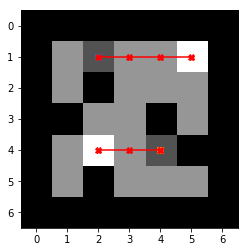

[1, 5]->[1, 4]->[1, 3]->[1, 2]->End
[4, 2]->[4, 3]->[4, 4]->End


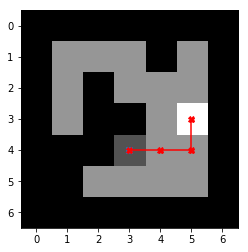

[3, 5]->[4, 5]->[4, 4]->[4, 3]->End


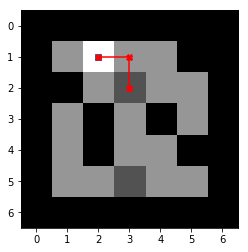

[1, 2]->[1, 3]->[2, 3]->End


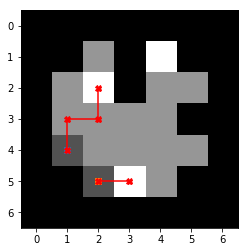

[2, 2]->[3, 2]->[3, 1]->[4, 1]->End
[5, 3]->[5, 2]->End


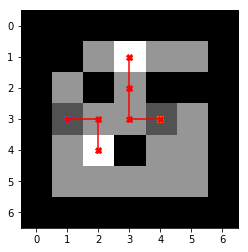

[4, 2]->[3, 2]->[3, 1]->End
[1, 3]->[2, 3]->[3, 3]->[3, 4]->End


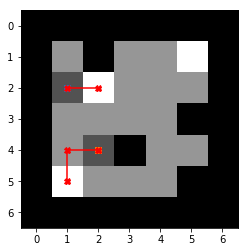

[2, 2]->[2, 1]->End
[5, 1]->[4, 1]->[4, 2]->End


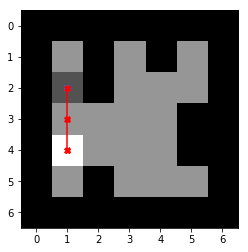

[4, 1]->[3, 1]->[2, 1]->End


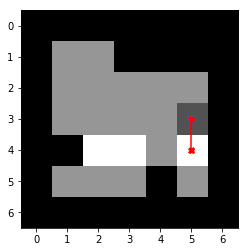

[4, 5]->[3, 5]->End


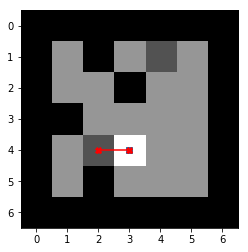

[4, 3]->[4, 2]->End


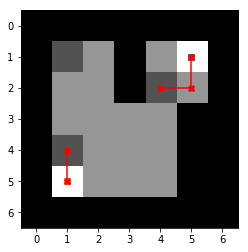

[1, 5]->[2, 5]->[2, 4]->End
[5, 1]->[4, 1]->End


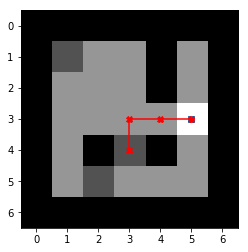

[3, 5]->[3, 4]->[3, 3]->[4, 3]->End


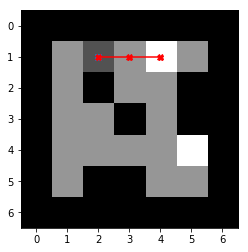

[1, 4]->[1, 3]->[1, 2]->End


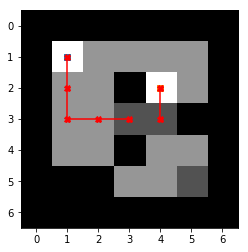

[1, 1]->[2, 1]->[3, 1]->[3, 2]->[3, 3]->End
[2, 4]->[3, 4]->End


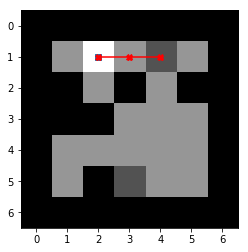

[1, 2]->[1, 3]->[1, 4]->End


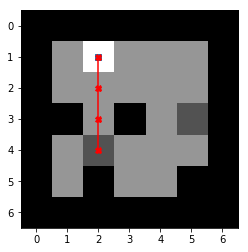

[1, 2]->[2, 2]->[3, 2]->[4, 2]->End


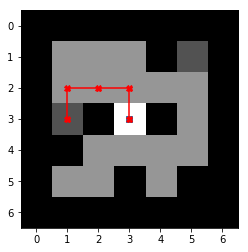

[3, 3]->[2, 3]->[2, 2]->[2, 1]->[3, 1]->End


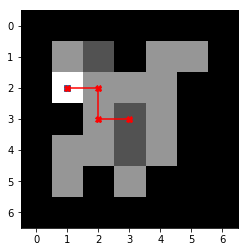

[2, 1]->[2, 2]->[3, 2]->[3, 3]->End


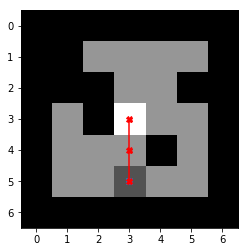

[3, 3]->[4, 3]->[5, 3]->End


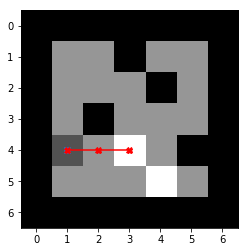

[4, 3]->[4, 2]->[4, 1]->End


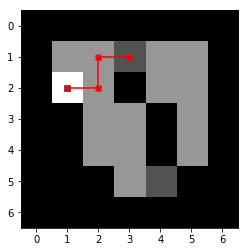

[2, 1]->[2, 2]->[1, 2]->[1, 3]->End


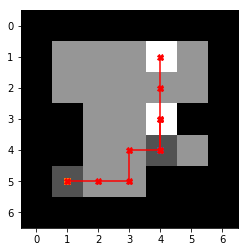

[1, 4]->[2, 4]->[3, 4]->[4, 4]->End
[3, 4]->[4, 4]->[4, 3]->[5, 3]->[5, 2]->[5, 1]->End


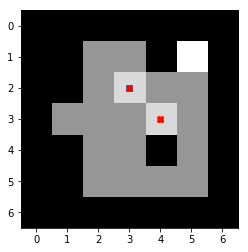

[2, 3]->End
[3, 4]->End


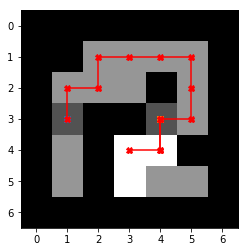

[4, 4]->[3, 4]->[3, 5]->[2, 5]->[1, 5]->[1, 4]->[1, 3]->[1, 2]->[2, 2]->[2, 1]->[3, 1]->End
[4, 3]->[4, 4]->[3, 4]->End


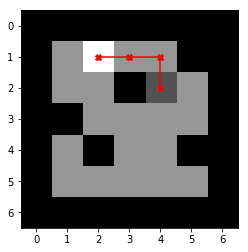

[1, 2]->[1, 3]->[1, 4]->[2, 4]->End


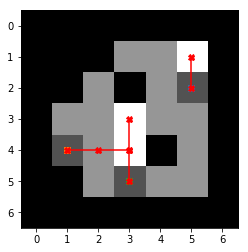

[1, 5]->[2, 5]->End
[4, 3]->[4, 2]->[4, 1]->End
[3, 3]->[4, 3]->[5, 3]->End


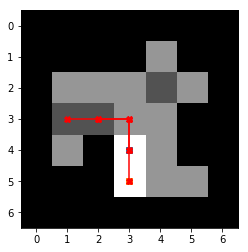

[4, 3]->[3, 3]->[3, 2]->[3, 1]->End
[5, 3]->[4, 3]->[3, 3]->[3, 2]->End


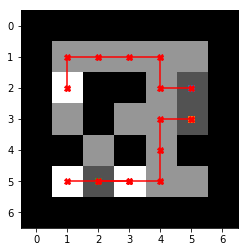

[2, 1]->[1, 1]->[1, 2]->[1, 3]->[1, 4]->[2, 4]->[2, 5]->End
[5, 1]->[5, 2]->[5, 3]->[5, 4]->[4, 4]->[3, 4]->[3, 5]->End
[5, 3]->[5, 2]->End


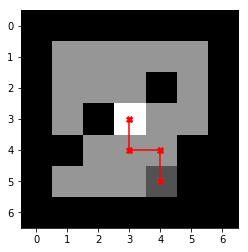

[3, 3]->[4, 3]->[4, 4]->[5, 4]->End


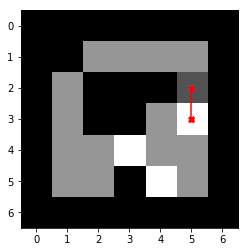

[3, 5]->[2, 5]->End


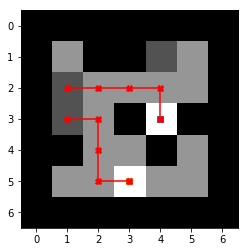

[3, 4]->[2, 4]->[2, 3]->[2, 2]->[2, 1]->End
[5, 3]->[5, 2]->[4, 2]->[3, 2]->[3, 1]->End


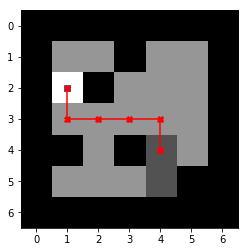

[2, 1]->[3, 1]->[3, 2]->[3, 3]->[3, 4]->[4, 4]->End


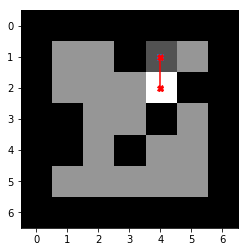

[2, 4]->[1, 4]->End


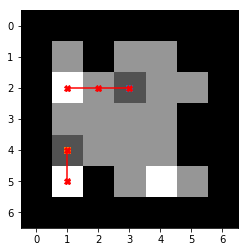

[2, 1]->[2, 2]->[2, 3]->End
[5, 1]->[4, 1]->End


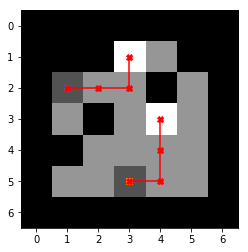

[1, 3]->[2, 3]->[2, 2]->[2, 1]->End
[3, 4]->[4, 4]->[5, 4]->[5, 3]->End


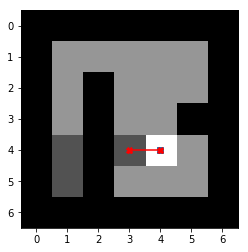

[4, 4]->[4, 3]->End


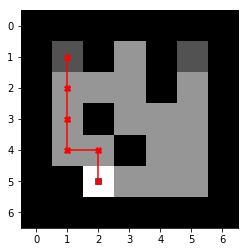

[5, 2]->[4, 2]->[4, 1]->[3, 1]->[2, 1]->[1, 1]->End


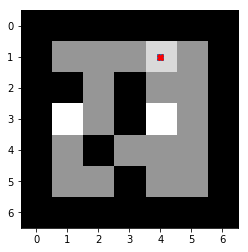

[1, 4]->End


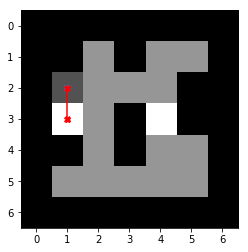

[3, 1]->[2, 1]->End


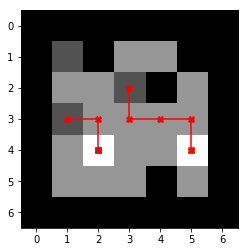

[4, 2]->[3, 2]->[3, 1]->End
[4, 5]->[3, 5]->[3, 4]->[3, 3]->[2, 3]->End


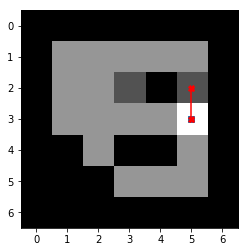

[3, 5]->[2, 5]->End


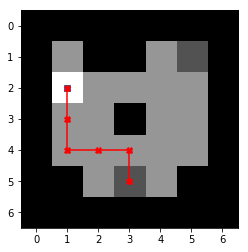

[2, 1]->[3, 1]->[4, 1]->[4, 2]->[4, 3]->[5, 3]->End


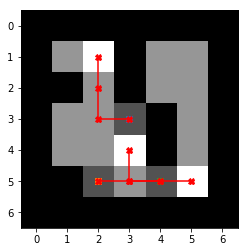

[1, 2]->[2, 2]->[3, 2]->[3, 3]->End
[5, 5]->[5, 4]->[5, 3]->[5, 2]->End
[4, 3]->[5, 3]->[5, 4]->End


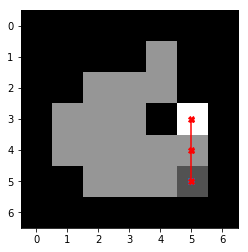

[3, 5]->[4, 5]->[5, 5]->End


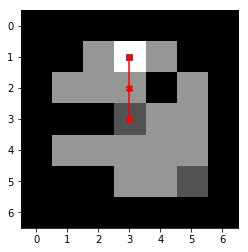

[1, 3]->[2, 3]->[3, 3]->End


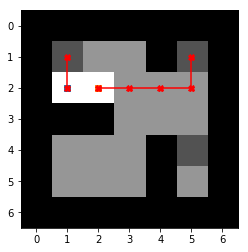

[2, 1]->[1, 1]->End
[2, 2]->[2, 3]->[2, 4]->[2, 5]->[1, 5]->End


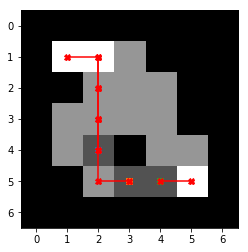

[1, 1]->[1, 2]->[2, 2]->[3, 2]->[4, 2]->End
[1, 2]->[2, 2]->[3, 2]->[4, 2]->[5, 2]->[5, 3]->End
[5, 5]->[5, 4]->End


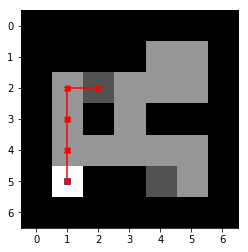

[5, 1]->[4, 1]->[3, 1]->[2, 1]->[2, 2]->End


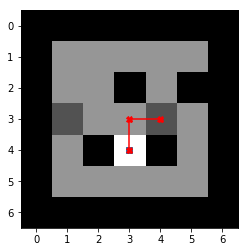

[4, 3]->[3, 3]->[3, 4]->End


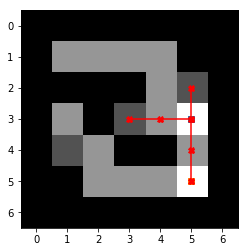

[3, 5]->[3, 4]->[3, 3]->End
[5, 5]->[4, 5]->[3, 5]->[2, 5]->End


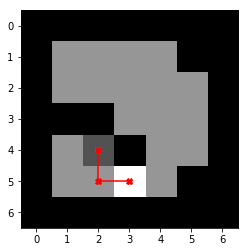

[5, 3]->[5, 2]->[4, 2]->End


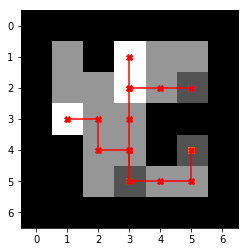

[1, 3]->[2, 3]->[2, 4]->[2, 5]->End
[2, 3]->[3, 3]->[4, 3]->[5, 3]->[5, 4]->[5, 5]->[4, 5]->End
[3, 1]->[3, 2]->[4, 2]->[4, 3]->[5, 3]->End


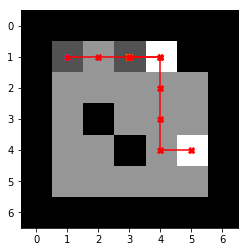

[1, 4]->[1, 3]->[1, 2]->[1, 1]->End
[4, 5]->[4, 4]->[3, 4]->[2, 4]->[1, 4]->[1, 3]->End


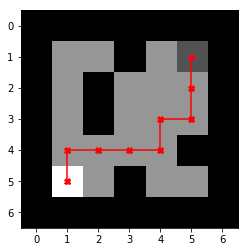

[5, 1]->[4, 1]->[4, 2]->[4, 3]->[4, 4]->[3, 4]->[3, 5]->[2, 5]->[1, 5]->End


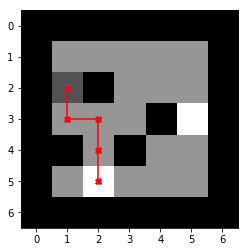

[5, 2]->[4, 2]->[3, 2]->[3, 1]->[2, 1]->End


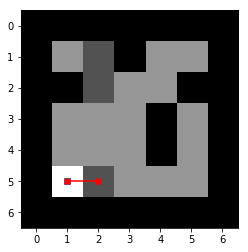

[5, 1]->[5, 2]->End


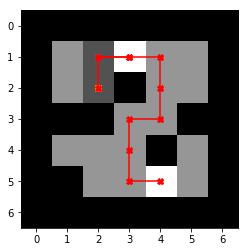

[5, 4]->[5, 3]->[4, 3]->[3, 3]->[3, 4]->[2, 4]->[1, 4]->[1, 3]->[1, 2]->End
[1, 3]->[1, 2]->[2, 2]->End


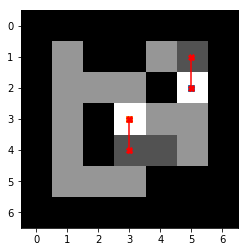

[2, 5]->[1, 5]->End
[3, 3]->[4, 3]->End


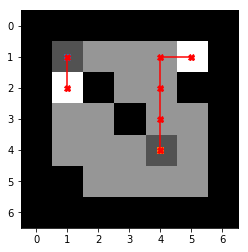

[2, 1]->[1, 1]->End
[1, 5]->[1, 4]->[2, 4]->[3, 4]->[4, 4]->End


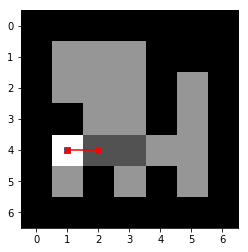

[4, 1]->[4, 2]->End


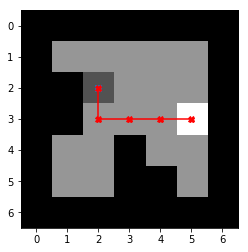

[3, 5]->[3, 4]->[3, 3]->[3, 2]->[2, 2]->End


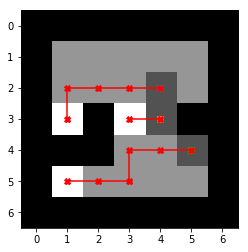

[3, 1]->[2, 1]->[2, 2]->[2, 3]->[2, 4]->End
[3, 3]->[3, 4]->End
[5, 1]->[5, 2]->[5, 3]->[4, 3]->[4, 4]->[4, 5]->End


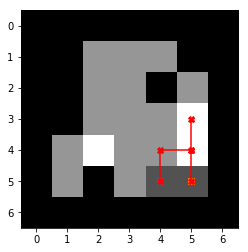

[4, 5]->[4, 4]->[5, 4]->End
[3, 5]->[4, 5]->[5, 5]->End


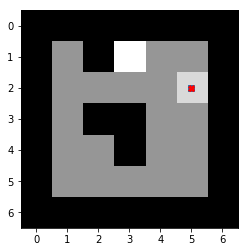

[2, 5]->End


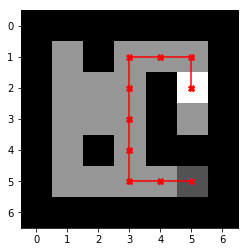

[2, 5]->[1, 5]->[1, 4]->[1, 3]->[2, 3]->[3, 3]->[4, 3]->[5, 3]->[5, 4]->[5, 5]->End


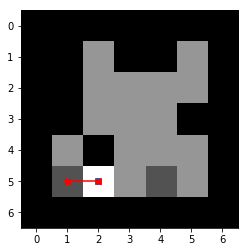

[5, 2]->[5, 1]->End
Goal_accuray: 1.0
110.0 110.0
Average_Step_error_in_each_domain : 4.202702702702703
311.0 74.0


In [98]:
correct, traj_step, total,total_env = 0.0,0.0,0.0,0.0

X,S,label = test_data[0].copy()

prev_env = X.clone()

whole_traj_act = []

Trajectory = [S]
Action  = [label]

go = np.where(X[1] == 1.0) 
goal = np.column_stack([go[0],go[1]])

end = len(test_data)


for i in range(1,600):
    X,S,label = test_data[i].copy()
    
    new_env = X.clone()
    
   
    if (new_env[0] - prev_env[0]).sum() == 0.0:

        if label != 4:
            Trajectory.append(S)
            Action.append(label)
        else:
            Trajectory.append(S)
            Action.append(label)
            whole_traj_act.append([Trajectory,Action])
            Trajectory = []
            Action = []
    else :
        #call the function with prev_new and whole traj act
        total_env += 1
        #correct_goal,total_goal, traj_length,traj = agent_prediction(model_5x5,prev_env.clone(),whole_traj_act,goal,7,0)
        correct_goal,total_goal, traj_length,traj,change = cooperative(model=model_5x5,X=prev_env.clone(),imsize=7)
     
        dom = prev_env[0] - 0.5 * prev_env[1] + prev_env[2]
        visualization(dom,traj)
        
        if change == 1:
            for i in traj:
                L = len(i[0])
                for j in range(L-1,-1,-1):
                    print([i[0][j][0].item(),i[0][j][1].item()],end='->')
                print("End")
        else :
            for i in traj:
                for j in i[0]:
                   print([j[0].item(),j[1].item()],end='->')
                print("End")
          
        correct += correct_goal
        total += total_goal
        traj_step += traj_length
        
        prev_env = new_env.clone()
        
        
        whole_traj_act = []
        go = np.where(prev_env[1] == 1.0) 
        goal = np.column_stack([go[0],go[1]])
        
        
print(f'Goal_accuray: {correct /total}')
print(correct,total)
print(f'Average_Step_error_in_each_domain : {traj_step/total_env}')
print(traj_step,total_env)

In [82]:
  traj[0][0][0][0],traj[0][0][0][1]

(tensor(2), tensor(1))

In [0]:
correct, traj_step, total,total_env = 0.0,0.0,0.0,0.0

X,S,label = test_data[0].copy()

prev_env = X.clone()

whole_traj_act = []

Trajectory = [S]
Action  = [label]

go = np.where(X[1] == 1.0) 
goal = np.column_stack([go[0],go[1]])

end = len(test_data)


for i in range(1,end):
    X,S,label = test_data[i].copy()
    
    new_env = X.clone()
    
   
    if (new_env[0] - prev_env[0]).sum() == 0.0:

        if label != 4:
            Trajectory.append(S)
            Action.append(label)
        else:
            Trajectory.append(S)
            Action.append(label)
            whole_traj_act.append([Trajectory,Action])
            Trajectory = []
            Action = []
    else :
        #call the function with prev_new and whole traj act
        total_env += 1
        correct_goal,total_goal, traj_length,traj = agent_prediction(model_5x5,prev_env.clone(),whole_traj_act,goal,7,0)
        #correct_goal,total_goal, traj_length,traj = cooperative(model=model_5x5,X=prev_env.clone(),imsize=7)
        
        total += total_goal

        correct += correct_goal
        traj_step += traj_length
        
        prev_env = new_env.clone()
        
        
        whole_traj_act = []
        go = np.where(prev_env[1] == 1.0) 
        goal = np.column_stack([go[0],go[1]])
        
        
print(f'Goal_accuray: {correct /total}')
print(correct,total)
print(f'Average_Step_error_in_each_domain : {traj_step/total_env}')
print(traj_step,total_env)

Goal_accuray: 0.9466596250330077
7170.0 7574.0
Average_Step_error_in_each_domain : 4.9297638436482085
24215.0 4912.0


In [0]:
test = []
with np.load('train_4_data.npz', mmap_mode='r',allow_pickle=True) as f:
    test = f['arr_0']

In [0]:
test_data = []

for i in test:
    env = -1 *(i[0] == 0) + 1.0
    goal = (i[0] == 0.5) + 0.0
    Agent = i[1]
    
    
    p_env = np.zeros([10,10])
    p_env[1:9,1:9] = env
    p_goal = np.zeros([10,10])
    p_goal[1:9,1:9] = goal
    p_agent = np.zeros([10,10])
    p_agent[1:9,1:9] = Agent
    
    domain = np.array([p_env,p_goal,p_agent])
    test_data.append([torch.tensor(domain),torch.tensor([i[2][0]+1,i[2][1]+1]),torch.tensor(i[3])])

In [101]:
model_8x8 = MA_P(10,10)
model_8x8.load_state_dict(torch.load('MA_P_2_9_2.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [102]:
model_8x8.cuda()

MA_P(
  (h): Conv2d(3, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (r): Conv2d(150, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (q): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (sm): Softmax()
)

In [0]:
correct, traj_step, total,total_env = 0.0,0.0,0.0,0.0

X,S,label = test_data[0].copy()

prev_env = X.clone()

whole_traj_act = []

Trajectory = [S]
Action  = [label]

go = np.where(X[1] == 1.0) 
goal = np.column_stack([go[0],go[1]])

end = len(test_data)


for i in range(1,end):
    X,S,label = test_data[i].copy()
    
    new_env = X.clone()
    
   
    if (new_env[0] - prev_env[0]).sum() == 0.0:

        if label != 4:
            Trajectory.append(S)
            Action.append(label)
        else:
            Trajectory.append(S)
            Action.append(label)
            whole_traj_act.append([Trajectory,Action])
            Trajectory = []
            Action = []
    else :
        #call the function with prev_new and whole traj act
        total_env += 1
        correct_goal,total_goal, traj_length,traj = agent_prediction(model_8x8,prev_env.clone(),whole_traj_act,goal,10,0)
        #correct_goal,total_goal, traj_length,traj = cooperative(model=model_8x8,X=prev_env.clone(),imsize=10)
        
        
        total += total_goal

        correct += correct_goal
        traj_step += traj_length
        
        prev_env = new_env.clone()
        
        
        whole_traj_act = []
        go = np.where(prev_env[1] == 1.0) 
        goal = np.column_stack([go[0],go[1]])
        
        
print(f'Goal_accuray: {correct /total}')
print(correct,total)
print(f'Average_Step_error_in_each_domain : {traj_step/total_env}')
print(traj_step,total_env)

Goal_accuray: 0.9671855279764409
6897.0 7131.0
Average_Step_error_in_each_domain : 8.286590038314177
32442.0 3915.0


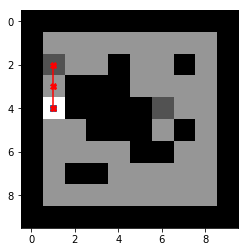

[4, 1]->[3, 1]->[2, 1]->End


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


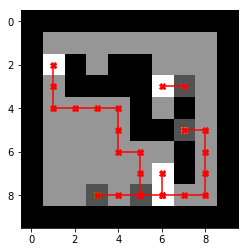

[3, 6]->[3, 7]->End
[7, 6]->[8, 6]->[8, 7]->[8, 8]->[7, 8]->[6, 8]->[5, 8]->[5, 7]->End
[8, 6]->[8, 5]->[8, 4]->[8, 3]->End
[2, 1]->[3, 1]->[4, 1]->[4, 2]->[4, 3]->[4, 4]->[5, 4]->[6, 4]->[6, 5]->[7, 5]->[8, 5]->End


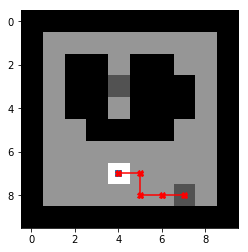

[7, 4]->[7, 5]->[8, 5]->[8, 6]->[8, 7]->End


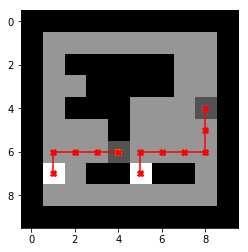

[7, 5]->[6, 5]->[6, 6]->[6, 7]->[6, 8]->[5, 8]->[4, 8]->End
[7, 1]->[6, 1]->[6, 2]->[6, 3]->[6, 4]->End


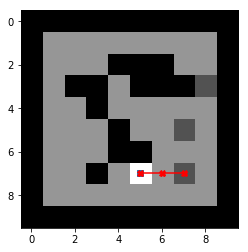

[7, 5]->[7, 6]->[7, 7]->End


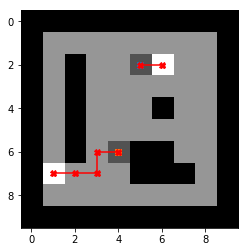

[2, 6]->[2, 5]->End
[7, 1]->[7, 2]->[7, 3]->[6, 3]->[6, 4]->End


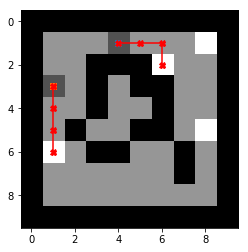

[2, 6]->[1, 6]->[1, 5]->[1, 4]->End
[6, 1]->[5, 1]->[4, 1]->[3, 1]->End


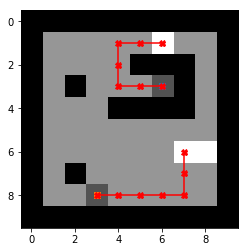

[1, 6]->[1, 5]->[1, 4]->[2, 4]->[3, 4]->[3, 5]->[3, 6]->End
[6, 7]->[7, 7]->[8, 7]->[8, 6]->[8, 5]->[8, 4]->[8, 3]->End


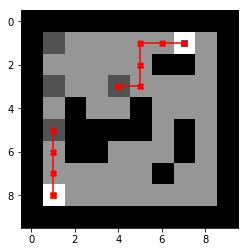

[1, 7]->[1, 6]->[1, 5]->[2, 5]->[3, 5]->[3, 4]->End
[8, 1]->[7, 1]->[6, 1]->[5, 1]->End


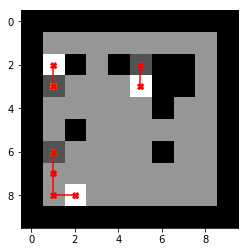

[3, 5]->[2, 5]->End
[2, 1]->[3, 1]->End
[8, 2]->[8, 1]->[7, 1]->[6, 1]->End


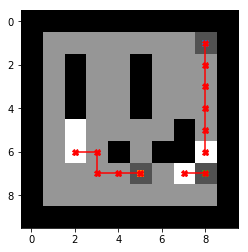

[6, 8]->[5, 8]->[4, 8]->[3, 8]->[2, 8]->[1, 8]->End
[6, 2]->[6, 3]->[7, 3]->[7, 4]->[7, 5]->End
[7, 7]->[7, 8]->End


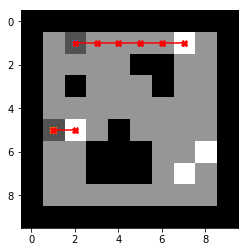

[1, 7]->[1, 6]->[1, 5]->[1, 4]->[1, 3]->[1, 2]->End
[5, 2]->[5, 1]->End


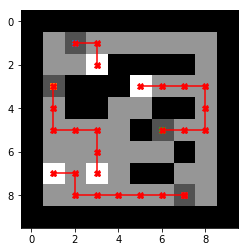

[2, 3]->[1, 3]->[1, 2]->End
[7, 3]->[6, 3]->[5, 3]->[5, 2]->[5, 1]->[4, 1]->[3, 1]->End
[3, 5]->[3, 6]->[3, 7]->[3, 8]->[4, 8]->[5, 8]->[5, 7]->[5, 6]->End
[7, 1]->[7, 2]->[8, 2]->[8, 3]->[8, 4]->[8, 5]->[8, 6]->[8, 7]->End


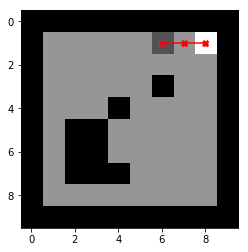

[1, 8]->[1, 7]->[1, 6]->End


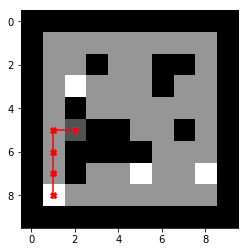

[8, 1]->[7, 1]->[6, 1]->[5, 1]->[5, 2]->End


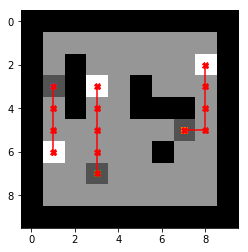

[6, 1]->[5, 1]->[4, 1]->[3, 1]->End
[2, 8]->[3, 8]->[4, 8]->[5, 8]->[5, 7]->End
[3, 3]->[4, 3]->[5, 3]->[6, 3]->[7, 3]->End


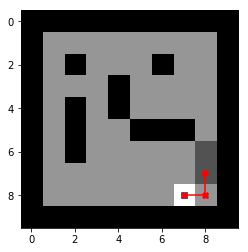

[8, 7]->[8, 8]->[7, 8]->End


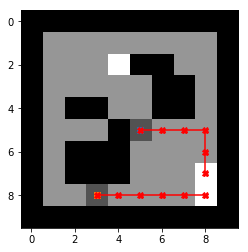

[7, 8]->[6, 8]->[5, 8]->[5, 7]->[5, 6]->[5, 5]->End
[8, 8]->[8, 7]->[8, 6]->[8, 5]->[8, 4]->[8, 3]->End


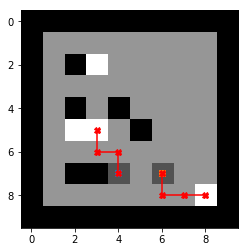

[5, 3]->[6, 3]->[6, 4]->[7, 4]->End
[8, 8]->[8, 7]->[8, 6]->[7, 6]->End


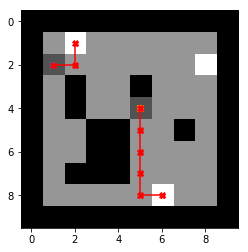

[1, 2]->[2, 2]->[2, 1]->End
[8, 6]->[8, 5]->[7, 5]->[6, 5]->[5, 5]->[4, 5]->End


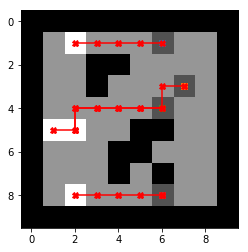

[1, 2]->[1, 3]->[1, 4]->[1, 5]->[1, 6]->End
[5, 2]->[4, 2]->[4, 3]->[4, 4]->[4, 5]->[4, 6]->[3, 6]->[3, 7]->End
[5, 1]->[5, 2]->[4, 2]->[4, 3]->[4, 4]->[4, 5]->[4, 6]->End
[8, 2]->[8, 3]->[8, 4]->[8, 5]->[8, 6]->End


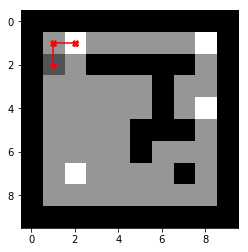

[1, 2]->[1, 1]->[2, 1]->End


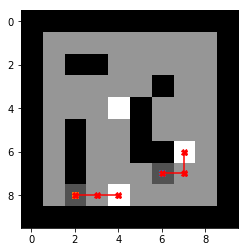

[6, 7]->[7, 7]->[7, 6]->End
[8, 4]->[8, 3]->[8, 2]->End


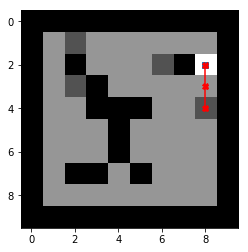

[2, 8]->[3, 8]->[4, 8]->End


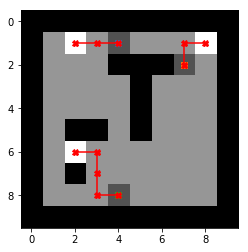

[1, 2]->[1, 3]->[1, 4]->End
[1, 8]->[1, 7]->[2, 7]->End
[6, 2]->[6, 3]->[7, 3]->[8, 3]->[8, 4]->End


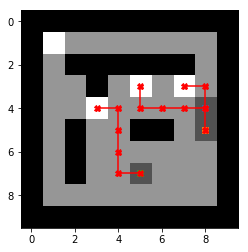

[3, 5]->[4, 5]->[4, 6]->[4, 7]->[4, 8]->End
[3, 7]->[3, 8]->[4, 8]->[5, 8]->End
[4, 3]->[4, 4]->[5, 4]->[6, 4]->[7, 4]->[7, 5]->End


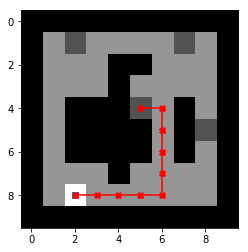

[8, 2]->[8, 3]->[8, 4]->[8, 5]->[8, 6]->[7, 6]->[6, 6]->[5, 6]->[4, 6]->[4, 5]->End


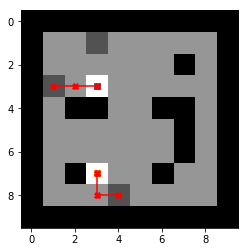

[3, 3]->[3, 2]->[3, 1]->End
[7, 3]->[8, 3]->[8, 4]->End


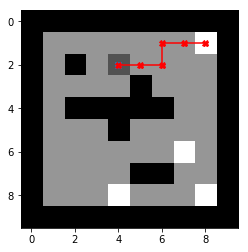

[1, 8]->[1, 7]->[1, 6]->[2, 6]->[2, 5]->[2, 4]->End


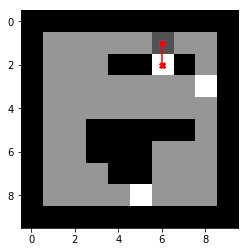

[2, 6]->[1, 6]->End


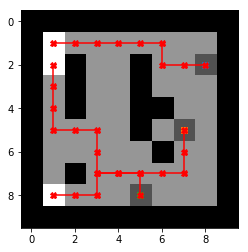

[1, 1]->[1, 2]->[1, 3]->[1, 4]->[1, 5]->[1, 6]->[2, 6]->[2, 7]->[2, 8]->End
[8, 1]->[8, 2]->[8, 3]->[7, 3]->[7, 4]->[7, 5]->[7, 6]->[7, 7]->[6, 7]->[5, 7]->End
[2, 1]->[3, 1]->[4, 1]->[5, 1]->[5, 2]->[5, 3]->[6, 3]->[7, 3]->[7, 4]->[7, 5]->[8, 5]->End


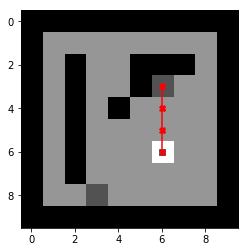

[6, 6]->[5, 6]->[4, 6]->[3, 6]->End


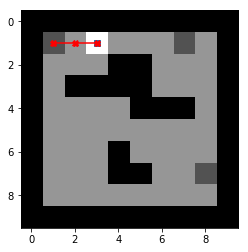

[1, 3]->[1, 2]->[1, 1]->End


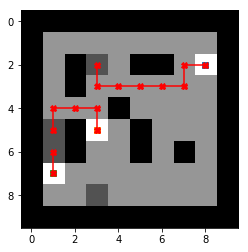

[2, 8]->[2, 7]->[3, 7]->[3, 6]->[3, 5]->[3, 4]->[3, 3]->[2, 3]->End
[5, 3]->[4, 3]->[4, 2]->[4, 1]->[5, 1]->End
[7, 1]->[6, 1]->End


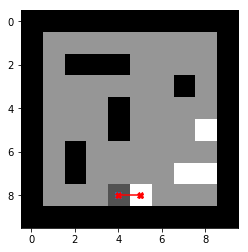

[8, 5]->[8, 4]->End


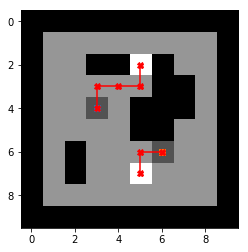

[2, 5]->[3, 5]->[3, 4]->[3, 3]->[4, 3]->End
[7, 5]->[6, 5]->[6, 6]->End


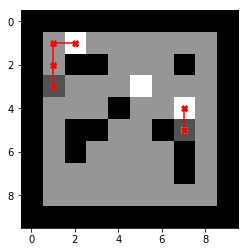

[1, 2]->[1, 1]->[2, 1]->[3, 1]->End
[4, 7]->[5, 7]->End


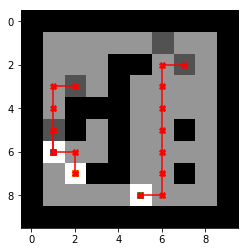

[6, 1]->[5, 1]->[4, 1]->[3, 1]->[3, 2]->End
[7, 2]->[6, 2]->[6, 1]->[5, 1]->End
[8, 5]->[8, 6]->[7, 6]->[6, 6]->[5, 6]->[4, 6]->[3, 6]->[2, 6]->[2, 7]->End


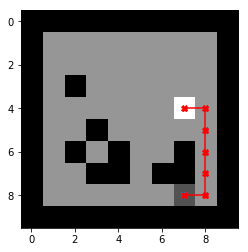

[4, 7]->[4, 8]->[5, 8]->[6, 8]->[7, 8]->[8, 8]->[8, 7]->End


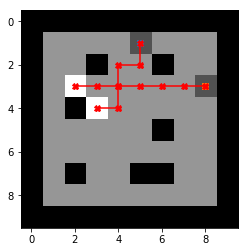

[4, 3]->[4, 4]->[3, 4]->[2, 4]->[2, 5]->[1, 5]->End
[3, 2]->[3, 3]->[3, 4]->[3, 5]->[3, 6]->[3, 7]->[3, 8]->End


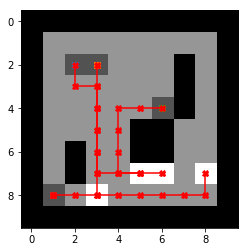

[7, 5]->[7, 4]->[7, 3]->[6, 3]->[5, 3]->[4, 3]->[3, 3]->[3, 2]->[2, 2]->End
[8, 3]->[7, 3]->[6, 3]->[5, 3]->[4, 3]->[3, 3]->[2, 3]->End
[7, 6]->[7, 5]->[7, 4]->[6, 4]->[5, 4]->[4, 4]->[4, 5]->[4, 6]->End
[7, 8]->[8, 8]->[8, 7]->[8, 6]->[8, 5]->[8, 4]->[8, 3]->[8, 2]->[8, 1]->End


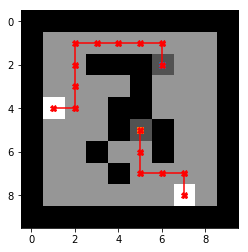

[4, 1]->[4, 2]->[3, 2]->[2, 2]->[1, 2]->[1, 3]->[1, 4]->[1, 5]->[1, 6]->[2, 6]->End
[8, 7]->[7, 7]->[7, 6]->[7, 5]->[6, 5]->[5, 5]->End


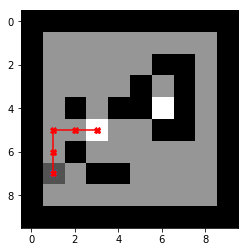

[5, 3]->[5, 2]->[5, 1]->[6, 1]->[7, 1]->End


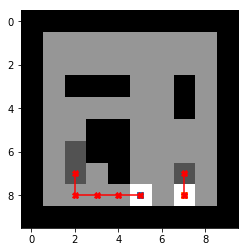

[8, 5]->[8, 4]->[8, 3]->[8, 2]->[7, 2]->End
[8, 7]->[7, 7]->End


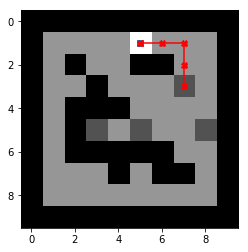

[1, 5]->[1, 6]->[1, 7]->[2, 7]->[3, 7]->End


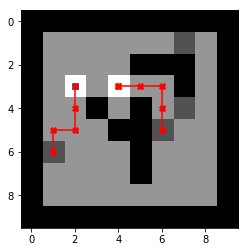

[3, 2]->[4, 2]->[5, 2]->[5, 1]->[6, 1]->End
[3, 4]->[3, 5]->[3, 6]->[4, 6]->[5, 6]->End


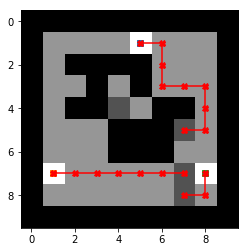

[1, 5]->[1, 6]->[2, 6]->[3, 6]->[3, 7]->[3, 8]->[4, 8]->[5, 8]->[5, 7]->End
[7, 1]->[7, 2]->[7, 3]->[7, 4]->[7, 5]->[7, 6]->[7, 7]->End
[7, 8]->[8, 8]->[8, 7]->End


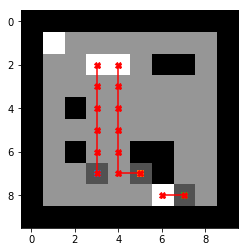

[2, 3]->[3, 3]->[4, 3]->[5, 3]->[6, 3]->[7, 3]->End
[2, 4]->[3, 4]->[4, 4]->[5, 4]->[6, 4]->[7, 4]->[7, 5]->End
[8, 6]->[8, 7]->End


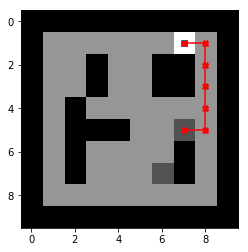

[1, 7]->[1, 8]->[2, 8]->[3, 8]->[4, 8]->[5, 8]->[5, 7]->End


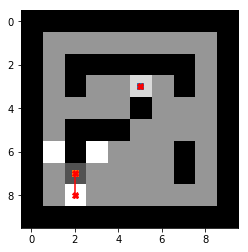

[3, 5]->End
[8, 2]->[7, 2]->End


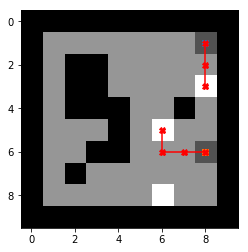

[3, 8]->[2, 8]->[1, 8]->End
[5, 6]->[6, 6]->[6, 7]->[6, 8]->End


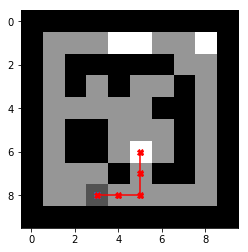

[6, 5]->[7, 5]->[8, 5]->[8, 4]->[8, 3]->End


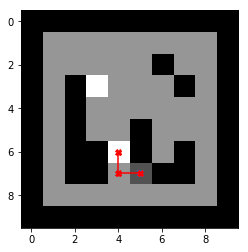

[6, 4]->[7, 4]->[7, 5]->End


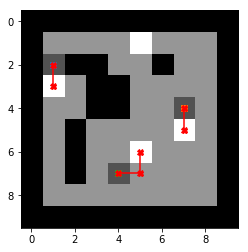

[3, 1]->[2, 1]->End
[5, 7]->[4, 7]->End
[6, 5]->[7, 5]->[7, 4]->End


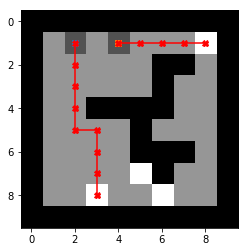

[8, 3]->[7, 3]->[6, 3]->[5, 3]->[5, 2]->[4, 2]->[3, 2]->[2, 2]->[1, 2]->End
[1, 8]->[1, 7]->[1, 6]->[1, 5]->[1, 4]->End


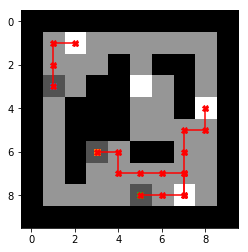

[1, 2]->[1, 1]->[2, 1]->[3, 1]->End
[8, 7]->[7, 7]->[7, 6]->[7, 5]->[7, 4]->[6, 4]->[6, 3]->End
[4, 8]->[5, 8]->[5, 7]->[6, 7]->[7, 7]->[8, 7]->[8, 6]->[8, 5]->End


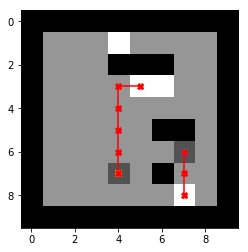

[8, 7]->[7, 7]->[6, 7]->End
[3, 5]->[3, 4]->[4, 4]->[5, 4]->[6, 4]->[7, 4]->End


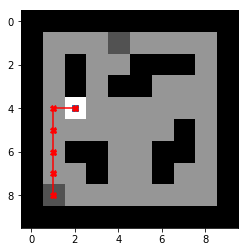

[4, 2]->[4, 1]->[5, 1]->[6, 1]->[7, 1]->[8, 1]->End


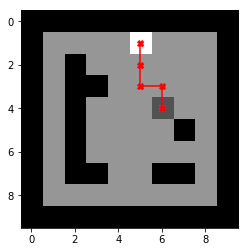

[1, 5]->[2, 5]->[3, 5]->[3, 6]->[4, 6]->End


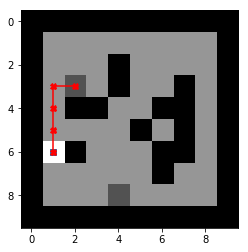

[6, 1]->[5, 1]->[4, 1]->[3, 1]->[3, 2]->End


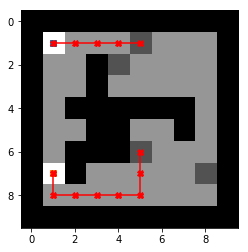

[1, 1]->[1, 2]->[1, 3]->[1, 4]->[1, 5]->End
[7, 1]->[8, 1]->[8, 2]->[8, 3]->[8, 4]->[8, 5]->[7, 5]->[6, 5]->End


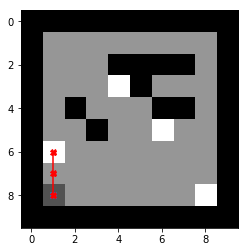

[6, 1]->[7, 1]->[8, 1]->End


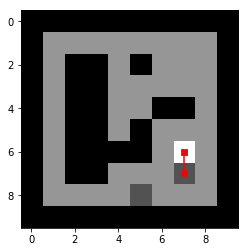

[6, 7]->[7, 7]->End


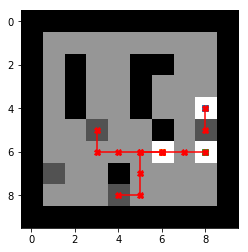

[4, 8]->[5, 8]->End
[6, 6]->[6, 5]->[6, 4]->[6, 3]->[5, 3]->End
[6, 8]->[6, 7]->[6, 6]->[6, 5]->[7, 5]->[8, 5]->[8, 4]->End


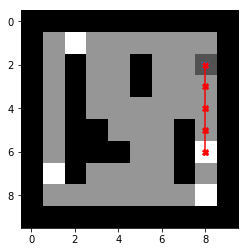

[6, 8]->[5, 8]->[4, 8]->[3, 8]->[2, 8]->End
Goal_accuray: 1.0
125.0 125.0
Average_Step_error_in_each_domain : 5.523076923076923
359.0 65.0


In [103]:
correct, traj_step, total,total_env = 0.0,0.0,0.0,0.0

X,S,label = test_data[0].copy()

prev_env = X.clone()

whole_traj_act = []

Trajectory = [S]
Action  = [label]

go = np.where(X[1] == 1.0) 
goal = np.column_stack([go[0],go[1]])

end = len(test_data)


for i in range(1,600):
    X,S,label = test_data[i].copy()
    
    new_env = X.clone()
    
   
    if (new_env[0] - prev_env[0]).sum() == 0.0:

        if label != 4:
            Trajectory.append(S)
            Action.append(label)
        else:
            Trajectory.append(S)
            Action.append(label)
            whole_traj_act.append([Trajectory,Action])
            Trajectory = []
            Action = []
    else :
        #call the function with prev_new and whole traj act
        total_env += 1
        #correct_goal,total_goal, traj_length,traj = agent_prediction(model_8x8,prev_env.clone(),whole_traj_act,goal,10,0)
        correct_goal,total_goal, traj_length,traj,change = cooperative(model=model_8x8,X=prev_env.clone(),imsize=10)
        
        
        dom = prev_env[0] - 0.5 * prev_env[1] + prev_env[2]
        visualization(dom,traj)
        
        if change == 1:
            for i in traj:
                L = len(i[0])
                for j in range(L-1,-1,-1):
                    print([i[0][j][0].item(),i[0][j][1].item()],end='->')
                print("End")
        else :
            for i in traj:
                for j in i[0]:
                   print([j[0].item(),j[1].item()],end='->')
                print("End")
        correct += correct_goal
        traj_step += traj_length
        total += total_goal
        prev_env = new_env.clone()
        
        
        whole_traj_act = []
        go = np.where(prev_env[1] == 1.0) 
        goal = np.column_stack([go[0],go[1]])
        
        
print(f'Goal_accuray: {correct /total}')
print(correct,total)
print(f'Average_Step_error_in_each_domain : {traj_step/total_env}')
print(traj_step,total_env)

In [0]:
test = []
with np.load('test_16x16_data.npz', mmap_mode='r',allow_pickle=True) as f:
    test = f['arr_0']

In [0]:
test_data = []

for i in test:
    env = -1 *(i[0] == 0) + 1.0
    goal = (i[0] == 0.5) + 0.0
    Agent = i[1]
    
    
    p_env = np.zeros([18,18])
    p_env[1:17,1:17] = env
    p_goal = np.zeros([18,18])
    p_goal[1:17,1:17] = goal
    p_agent = np.zeros([18,18])
    p_agent[1:17,1:17] = Agent
    
    domain = np.array([p_env,p_goal,p_agent])
    test_data.append([torch.tensor(domain),torch.tensor([i[2][0]+1,i[2][1]+1]),torch.tensor(i[3])])

In [106]:
model_16x16 = MA_P(16,18)
model_16x16.load_state_dict(torch.load('MA_P_2_9_2.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [107]:
model_16x16.cuda()

MA_P(
  (h): Conv2d(3, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (r): Conv2d(150, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (q): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (sm): Softmax()
)

In [0]:
correct, traj_step, total,total_env = 0.0,0.0,0.0,0.0

X,S,label = test_data[0].copy()

prev_env = X.clone()

whole_traj_act = []

Trajectory = [S]
Action  = [label]

go = np.where(X[1] == 1.0) 
goal = np.column_stack([go[0],go[1]])

end = len(test_data)


for i in range(1,end):
    X,S,label = test_data[i].copy()
    
    new_env = X.clone()
    
   
    if (new_env[0] - prev_env[0]).sum() == 0.0:

        if label != 4:
            Trajectory.append(S)
            Action.append(label)
        else:
            Trajectory.append(S)
            Action.append(label)
            whole_traj_act.append([Trajectory,Action])
            Trajectory = []
            Action = []
    else :
        #call the function with prev_new and whole traj act
        total_env += 1
        correct_goal,total_goal, traj_length,traj = agent_prediction(model_16x16,prev_env.clone(),whole_traj_act,goal,18,0)
        #correct_goal,total_goal, traj_length,traj = cooperative(model=model_16x16,X=prev_env.clone(),imsize=18)
        
        total += total_goal

        correct += correct_goal
        traj_step += traj_length
        
        prev_env = new_env.clone()
        
        
        whole_traj_act = []
        go = np.where(prev_env[1] == 1.0) 
        goal = np.column_stack([go[0],go[1]])
        
        
print(f'Goal_accuray: {correct /total}')
print(correct,total)
print(f'Average_Step_error_in_each_domain : {traj_step/total_env}')
print(traj_step,total_env)

Goal_accuray: 0.9473684210526315
126.0 133.0
Average_Step_error_in_each_domain : 13.040816326530612
639.0 49.0


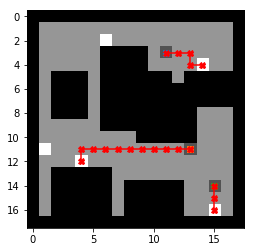

[4, 14]->[4, 13]->[3, 13]->[3, 12]->[3, 11]->End
[12, 4]->[11, 4]->[11, 5]->[11, 6]->[11, 7]->[11, 8]->[11, 9]->[11, 10]->[11, 11]->[11, 12]->[11, 13]->End
[16, 15]->[15, 15]->[14, 15]->End


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


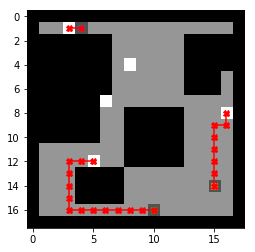

[1, 3]->[1, 4]->End
[8, 16]->[9, 16]->[9, 15]->[10, 15]->[11, 15]->[12, 15]->[13, 15]->[14, 15]->End
[12, 5]->[12, 4]->[12, 3]->[13, 3]->[14, 3]->[15, 3]->[16, 3]->[16, 4]->[16, 5]->[16, 6]->[16, 7]->[16, 8]->[16, 9]->[16, 10]->End


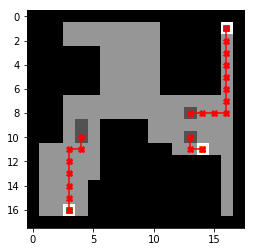

[1, 16]->[2, 16]->[3, 16]->[4, 16]->[5, 16]->[6, 16]->[7, 16]->[8, 16]->[8, 15]->[8, 14]->[8, 13]->End
[11, 14]->[11, 13]->[10, 13]->End
[16, 3]->[15, 3]->[14, 3]->[13, 3]->[12, 3]->[11, 3]->[11, 4]->[10, 4]->End


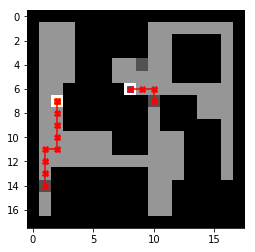

[6, 8]->[6, 9]->[6, 10]->[7, 10]->End
[7, 2]->[8, 2]->[9, 2]->[10, 2]->[11, 2]->[11, 1]->[12, 1]->[13, 1]->[14, 1]->End


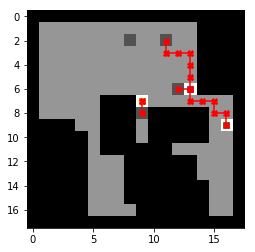

[6, 13]->[5, 13]->[4, 13]->[3, 13]->[3, 12]->[3, 11]->[2, 11]->End
[7, 9]->[8, 9]->End
[9, 16]->[8, 16]->[8, 15]->[7, 15]->[7, 14]->[7, 13]->[6, 13]->[6, 12]->End


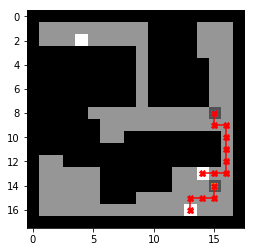

[13, 14]->[13, 15]->[13, 16]->[12, 16]->[11, 16]->[10, 16]->[9, 16]->[9, 15]->[8, 15]->End
[16, 13]->[15, 13]->[15, 14]->[15, 15]->[14, 15]->End


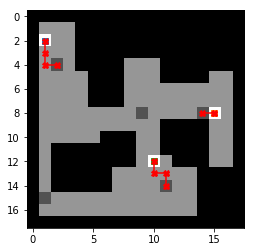

[2, 1]->[3, 1]->[4, 1]->[4, 2]->End
[8, 15]->[8, 14]->End
[12, 10]->[13, 10]->[13, 11]->[14, 11]->End


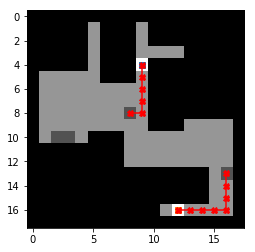

[4, 9]->[5, 9]->[6, 9]->[7, 9]->[8, 9]->[8, 8]->End
[16, 12]->[16, 13]->[16, 14]->[16, 15]->[16, 16]->[15, 16]->[14, 16]->[13, 16]->End


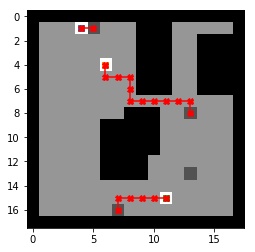

[1, 4]->[1, 5]->End
[4, 6]->[5, 6]->[5, 7]->[5, 8]->[6, 8]->[7, 8]->[7, 9]->[7, 10]->[7, 11]->[7, 12]->[7, 13]->[8, 13]->End
[15, 11]->[15, 10]->[15, 9]->[15, 8]->[15, 7]->[16, 7]->End


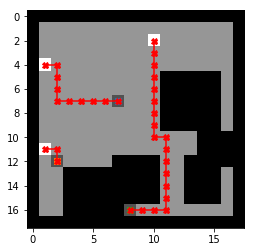

[4, 1]->[4, 2]->[5, 2]->[6, 2]->[7, 2]->[7, 3]->[7, 4]->[7, 5]->[7, 6]->[7, 7]->End
[11, 1]->[11, 2]->[12, 2]->End
[2, 10]->[3, 10]->[4, 10]->[5, 10]->[6, 10]->[7, 10]->[8, 10]->[9, 10]->[10, 10]->[10, 11]->[11, 11]->[12, 11]->[13, 11]->[14, 11]->[15, 11]->[16, 11]->[16, 10]->[16, 9]->[16, 8]->End


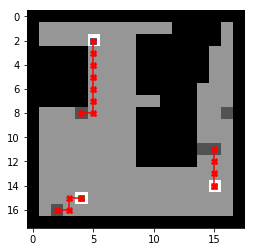

[2, 5]->[3, 5]->[4, 5]->[5, 5]->[6, 5]->[7, 5]->[8, 5]->[8, 4]->End
[14, 15]->[13, 15]->[12, 15]->[11, 15]->End
[15, 4]->[15, 3]->[16, 3]->[16, 2]->End


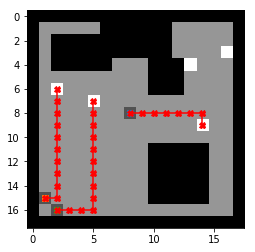

[9, 14]->[8, 14]->[8, 13]->[8, 12]->[8, 11]->[8, 10]->[8, 9]->[8, 8]->End
[6, 2]->[7, 2]->[8, 2]->[9, 2]->[10, 2]->[11, 2]->[12, 2]->[13, 2]->[14, 2]->[15, 2]->[15, 1]->End
[7, 5]->[8, 5]->[9, 5]->[10, 5]->[11, 5]->[12, 5]->[13, 5]->[14, 5]->[15, 5]->[16, 5]->[16, 4]->[16, 3]->[16, 2]->End


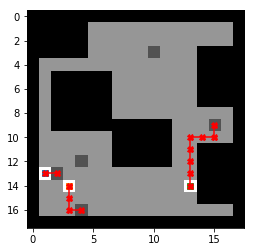

[13, 1]->[13, 2]->End
[14, 3]->[15, 3]->[16, 3]->[16, 4]->End
[14, 13]->[13, 13]->[12, 13]->[11, 13]->[10, 13]->[10, 14]->[10, 15]->[9, 15]->End


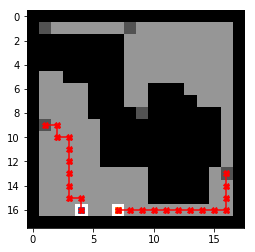

[16, 4]->[15, 4]->[15, 3]->[14, 3]->[13, 3]->[12, 3]->[11, 3]->[10, 3]->[10, 2]->[9, 2]->[9, 1]->End
[16, 7]->[16, 8]->[16, 9]->[16, 10]->[16, 11]->[16, 12]->[16, 13]->[16, 14]->[16, 15]->[16, 16]->[15, 16]->[14, 16]->[13, 16]->End


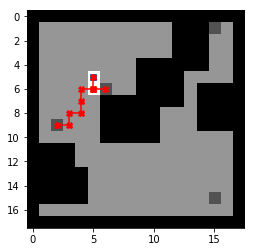

[5, 5]->[6, 5]->[6, 6]->End
[6, 5]->[6, 4]->[7, 4]->[8, 4]->[8, 3]->[9, 3]->[9, 2]->End


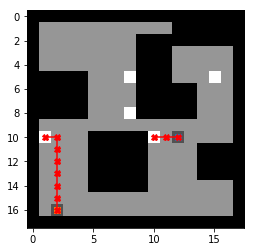

[10, 10]->[10, 11]->[10, 12]->End
[10, 1]->[10, 2]->[11, 2]->[12, 2]->[13, 2]->[14, 2]->[15, 2]->[16, 2]->End


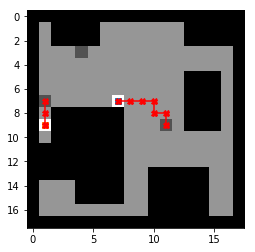

[7, 7]->[7, 8]->[7, 9]->[7, 10]->[8, 10]->[8, 11]->[9, 11]->End
[9, 1]->[8, 1]->[7, 1]->End


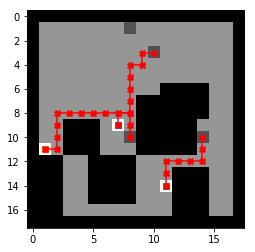

[9, 7]->[8, 7]->[8, 8]->[7, 8]->[6, 8]->[5, 8]->[4, 8]->[4, 9]->[3, 9]->[3, 10]->End
[11, 1]->[11, 2]->[10, 2]->[9, 2]->[8, 2]->[8, 3]->[8, 4]->[8, 5]->[8, 6]->[8, 7]->[8, 8]->[9, 8]->[10, 8]->End
[14, 11]->[13, 11]->[12, 11]->[12, 12]->[12, 13]->[12, 14]->[11, 14]->[10, 14]->End


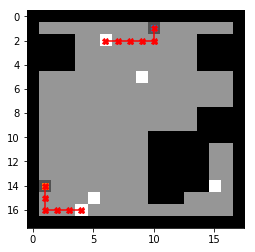

[2, 6]->[2, 7]->[2, 8]->[2, 9]->[2, 10]->[1, 10]->End
[16, 4]->[16, 3]->[16, 2]->[16, 1]->[15, 1]->[14, 1]->End


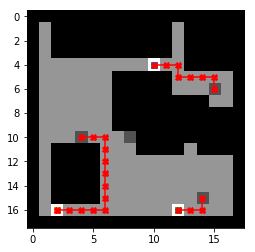

[4, 10]->[4, 11]->[4, 12]->[5, 12]->[5, 13]->[5, 14]->[5, 15]->[6, 15]->End
[16, 2]->[16, 3]->[16, 4]->[16, 5]->[16, 6]->[15, 6]->[14, 6]->[13, 6]->[12, 6]->[11, 6]->[10, 6]->[10, 5]->[10, 4]->End
[16, 12]->[16, 13]->[16, 14]->[15, 14]->End


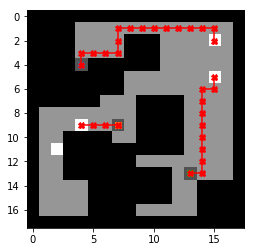

[2, 15]->[1, 15]->[1, 14]->[1, 13]->[1, 12]->[1, 11]->[1, 10]->[1, 9]->[1, 8]->[1, 7]->[2, 7]->[3, 7]->[3, 6]->[3, 5]->[3, 4]->[4, 4]->End
[9, 4]->[9, 5]->[9, 6]->[9, 7]->End
[5, 15]->[6, 15]->[6, 14]->[7, 14]->[8, 14]->[9, 14]->[10, 14]->[11, 14]->[12, 14]->[13, 14]->[13, 13]->End


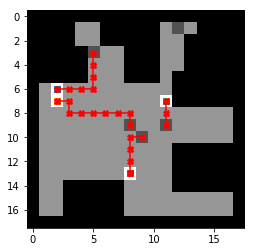

[6, 2]->[6, 3]->[6, 4]->[6, 5]->[5, 5]->[4, 5]->[3, 5]->End
[7, 2]->[7, 3]->[8, 3]->[8, 4]->[8, 5]->[8, 6]->[8, 7]->[8, 8]->[9, 8]->End
[7, 11]->[8, 11]->[9, 11]->End
[13, 8]->[12, 8]->[11, 8]->[10, 8]->[10, 9]->End


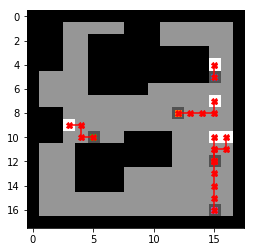

[4, 15]->[5, 15]->End
[7, 15]->[8, 15]->[8, 14]->[8, 13]->[8, 12]->End
[9, 3]->[9, 4]->[10, 4]->[10, 5]->End
[10, 16]->[11, 16]->[11, 15]->[12, 15]->End
[10, 15]->[11, 15]->[12, 15]->[13, 15]->[14, 15]->[15, 15]->[16, 15]->End


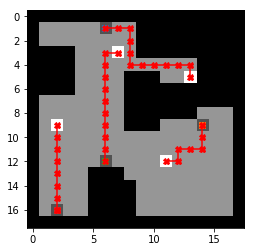

[5, 13]->[4, 13]->[4, 12]->[4, 11]->[4, 10]->[4, 9]->[4, 8]->[3, 8]->[2, 8]->[1, 8]->[1, 7]->[1, 6]->End
[12, 11]->[12, 12]->[11, 12]->[11, 13]->[11, 14]->[10, 14]->[9, 14]->End
[3, 7]->[3, 6]->[4, 6]->[5, 6]->[6, 6]->[7, 6]->[8, 6]->[9, 6]->[10, 6]->[11, 6]->[12, 6]->End
[9, 2]->[10, 2]->[11, 2]->[12, 2]->[13, 2]->[14, 2]->[15, 2]->[16, 2]->End


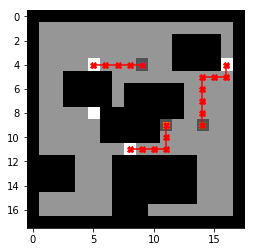

[4, 5]->[4, 6]->[4, 7]->[4, 8]->[4, 9]->End
[11, 8]->[11, 9]->[11, 10]->[11, 11]->[10, 11]->[9, 11]->End
[4, 16]->[5, 16]->[5, 15]->[5, 14]->[6, 14]->[7, 14]->[8, 14]->[9, 14]->End


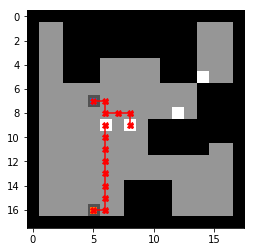

[9, 8]->[8, 8]->[8, 7]->[8, 6]->[7, 6]->[7, 5]->End
[9, 6]->[10, 6]->[11, 6]->[12, 6]->[13, 6]->[14, 6]->[15, 6]->[16, 6]->[16, 5]->End


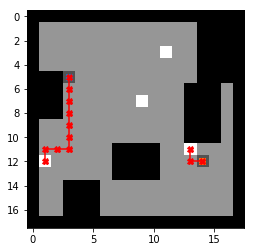

[12, 1]->[11, 1]->[11, 2]->[11, 3]->[10, 3]->[9, 3]->[8, 3]->[7, 3]->[6, 3]->[5, 3]->End
[11, 13]->[12, 13]->[12, 14]->End


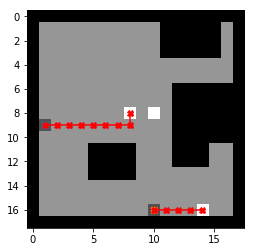

[8, 8]->[9, 8]->[9, 7]->[9, 6]->[9, 5]->[9, 4]->[9, 3]->[9, 2]->[9, 1]->End
[16, 14]->[16, 13]->[16, 12]->[16, 11]->[16, 10]->End


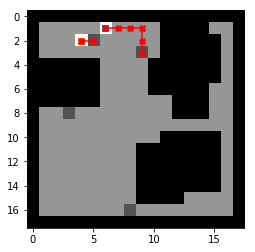

[1, 6]->[1, 7]->[1, 8]->[1, 9]->[2, 9]->[3, 9]->End
[2, 4]->[2, 5]->End


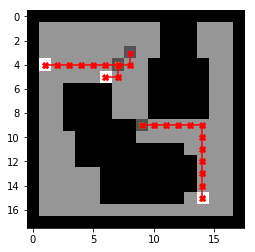

[5, 6]->[5, 7]->[4, 7]->[4, 8]->[3, 8]->End
[4, 1]->[4, 2]->[4, 3]->[4, 4]->[4, 5]->[4, 6]->[4, 7]->End
[15, 14]->[14, 14]->[13, 14]->[12, 14]->[11, 14]->[10, 14]->[9, 14]->[9, 13]->[9, 12]->[9, 11]->[9, 10]->[9, 9]->End


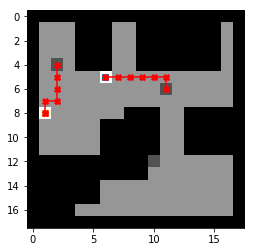

[5, 6]->[5, 7]->[5, 8]->[5, 9]->[5, 10]->[5, 11]->[6, 11]->End
[8, 1]->[7, 1]->[7, 2]->[6, 2]->[5, 2]->[4, 2]->End


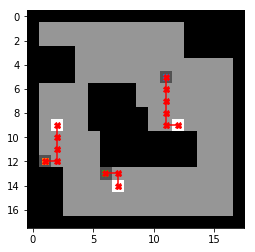

[9, 12]->[9, 11]->[8, 11]->[7, 11]->[6, 11]->[5, 11]->End
[9, 2]->[10, 2]->[11, 2]->[12, 2]->[12, 1]->End
[14, 7]->[13, 7]->[13, 6]->End


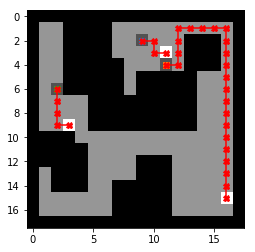

[3, 11]->[3, 10]->[2, 10]->[2, 9]->End
[15, 16]->[14, 16]->[13, 16]->[12, 16]->[11, 16]->[10, 16]->[9, 16]->[8, 16]->[7, 16]->[6, 16]->[5, 16]->[4, 16]->[3, 16]->[2, 16]->[1, 16]->[1, 15]->[1, 14]->[1, 13]->[1, 12]->[2, 12]->[3, 12]->[4, 12]->[4, 11]->End
[9, 3]->[9, 2]->[8, 2]->[7, 2]->[6, 2]->End


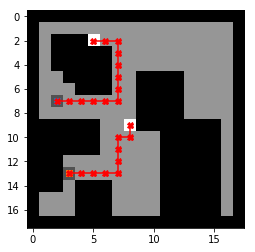

[2, 5]->[2, 6]->[2, 7]->[3, 7]->[4, 7]->[5, 7]->[6, 7]->[7, 7]->[7, 6]->[7, 5]->[7, 4]->[7, 3]->[7, 2]->End
[9, 8]->[10, 8]->[10, 7]->[11, 7]->[12, 7]->[13, 7]->[13, 6]->[13, 5]->[13, 4]->[13, 3]->End


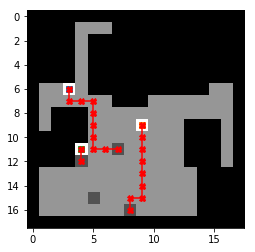

[6, 3]->[7, 3]->[7, 4]->[7, 5]->[8, 5]->[9, 5]->[10, 5]->[11, 5]->[11, 6]->[11, 7]->End
[9, 9]->[10, 9]->[11, 9]->[12, 9]->[13, 9]->[14, 9]->[15, 9]->[15, 8]->[16, 8]->End
[11, 4]->[12, 4]->End


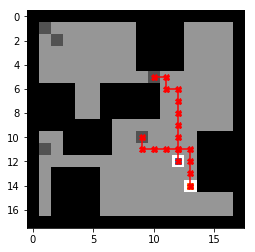

[12, 12]->[11, 12]->[10, 12]->[9, 12]->[8, 12]->[7, 12]->[6, 12]->[6, 11]->[5, 11]->[5, 10]->End
[14, 13]->[13, 13]->[12, 13]->[11, 13]->[11, 12]->[11, 11]->[11, 10]->[11, 9]->[10, 9]->End


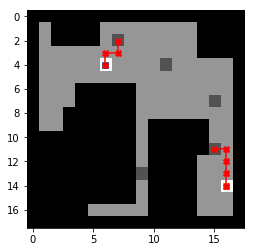

[4, 6]->[3, 6]->[3, 7]->[2, 7]->End
[14, 16]->[13, 16]->[12, 16]->[11, 16]->[11, 15]->End


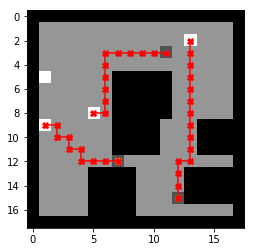

[8, 5]->[8, 6]->[7, 6]->[6, 6]->[5, 6]->[4, 6]->[3, 6]->[3, 7]->[3, 8]->[3, 9]->[3, 10]->[3, 11]->End
[9, 1]->[9, 2]->[10, 2]->[10, 3]->[11, 3]->[11, 4]->[12, 4]->[12, 5]->[12, 6]->[12, 7]->End
[2, 13]->[3, 13]->[4, 13]->[5, 13]->[6, 13]->[7, 13]->[8, 13]->[9, 13]->[10, 13]->[11, 13]->[12, 13]->[12, 12]->[13, 12]->[14, 12]->[15, 12]->End


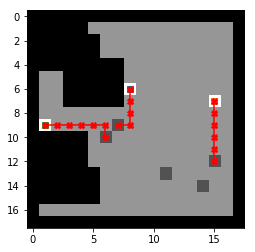

[6, 8]->[7, 8]->[8, 8]->[9, 8]->[9, 7]->End
[7, 15]->[8, 15]->[9, 15]->[10, 15]->[11, 15]->[12, 15]->End
[9, 1]->[9, 2]->[9, 3]->[9, 4]->[9, 5]->[9, 6]->[10, 6]->End


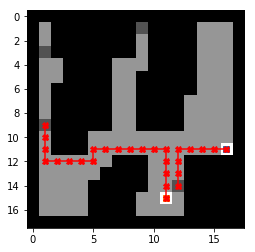

[11, 16]->[11, 15]->[11, 14]->[11, 13]->[11, 12]->[12, 12]->[13, 12]->[14, 12]->End
[15, 11]->[14, 11]->[13, 11]->[12, 11]->[11, 11]->[11, 10]->[11, 9]->[11, 8]->[11, 7]->[11, 6]->[11, 5]->[12, 5]->[12, 4]->[12, 3]->[12, 2]->[12, 1]->[11, 1]->[10, 1]->[9, 1]->End


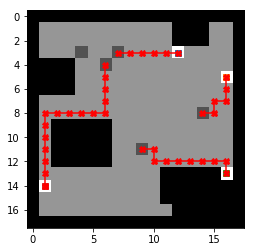

[3, 12]->[3, 11]->[3, 10]->[3, 9]->[3, 8]->[3, 7]->End
[5, 16]->[6, 16]->[7, 16]->[7, 15]->[8, 15]->[8, 14]->End
[13, 16]->[12, 16]->[12, 15]->[12, 14]->[12, 13]->[12, 12]->[12, 11]->[12, 10]->[11, 10]->[11, 9]->End
[14, 1]->[13, 1]->[12, 1]->[11, 1]->[10, 1]->[9, 1]->[8, 1]->[8, 2]->[8, 3]->[8, 4]->[8, 5]->[8, 6]->[7, 6]->[6, 6]->[5, 6]->[4, 6]->End


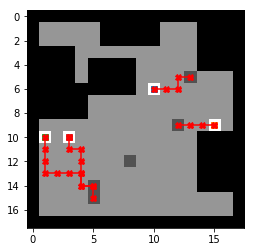

[6, 10]->[6, 11]->[6, 12]->[5, 12]->[5, 13]->End
[9, 15]->[9, 14]->[9, 13]->[9, 12]->End
[10, 1]->[11, 1]->[12, 1]->[13, 1]->[13, 2]->[13, 3]->[13, 4]->[14, 4]->[14, 5]->End
[10, 3]->[11, 3]->[11, 4]->[12, 4]->[13, 4]->[14, 4]->[14, 5]->[15, 5]->End


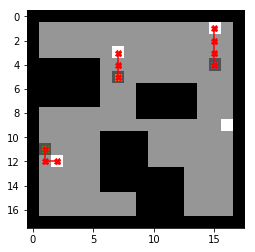

[1, 15]->[2, 15]->[3, 15]->[4, 15]->End
[3, 7]->[4, 7]->[5, 7]->End
[12, 2]->[12, 1]->[11, 1]->End


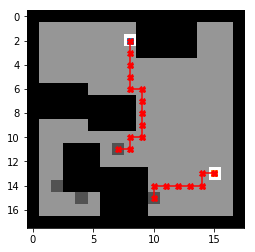

[2, 8]->[3, 8]->[4, 8]->[5, 8]->[6, 8]->[6, 9]->[7, 9]->[8, 9]->[9, 9]->[10, 9]->[10, 8]->[11, 8]->[11, 7]->End
[13, 15]->[13, 14]->[14, 14]->[14, 13]->[14, 12]->[14, 11]->[14, 10]->[15, 10]->End


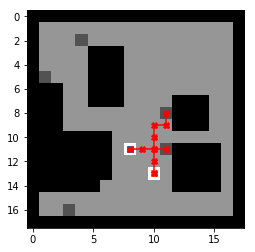

[11, 8]->[11, 9]->[11, 10]->[11, 11]->End
[13, 10]->[12, 10]->[11, 10]->[10, 10]->[9, 10]->[9, 11]->[8, 11]->End


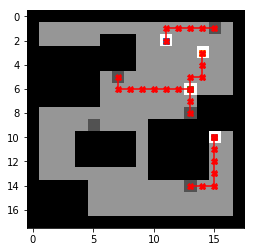

[2, 11]->[1, 11]->[1, 12]->[1, 13]->[1, 14]->[1, 15]->End
[3, 14]->[4, 14]->[5, 14]->[5, 13]->[6, 13]->[7, 13]->[8, 13]->End
[6, 13]->[6, 12]->[6, 11]->[6, 10]->[6, 9]->[6, 8]->[6, 7]->[5, 7]->End
[10, 15]->[11, 15]->[12, 15]->[13, 15]->[14, 15]->[14, 14]->[14, 13]->End


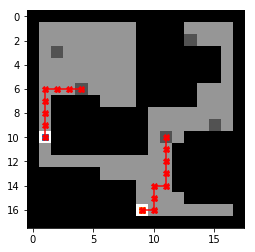

[10, 1]->[9, 1]->[8, 1]->[7, 1]->[6, 1]->[6, 2]->[6, 3]->[6, 4]->End
[16, 9]->[16, 10]->[15, 10]->[14, 10]->[14, 11]->[13, 11]->[12, 11]->[11, 11]->[10, 11]->End


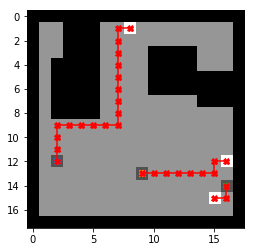

[1, 8]->[1, 7]->[2, 7]->[3, 7]->[4, 7]->[5, 7]->[6, 7]->[7, 7]->[8, 7]->[9, 7]->[9, 6]->[9, 5]->[9, 4]->[9, 3]->[9, 2]->[10, 2]->[11, 2]->[12, 2]->End
[12, 16]->[12, 15]->[13, 15]->[13, 14]->[13, 13]->[13, 12]->[13, 11]->[13, 10]->[13, 9]->End
[15, 15]->[15, 16]->[14, 16]->End


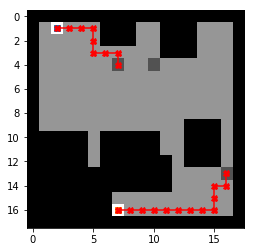

[1, 2]->[1, 3]->[1, 4]->[1, 5]->[2, 5]->[3, 5]->[3, 6]->[3, 7]->[4, 7]->End
[16, 7]->[16, 8]->[16, 9]->[16, 10]->[16, 11]->[16, 12]->[16, 13]->[16, 14]->[16, 15]->[15, 15]->[14, 15]->[14, 16]->[13, 16]->End
Goal_accuray: 1.0
133.0 133.0
Average_Step_error_in_each_domain : 10.428571428571429
511.0 49.0


In [110]:
correct, traj_step, total,total_env = 0.0,0.0,0.0,0.0

X,S,label = test_data[0].copy()

prev_env = X.clone()

whole_traj_act = []

Trajectory = [S]
Action  = [label]

go = np.where(X[1] == 1.0) 
goal = np.column_stack([go[0],go[1]])

end = len(test_data)


for i in range(1,end):
    X,S,label = test_data[i].copy()
    
    new_env = X.clone()
    
   
    if (new_env[0] - prev_env[0]).sum() == 0.0:

        if label != 4:
            Trajectory.append(S)
            Action.append(label)
        else:
            Trajectory.append(S)
            Action.append(label)
            whole_traj_act.append([Trajectory,Action])
            Trajectory = []
            Action = []
    else :
        #call the function with prev_new and whole traj act
        total_env += 1
        #correct_goal,total_goal, traj_length,traj = agent_prediction(model_16x16,prev_env.clone(),whole_traj_act,goal,18,0)
        correct_goal,total_goal, traj_length,traj,change = cooperative(model=model_16x16,X=prev_env.clone(),imsize=18)
        
        dom = prev_env[0] - 0.5 * prev_env[1] + prev_env[2]
        visualization(dom,traj)
        
        if change == 1:
            for i in traj:
                L = len(i[0])
                for j in range(L-1,-1,-1):
                    print([i[0][j][0].item(),i[0][j][1].item()],end='->')
                print("End")
        else :
            for i in traj:
                for j in i[0]:
                   print([j[0].item(),j[1].item()],end='->')
                print("End")
        
        total += total_goal
        correct += correct_goal
        traj_step += traj_length
        
        prev_env = new_env.clone()
        
        
        whole_traj_act = []
        go = np.where(prev_env[1] == 1.0) 
        goal = np.column_stack([go[0],go[1]])
        
        
print(f'Goal_accuray: {correct /total}')
print(correct,total)
print(f'Average_Step_error_in_each_domain : {traj_step/total_env}')
print(traj_step,total_env)

In [44]:
for i in traj:
  print([i[0][0][0].item(),i[0][0][1].item()])
  for j in i[0]:
    print([j[0].item(),j[1].item()],end='->')
  print("End")

[1, 2]
[1, 2]->[1, 3]->[1, 4]->[1, 5]->[2, 5]->[3, 5]->[3, 6]->[3, 7]->[4, 7]->End
[16, 7]
[16, 7]->[16, 8]->[16, 9]->[16, 10]->[16, 11]->[16, 12]->[16, 13]->[16, 14]->[16, 15]->[15, 15]->[14, 15]->[14, 16]->[13, 16]->End


In [0]:
test = []
with np.load('Env_28x28.npz', mmap_mode='r') as f:
    test = f['arr_0']

In [0]:
test_data = []

for i in test:
    env = -1 *(i[0] == 0) + 1.0
    goal = (i[0] == 0.5) + 0.0
    Agent = i[1]
    domain = np.array([env,goal,Agent])
    
    test_data.append([torch.tensor(domain.copy())])
    

In [113]:
model_28x28 = MA_P(36,32)
model_28x28.load_state_dict(torch.load('MA_P_2_9_2.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [114]:
model_28x28.cuda()

MA_P(
  (h): Conv2d(3, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (r): Conv2d(150, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (q): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (sm): Softmax()
)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "CPU")

In [0]:
correct,total,traj_step = 0.0,0.0,0.0   
imsize = 32
max_rand_play= 0
memory = []
for i in range(50):
    if  i == 44:
      continue
    
    X = test_data[i][0].clone()
    
    Y = torch.zeros([3,32,32])
    
    Y[:,2:30,2:30] = X.clone()
    
    go = np.where(Y[1] == 1.0)
    goal = np.column_stack([go[0],go[1]])
    
  
        
    #current_goal,current_total,traj,memory = agent_predict(model_28x28,Y.clone(),goal,imsize,max_rand_play)
    correct_goal,total_goal, traj_length,traj = agent_prediction(model_28x28,Y.clone(),[],goal,imsize,0)
   # correct_goal,total_goal, traj_length,traj = cooperative(model=model_28x28,X=Y.clone(),imsize=imsize)
    
   # for j in traj:
   #   for k in j:
    #     print(k,end="->")
     # print("End")
      
   # print(i,correct_goal,total_goal)
    
    correct += correct_goal
    total += total_goal
    traj_step += traj_length
    
print(f'Goal Accuracy: {correct/total}')
print(correct,total)
print(f'Average traj step length : {traj_step/50}')
print(traj_step,50)

Goal Accuracy: 0.7935779816513762
173.0 218.0
Average traj step length : 19.18
959.0 50


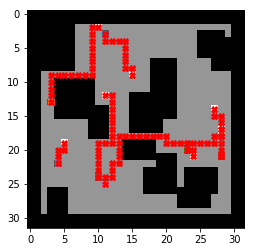

[9, 15]->[8, 15]->[8, 14]->[7, 14]->[6, 14]->[5, 14]->[4, 14]->[4, 13]->[4, 12]->[4, 11]->[3, 11]->End
[2, 10]->[2, 9]->[3, 9]->[4, 9]->[5, 9]->[6, 9]->[7, 9]->[8, 9]->[9, 9]->[9, 8]->[9, 7]->[9, 6]->[9, 5]->[9, 4]->[9, 3]->[10, 3]->[11, 3]->[12, 3]->[13, 3]->End
[17, 28]->[18, 28]->[18, 27]->[19, 27]->[19, 26]->[19, 25]->[19, 24]->[19, 23]->[20, 23]->End
[14, 27]->[15, 27]->[15, 28]->[16, 28]->[17, 28]->[18, 28]->[19, 28]->[20, 28]->[21, 28]->End
[19, 5]->[20, 5]->[20, 4]->[21, 4]->[22, 4]->End
[12, 11]->[12, 12]->[13, 12]->[14, 12]->[15, 12]->[16, 12]->[17, 12]->[18, 12]->[19, 12]->[19, 11]->[19, 10]->[20, 10]->[21, 10]->[22, 10]->[23, 10]->[24, 10]->End
[21, 24]->[20, 24]->[20, 23]->[19, 23]->[19, 22]->[19, 21]->[19, 20]->[18, 20]->[18, 19]->[18, 18]->[18, 17]->[18, 16]->[18, 15]->[18, 14]->[18, 13]->[19, 13]->[20, 13]->[21, 13]->[22, 13]->[22, 12]->[23, 12]->[24, 12]->[24, 11]->[25, 11]->End


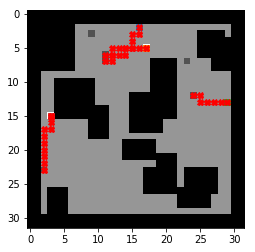

[2, 16]->[3, 16]->[3, 15]->[4, 15]->[5, 15]->[5, 14]->[5, 13]->[5, 12]->[6, 12]->[6, 11]->End
[5, 17]->[5, 16]->[5, 15]->[5, 14]->[6, 14]->[6, 13]->[6, 12]->[7, 12]->[7, 11]->End
[13, 29]->[13, 28]->[13, 27]->[13, 26]->[13, 25]->[12, 25]->[12, 24]->End
[15, 3]->[16, 3]->[17, 3]->[17, 2]->[18, 2]->[19, 2]->[20, 2]->[21, 2]->[22, 2]->[23, 2]->End


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


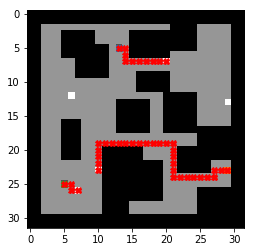

[7, 20]->[7, 19]->[7, 18]->[7, 17]->[7, 16]->[7, 15]->[7, 14]->[6, 14]->[5, 14]->[5, 13]->End
[23, 10]->[22, 10]->[21, 10]->[20, 10]->[19, 10]->[19, 11]->[19, 12]->[19, 13]->[19, 14]->[19, 15]->[19, 16]->[19, 17]->[19, 18]->[19, 19]->[19, 20]->[19, 21]->[20, 21]->[21, 21]->[22, 21]->[23, 21]->[24, 21]->[24, 22]->[24, 23]->[24, 24]->[24, 25]->[24, 26]->[24, 27]->[23, 27]->[23, 28]->[23, 29]->End
[26, 7]->[26, 6]->[25, 6]->[25, 5]->End


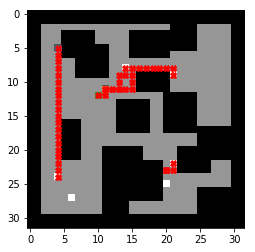

[24, 4]->[23, 4]->[22, 4]->[21, 4]->[20, 4]->[19, 4]->[18, 4]->[17, 4]->[16, 4]->[15, 4]->[14, 4]->[13, 4]->[12, 4]->[11, 4]->[10, 4]->[9, 4]->[8, 4]->[7, 4]->[6, 4]->[5, 4]->End
[9, 21]->[8, 21]->[8, 20]->[8, 19]->[8, 18]->[8, 17]->[8, 16]->[8, 15]->[9, 15]->[10, 15]->[11, 15]->[11, 14]->[11, 13]->[11, 12]->[11, 11]->End
[8, 14]->[9, 14]->[9, 13]->[10, 13]->[11, 13]->[11, 12]->[11, 11]->[12, 11]->[12, 10]->End
[22, 21]->[23, 21]->[23, 20]->End


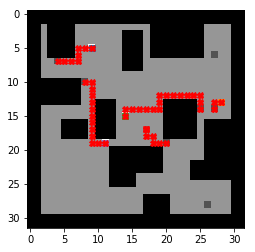

[5, 9]->[5, 8]->[5, 7]->[6, 7]->[7, 7]->[7, 6]->[7, 5]->[7, 4]->End
[13, 28]->[13, 27]->[14, 27]->End
[15, 14]->[14, 14]->[14, 15]->[14, 16]->[14, 17]->[14, 18]->[14, 19]->[13, 19]->[12, 19]->[12, 20]->[12, 21]->[12, 22]->[12, 23]->[12, 24]->[12, 25]->[13, 25]->[14, 25]->End
[17, 17]->[18, 17]->[18, 18]->[19, 18]->[19, 19]->[19, 20]->End
[19, 11]->[19, 10]->[19, 9]->[18, 9]->[17, 9]->[16, 9]->[15, 9]->[14, 9]->[13, 9]->[12, 9]->[11, 9]->[10, 9]->[10, 8]->End


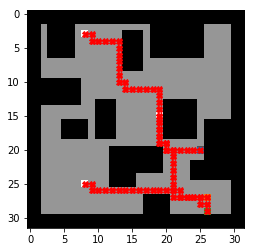

[15, 19]->[16, 19]->[17, 19]->[18, 19]->[19, 19]->[19, 20]->[20, 20]->[20, 21]->[20, 22]->[20, 23]->[20, 24]->[20, 25]->End
[3, 8]->[3, 9]->[4, 9]->[4, 10]->[4, 11]->[4, 12]->[4, 13]->[5, 13]->[6, 13]->[7, 13]->[8, 13]->[9, 13]->[10, 13]->[10, 14]->[11, 14]->[11, 15]->[11, 16]->[11, 17]->[11, 18]->[11, 19]->[12, 19]->[13, 19]->[14, 19]->[15, 19]->[16, 19]->[17, 19]->[18, 19]->[19, 19]->[19, 20]->[20, 20]->[20, 21]->[21, 21]->[22, 21]->[23, 21]->[24, 21]->[25, 21]->[26, 21]->[27, 21]->[27, 22]->[27, 23]->[27, 24]->[27, 25]->[27, 26]->End
[25, 8]->[25, 9]->[26, 9]->[26, 10]->[26, 11]->[26, 12]->[26, 13]->[26, 14]->[26, 15]->[26, 16]->[26, 17]->[26, 18]->[26, 19]->[26, 20]->[26, 21]->[26, 22]->[27, 22]->[27, 23]->[27, 24]->[27, 25]->[28, 25]->[28, 26]->[29, 26]->End


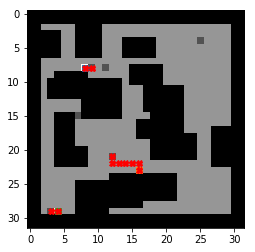

[8, 8]->[8, 9]->End
[23, 16]->[22, 16]->[22, 15]->[22, 14]->[22, 13]->[22, 12]->[21, 12]->End
[29, 4]->[29, 3]->End


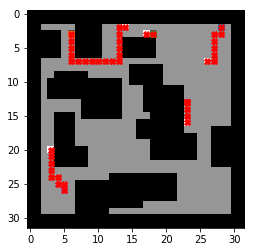

[7, 26]->[7, 27]->[6, 27]->[5, 27]->[4, 27]->[3, 27]->[3, 28]->[2, 28]->End
[2, 14]->[2, 13]->[3, 13]->[4, 13]->[5, 13]->[6, 13]->[7, 13]->[7, 12]->[7, 11]->[7, 10]->[7, 9]->[7, 8]->[7, 7]->[7, 6]->[6, 6]->[5, 6]->[4, 6]->[3, 6]->End
[3, 17]->[3, 18]->End
[16, 23]->[15, 23]->[14, 23]->[13, 23]->End
[20, 3]->[21, 3]->[22, 3]->[23, 3]->[24, 3]->[24, 4]->[25, 4]->[25, 5]->[26, 5]->End


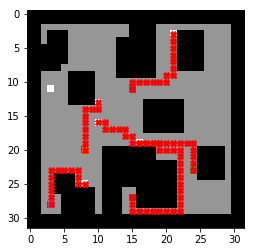

[3, 21]->[4, 21]->[5, 21]->[6, 21]->[7, 21]->[8, 21]->[9, 21]->[9, 20]->[10, 20]->[10, 19]->[10, 18]->[10, 17]->[10, 16]->[10, 15]->[11, 15]->End
[13, 10]->[14, 10]->[14, 9]->[14, 8]->[15, 8]->[16, 8]->[17, 8]->[18, 8]->[19, 8]->[20, 8]->End
[16, 10]->[16, 11]->[17, 11]->[17, 12]->[17, 13]->[17, 14]->[18, 14]->[18, 15]->[19, 15]->[19, 16]->[19, 17]->[19, 18]->[19, 19]->[19, 20]->[19, 21]->[19, 22]->[19, 23]->[19, 24]->[20, 24]->[21, 24]->[22, 24]->[23, 24]->End
[19, 16]->[19, 17]->[19, 18]->[19, 19]->[20, 19]->[20, 20]->[20, 21]->[20, 22]->[21, 22]->[22, 22]->[23, 22]->[24, 22]->[25, 22]->[26, 22]->[27, 22]->[28, 22]->[29, 22]->[29, 21]->[29, 20]->[29, 19]->[29, 18]->[29, 17]->[29, 16]->[29, 15]->[28, 15]->[27, 15]->End
[25, 8]->[25, 7]->[24, 7]->[23, 7]->[23, 6]->[23, 5]->[23, 4]->[23, 3]->[24, 3]->[25, 3]->[26, 3]->[27, 3]->[28, 3]->End


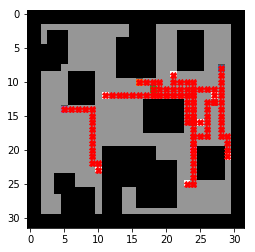

[21, 29]->[20, 29]->[19, 29]->[18, 29]->[18, 28]->[17, 28]->[16, 28]->[15, 28]->[14, 28]->[13, 28]->[12, 28]->[11, 28]->[10, 28]->[9, 28]->[8, 28]->End
[12, 27]->[11, 27]->[11, 26]->[11, 25]->[11, 24]->[11, 23]->[11, 22]->[11, 21]->[11, 20]->[11, 19]->[10, 19]->[10, 18]->[10, 17]->[10, 16]->End
[16, 25]->[16, 24]->[16, 23]->[15, 23]->[14, 23]->[13, 23]->[12, 23]->[12, 22]->[12, 21]->[12, 20]->[12, 19]->[12, 18]->[11, 18]->End
[25, 23]->[25, 24]->[24, 24]->[23, 24]->[22, 24]->[21, 24]->[20, 24]->[19, 24]->[18, 24]->[18, 25]->[18, 26]->[17, 26]->[16, 26]->[15, 26]->[14, 26]->[13, 26]->[13, 27]->End
[23, 10]->[22, 10]->[22, 9]->[21, 9]->[20, 9]->[19, 9]->[18, 9]->[17, 9]->[16, 9]->[15, 9]->[14, 9]->[14, 8]->[14, 7]->[14, 6]->[14, 5]->End
[12, 11]->[12, 12]->[12, 13]->[12, 14]->[12, 15]->[12, 16]->[12, 17]->[12, 18]->[12, 19]->[12, 20]->[12, 21]->[12, 22]->[12, 23]->[12, 24]->[13, 24]->[14, 24]->[15, 24]->[16, 24]->End
[9, 21]->[10, 21]->[10, 22]->[10, 23]->[10, 24]->[11, 24]->[12, 24]->[1

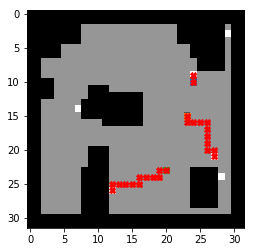

[9, 24]->[10, 24]->End
[21, 27]->[20, 27]->[20, 26]->[19, 26]->[18, 26]->[17, 26]->[16, 26]->[16, 25]->[16, 24]->[16, 23]->[15, 23]->End
[26, 12]->[25, 12]->[25, 13]->[25, 14]->[25, 15]->[25, 16]->[24, 16]->[24, 17]->[24, 18]->[24, 19]->[23, 19]->[23, 20]->End


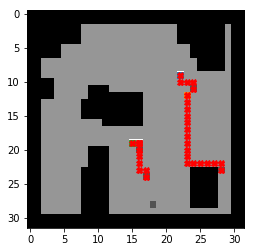

[9, 22]->[10, 22]->[10, 23]->[10, 24]->[11, 24]->End
[12, 23]->[13, 23]->[14, 23]->[15, 23]->[16, 23]->[17, 23]->[18, 23]->[19, 23]->[20, 23]->[21, 23]->[22, 23]->[22, 24]->[22, 25]->[22, 26]->[22, 27]->[22, 28]->[23, 28]->End
[19, 15]->[19, 16]->[20, 16]->End
[19, 16]->[20, 16]->[21, 16]->[22, 16]->[23, 16]->[23, 17]->[24, 17]->End


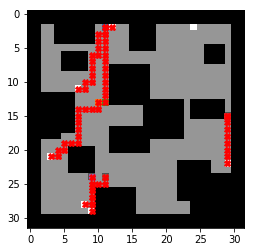

[11, 7]->[11, 8]->[10, 8]->[10, 9]->[9, 9]->[8, 9]->[7, 9]->[6, 9]->[6, 10]->[5, 10]->[4, 10]->[3, 10]->[3, 11]->[2, 11]->End
[21, 3]->[21, 4]->[20, 4]->[20, 5]->[19, 5]->[19, 6]->[19, 7]->[18, 7]->[17, 7]->[16, 7]->[15, 7]->[14, 7]->[14, 8]->[14, 9]->[14, 10]->[13, 10]->End
[2, 12]->[2, 11]->[3, 11]->[4, 11]->[5, 11]->[6, 11]->[7, 11]->[8, 11]->[9, 11]->[10, 11]->[11, 11]->[12, 11]->[13, 11]->End
[22, 29]->[21, 29]->[20, 29]->[19, 29]->[18, 29]->[17, 29]->[16, 29]->[15, 29]->End
[28, 8]->[28, 9]->[27, 9]->[26, 9]->[25, 9]->[24, 9]->End
[29, 9]->[28, 9]->[27, 9]->[26, 9]->[25, 9]->[25, 10]->[25, 11]->[24, 11]->End


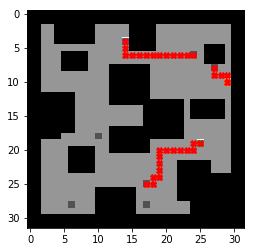

[4, 14]->[5, 14]->[6, 14]->[6, 15]->[6, 16]->[6, 17]->[6, 18]->[6, 19]->[6, 20]->[6, 21]->[6, 22]->[6, 23]->[6, 24]->End
[10, 29]->[9, 29]->[9, 28]->[9, 27]->[8, 27]->End
[19, 25]->[19, 24]->[20, 24]->[20, 23]->[20, 22]->[20, 21]->[20, 20]->[20, 19]->[21, 19]->[22, 19]->[23, 19]->[24, 19]->[24, 18]->[25, 18]->[25, 17]->End


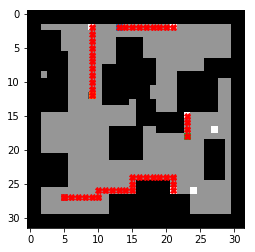

[2, 21]->[2, 20]->[2, 19]->[2, 18]->[2, 17]->[2, 16]->[2, 15]->[2, 14]->[2, 13]->End
[2, 9]->[3, 9]->[4, 9]->[5, 9]->[6, 9]->[7, 9]->[8, 9]->[9, 9]->[10, 9]->[11, 9]->[12, 9]->End
[15, 23]->[16, 23]->[17, 23]->[18, 23]->End
[26, 21]->[25, 21]->[24, 21]->[24, 20]->[24, 19]->[24, 18]->[24, 17]->[24, 16]->[24, 15]->[25, 15]->[26, 15]->[26, 14]->[26, 13]->[26, 12]->[26, 11]->[26, 10]->[27, 10]->[27, 9]->[27, 8]->[27, 7]->[27, 6]->[27, 5]->End


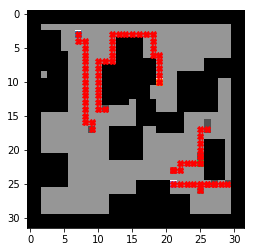

[3, 7]->[4, 7]->[4, 8]->[5, 8]->[6, 8]->[7, 8]->[8, 8]->[9, 8]->[10, 8]->[11, 8]->[12, 8]->[13, 8]->[14, 8]->[15, 8]->[16, 8]->[16, 9]->[17, 9]->End
[10, 19]->[9, 19]->[8, 19]->[7, 19]->[6, 19]->[6, 18]->[5, 18]->[4, 18]->[3, 18]->[3, 17]->[3, 16]->[3, 15]->[3, 14]->[3, 13]->[3, 12]->[4, 12]->[5, 12]->[6, 12]->[7, 12]->[7, 11]->[7, 10]->[8, 10]->[9, 10]->[10, 10]->[11, 10]->[12, 10]->[13, 10]->[14, 10]->[14, 11]->End
[22, 25]->[21, 25]->[20, 25]->[19, 25]->[18, 25]->[17, 25]->[17, 26]->End
[23, 21]->[23, 22]->[22, 22]->[22, 23]->[22, 24]->[22, 25]->[21, 25]->End
[25, 21]->[25, 22]->[25, 23]->[25, 24]->[25, 25]->[25, 26]->[25, 27]->End
[26, 25]->[25, 25]->[25, 26]->[25, 27]->[25, 28]->[25, 29]->End


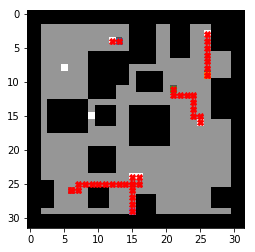

[4, 12]->[4, 13]->End
[3, 26]->[4, 26]->[5, 26]->[6, 26]->[7, 26]->[8, 26]->[9, 26]->End
[16, 25]->[15, 25]->[15, 24]->[14, 24]->[13, 24]->[12, 24]->[12, 23]->[12, 22]->[12, 21]->[11, 21]->End
[24, 15]->[25, 15]->[25, 14]->[25, 13]->[25, 12]->[25, 11]->[25, 10]->[25, 9]->[25, 8]->[25, 7]->[26, 7]->[26, 6]->End
[24, 16]->[25, 16]->[25, 15]->[26, 15]->[27, 15]->[28, 15]->[29, 15]->End


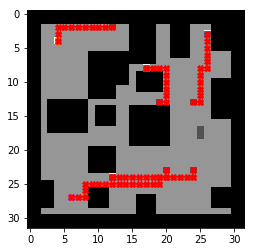

[3, 26]->[4, 26]->[5, 26]->[6, 26]->[7, 26]->[8, 26]->[8, 25]->[9, 25]->[10, 25]->[11, 25]->[12, 25]->[13, 25]->[13, 24]->End
[4, 4]->[3, 4]->[2, 4]->[2, 5]->[2, 6]->[2, 7]->[2, 8]->[2, 9]->[2, 10]->[2, 11]->[2, 12]->End
[8, 17]->[8, 18]->[8, 19]->[8, 20]->[9, 20]->[10, 20]->[11, 20]->[12, 20]->[13, 20]->[13, 19]->End
[24, 12]->[24, 13]->[24, 14]->[24, 15]->[24, 16]->[24, 17]->[24, 18]->[24, 19]->[24, 20]->[24, 21]->[24, 22]->[24, 23]->[24, 24]->[23, 24]->End
[27, 6]->[27, 7]->[27, 8]->[26, 8]->[25, 8]->[25, 9]->[25, 10]->[25, 11]->[25, 12]->[25, 13]->[25, 14]->[25, 15]->[25, 16]->[25, 17]->[25, 18]->[25, 19]->[24, 19]->[24, 20]->[23, 20]->End


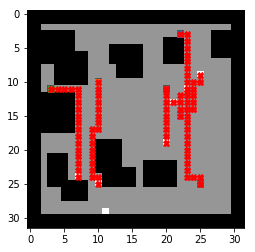

[13, 21]->[13, 22]->[12, 22]->[12, 23]->[11, 23]->[10, 23]->[9, 23]->[8, 23]->[7, 23]->[6, 23]->[5, 23]->[4, 23]->[3, 23]->[3, 22]->End
[25, 10]->[24, 10]->[24, 9]->[23, 9]->[22, 9]->[21, 9]->[20, 9]->[19, 9]->[18, 9]->[17, 9]->[17, 10]->[16, 10]->[15, 10]->[14, 10]->[13, 10]->[12, 10]->[11, 10]->[10, 10]->End
[24, 7]->[23, 7]->[22, 7]->[21, 7]->[20, 7]->[19, 7]->[18, 7]->[17, 7]->[16, 7]->[15, 7]->[14, 7]->[13, 7]->[12, 7]->[11, 7]->[11, 6]->[11, 5]->[11, 4]->[11, 3]->End
[19, 20]->[18, 20]->[17, 20]->[16, 20]->[15, 20]->[14, 20]->[13, 20]->[12, 20]->[11, 20]->End
[9, 25]->[10, 25]->[10, 24]->[11, 24]->[12, 24]->[13, 24]->[14, 24]->[14, 23]->[14, 22]->[15, 22]->End
[11, 23]->[12, 23]->[13, 23]->[14, 23]->[15, 23]->[16, 23]->[17, 23]->[18, 23]->[19, 23]->[20, 23]->[21, 23]->[22, 23]->[23, 23]->[24, 23]->[24, 24]->[24, 25]->[25, 25]->End


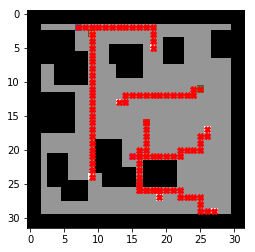

[5, 18]->[4, 18]->[3, 18]->[2, 18]->[2, 17]->[2, 16]->[2, 15]->[2, 14]->[2, 13]->[2, 12]->[2, 11]->[2, 10]->[2, 9]->[2, 8]->[2, 7]->End
[24, 9]->[23, 9]->[22, 9]->[21, 9]->[20, 9]->[19, 9]->[18, 9]->[17, 9]->[16, 9]->[15, 9]->[14, 9]->[13, 9]->[12, 9]->[11, 9]->[10, 9]->[9, 9]->[8, 9]->[7, 9]->[6, 9]->[5, 9]->[4, 9]->[3, 9]->End
[13, 13]->[13, 14]->[12, 14]->[12, 15]->[12, 16]->[12, 17]->[12, 18]->[12, 19]->[12, 20]->[12, 21]->[12, 22]->[12, 23]->[12, 24]->[11, 24]->[11, 25]->End
[27, 19]->[26, 19]->[26, 18]->[26, 17]->[26, 16]->[25, 16]->[24, 16]->[23, 16]->[22, 16]->[21, 16]->[20, 16]->[20, 17]->[19, 17]->[18, 17]->[17, 17]->[16, 17]->End
[17, 26]->[18, 26]->[18, 25]->[19, 25]->[20, 25]->[20, 24]->[20, 23]->[20, 22]->[21, 22]->[21, 21]->[21, 20]->[21, 19]->[21, 18]->[21, 17]->[21, 16]->[21, 15]->End
[29, 27]->[29, 26]->[29, 25]->[28, 25]->[27, 25]->[27, 24]->[27, 23]->[27, 22]->[26, 22]->[26, 21]->[26, 20]->[26, 19]->[26, 18]->[26, 17]->[26, 16]->[25, 16]->End


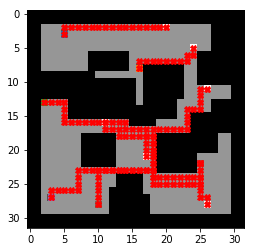

[2, 20]->[2, 19]->[2, 18]->[2, 17]->[2, 16]->[2, 15]->[2, 14]->[2, 13]->[2, 12]->[2, 11]->[2, 10]->[2, 9]->[2, 8]->[2, 7]->[2, 6]->[2, 5]->[3, 5]->End
[5, 24]->[6, 24]->[6, 23]->[7, 23]->[7, 22]->[7, 21]->[7, 20]->[7, 19]->[7, 18]->[7, 17]->[7, 16]->[8, 16]->End
[21, 17]->[20, 17]->[19, 17]->[18, 17]->[17, 17]->[17, 16]->[17, 15]->[17, 14]->[16, 14]->[16, 13]->[16, 12]->[16, 11]->[16, 10]->[16, 9]->[16, 8]->[16, 7]->[16, 6]->[16, 5]->[15, 5]->[14, 5]->[13, 5]->[13, 4]->[13, 3]->[13, 2]->End
[16, 11]->[17, 11]->[17, 12]->[17, 13]->[18, 13]->[18, 14]->[18, 15]->[18, 16]->[18, 17]->[18, 18]->[19, 18]->[20, 18]->[21, 18]->[22, 18]->[23, 18]->[24, 18]->[25, 18]->[25, 19]->[25, 20]->[25, 21]->[25, 22]->[25, 23]->[25, 24]->[25, 25]->[24, 25]->[23, 25]->[22, 25]->End
[28, 26]->[27, 26]->[27, 25]->[26, 25]->[25, 25]->[24, 25]->[24, 24]->[24, 23]->[24, 22]->[24, 21]->[24, 20]->[24, 19]->[24, 18]->[23, 18]->[23, 17]->[23, 16]->[23, 15]->[23, 14]->[23, 13]->[23, 12]->[23, 11]->[23, 10]->[23, 9]->[

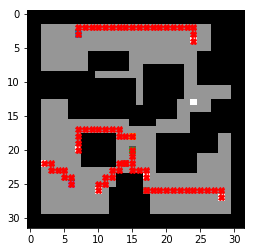

[4, 24]->[3, 24]->[2, 24]->[2, 23]->[2, 22]->[2, 21]->[2, 20]->[2, 19]->[2, 18]->[2, 17]->[2, 16]->[2, 15]->[2, 14]->[2, 13]->[2, 12]->[2, 11]->[2, 10]->[2, 9]->[2, 8]->[2, 7]->[3, 7]->End
[20, 7]->[19, 7]->[18, 7]->[17, 7]->[17, 8]->[17, 9]->[17, 10]->[17, 11]->[17, 12]->[17, 13]->[18, 13]->[18, 14]->[18, 15]->End
[24, 17]->[23, 17]->[23, 16]->[23, 15]->[22, 15]->[21, 15]->[20, 15]->End
[26, 10]->[25, 10]->[25, 11]->[24, 11]->[24, 12]->[23, 12]->[23, 13]->[22, 13]->[22, 14]->End
[22, 2]->[22, 3]->[23, 3]->[23, 4]->[23, 5]->[24, 5]->[24, 6]->[25, 6]->End
[27, 28]->[26, 28]->[26, 27]->[26, 26]->[26, 25]->[26, 24]->[26, 23]->[26, 22]->[26, 21]->[26, 20]->[26, 19]->[26, 18]->[26, 17]->End


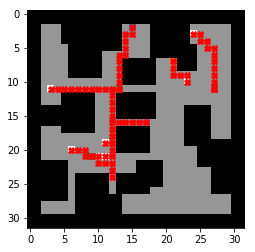

[19, 11]->[19, 12]->[18, 12]->[17, 12]->[16, 12]->[15, 12]->[14, 12]->[13, 12]->[12, 12]->[11, 12]->[11, 13]->[10, 13]->[9, 13]->[8, 13]->[7, 13]->[6, 13]->[6, 14]->[5, 14]->[4, 14]->[3, 14]->[3, 15]->[2, 15]->End
[10, 23]->[9, 23]->[9, 22]->[9, 21]->[8, 21]->[7, 21]->End
[11, 3]->[11, 4]->[11, 5]->[11, 6]->[11, 7]->[11, 8]->[11, 9]->[11, 10]->[11, 11]->[11, 12]->[11, 13]->End
[3, 24]->[3, 25]->[4, 25]->[4, 26]->[5, 26]->[5, 27]->[6, 27]->[7, 27]->[8, 27]->[9, 27]->[10, 27]->[11, 27]->End
[21, 11]->[21, 12]->[20, 12]->[19, 12]->[18, 12]->[17, 12]->[16, 12]->[16, 13]->[16, 14]->[16, 15]->[16, 16]->[16, 17]->End
[20, 6]->[20, 7]->[20, 8]->[21, 8]->[21, 9]->End
[21, 10]->[22, 10]->[22, 11]->[22, 12]->[23, 12]->[24, 12]->End


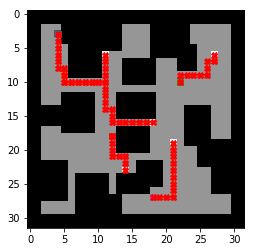

[6, 11]->[7, 11]->[8, 11]->[9, 11]->[10, 11]->[10, 10]->[10, 9]->[10, 8]->[10, 7]->[10, 6]->[10, 5]->[9, 5]->[8, 5]->[8, 4]->[7, 4]->[6, 4]->[5, 4]->[4, 4]->[3, 4]->End
[16, 18]->[16, 17]->[16, 16]->[16, 15]->[16, 14]->[16, 13]->[16, 12]->[15, 12]->[14, 12]->[14, 11]->[13, 11]->[12, 11]->[11, 11]->[10, 11]->[10, 10]->[10, 9]->[10, 8]->[10, 7]->[10, 6]->[10, 5]->[9, 5]->End
[6, 27]->[7, 27]->[7, 26]->[8, 26]->[9, 26]->[9, 25]->[9, 24]->[9, 23]->[9, 22]->[10, 22]->End
[23, 14]->[22, 14]->[21, 14]->[21, 13]->[21, 12]->[20, 12]->[19, 12]->[18, 12]->End
[19, 21]->[20, 21]->[21, 21]->[22, 21]->[23, 21]->[24, 21]->[25, 21]->[26, 21]->[27, 21]->[27, 20]->[27, 19]->[27, 18]->End


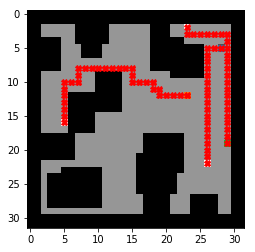

[22, 26]->[21, 26]->[20, 26]->[19, 26]->[18, 26]->[17, 26]->[16, 26]->[15, 26]->[14, 26]->[13, 26]->[12, 26]->[11, 26]->[10, 26]->[9, 26]->[8, 26]->[7, 26]->[6, 26]->[5, 26]->[5, 27]->[5, 28]->End
[16, 5]->[15, 5]->[14, 5]->[13, 5]->[12, 5]->[11, 5]->[10, 5]->[10, 6]->[10, 7]->[9, 7]->[8, 7]->[8, 8]->[8, 9]->[8, 10]->[8, 11]->[8, 12]->[8, 13]->[8, 14]->[8, 15]->[9, 15]->[10, 15]->[10, 16]->[10, 17]->[10, 18]->[11, 18]->[11, 19]->[12, 19]->[12, 20]->[12, 21]->[12, 22]->[12, 23]->End
[2, 23]->[3, 23]->[3, 24]->[3, 25]->[3, 26]->[3, 27]->[3, 28]->[3, 29]->[4, 29]->[5, 29]->[6, 29]->[7, 29]->[8, 29]->[9, 29]->[10, 29]->[11, 29]->[12, 29]->[13, 29]->[14, 29]->[15, 29]->[16, 29]->[17, 29]->[18, 29]->[19, 29]->End


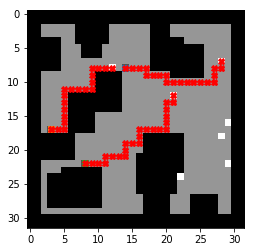

[7, 28]->[8, 28]->[8, 27]->[9, 27]->[10, 27]->[10, 26]->[10, 25]->[10, 24]->[10, 23]->[10, 22]->[10, 21]->[10, 20]->[9, 20]->[9, 19]->[9, 18]->[9, 17]->[8, 17]->[8, 16]->[8, 15]->[8, 14]->End
[8, 12]->[8, 11]->[8, 10]->[8, 9]->[9, 9]->[10, 9]->[11, 9]->[11, 8]->[11, 7]->[11, 6]->[11, 5]->[12, 5]->[13, 5]->[14, 5]->[15, 5]->[16, 5]->[17, 5]->[17, 4]->[17, 3]->End
[12, 21]->[13, 21]->[13, 20]->[14, 20]->[15, 20]->[16, 20]->[17, 20]->[17, 19]->[17, 18]->[17, 17]->[17, 16]->[18, 16]->[19, 16]->[19, 15]->[19, 14]->[20, 14]->[21, 14]->[21, 13]->[21, 12]->[21, 11]->[22, 11]->[22, 10]->[22, 9]->[22, 8]->End


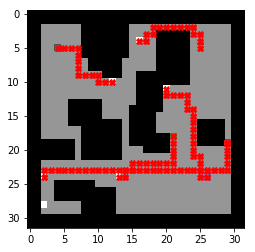

[10, 12]->[10, 11]->[10, 10]->[9, 10]->[9, 9]->[9, 8]->[9, 7]->[8, 7]->[7, 7]->[6, 7]->[5, 7]->[5, 6]->[5, 5]->[5, 4]->End
[4, 16]->[4, 17]->[3, 17]->[3, 18]->[2, 18]->[2, 19]->[2, 20]->[2, 21]->[2, 22]->[2, 23]->[2, 24]->[3, 24]->[3, 25]->[4, 25]->[5, 25]->End
[24, 2]->[23, 2]->[23, 3]->[23, 4]->[23, 5]->[23, 6]->[23, 7]->[23, 8]->[23, 9]->[23, 10]->[23, 11]->[23, 12]->[23, 13]->[23, 14]->[23, 15]->[22, 15]->[22, 16]->[22, 17]->[22, 18]->[22, 19]->[22, 20]->[22, 21]->[21, 21]->[20, 21]->[19, 21]->[18, 21]->End
[24, 13]->[24, 14]->[23, 14]->[23, 15]->[23, 16]->[23, 17]->[23, 18]->[23, 19]->[23, 20]->[23, 21]->[23, 22]->[23, 23]->[23, 24]->[23, 25]->[23, 26]->[23, 27]->[23, 28]->[23, 29]->[22, 29]->[21, 29]->[20, 29]->[19, 29]->End
[11, 20]->[12, 20]->[12, 21]->[12, 22]->[12, 23]->[13, 23]->[14, 23]->[14, 24]->[15, 24]->[16, 24]->[17, 24]->[18, 24]->[19, 24]->[20, 24]->[21, 24]->[21, 25]->[22, 25]->[23, 25]->[24, 25]->[24, 26]->End


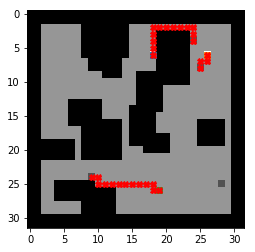

[6, 18]->[5, 18]->[4, 18]->[3, 18]->[2, 18]->[2, 19]->[2, 20]->[2, 21]->[2, 22]->[2, 23]->[2, 24]->[3, 24]->[4, 24]->End
[6, 26]->[7, 26]->[7, 25]->[8, 25]->End
[26, 19]->[26, 18]->[25, 18]->[25, 17]->[25, 16]->[25, 15]->[25, 14]->[25, 13]->[25, 12]->[25, 11]->[25, 10]->[24, 10]->[24, 9]->End


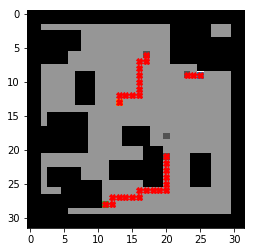

[9, 25]->[9, 24]->[9, 23]->End
[13, 13]->[12, 13]->[12, 14]->[12, 15]->[12, 16]->[11, 16]->[10, 16]->[9, 16]->[8, 16]->[7, 16]->[7, 17]->[6, 17]->End
[28, 11]->[28, 12]->[27, 12]->[27, 13]->[27, 14]->[27, 15]->[27, 16]->[26, 16]->[26, 17]->[26, 18]->[26, 19]->[26, 20]->[25, 20]->[24, 20]->[23, 20]->[22, 20]->[21, 20]->End


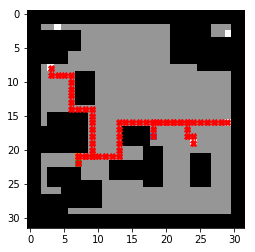

[16, 29]->[16, 28]->[16, 27]->[16, 26]->[16, 25]->[16, 24]->[16, 23]->[16, 22]->[16, 21]->[16, 20]->[16, 19]->[16, 18]->[17, 18]->[18, 18]->End
[19, 24]->[18, 24]->[18, 23]->[17, 23]->[16, 23]->[16, 22]->[16, 21]->[16, 20]->[16, 19]->[16, 18]->[16, 17]->[16, 16]->[16, 15]->[16, 14]->[16, 13]->[17, 13]->[18, 13]->[19, 13]->[20, 13]->[21, 13]->[21, 12]->[21, 11]->[21, 10]->[21, 9]->[21, 8]->[21, 7]->End
[8, 3]->[9, 3]->[9, 4]->[9, 5]->[9, 6]->[10, 6]->[11, 6]->[12, 6]->[13, 6]->[14, 6]->[14, 7]->[14, 8]->[14, 9]->[15, 9]->[16, 9]->[17, 9]->[18, 9]->[19, 9]->[20, 9]->[21, 9]->[21, 8]->[21, 7]->[22, 7]->End


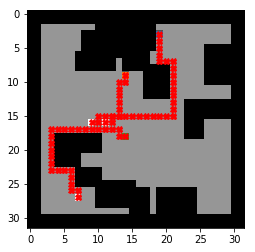

[16, 11]->[16, 12]->[15, 12]->[15, 13]->[15, 14]->[15, 15]->[15, 16]->[15, 17]->[15, 18]->[15, 19]->[15, 20]->[15, 21]->[14, 21]->[13, 21]->[12, 21]->[11, 21]->[10, 21]->[9, 21]->[8, 21]->[7, 21]->[7, 20]->[7, 19]->[6, 19]->[5, 19]->[4, 19]->[3, 19]->End
[16, 9]->[16, 10]->[15, 10]->[15, 11]->[15, 12]->[15, 13]->[14, 13]->[13, 13]->[12, 13]->[11, 13]->[10, 13]->[10, 14]->[9, 14]->End
[27, 7]->[26, 7]->[26, 6]->[25, 6]->[24, 6]->[23, 6]->[23, 5]->[23, 4]->[23, 3]->[22, 3]->[21, 3]->[20, 3]->[19, 3]->[18, 3]->[17, 3]->[17, 4]->[17, 5]->[17, 6]->[17, 7]->[17, 8]->[17, 9]->[17, 10]->[17, 11]->[17, 12]->[17, 13]->[18, 13]->[18, 14]->End


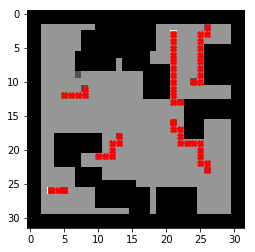

[2, 26]->[3, 26]->[3, 25]->[4, 25]->[5, 25]->[6, 25]->[7, 25]->[8, 25]->[9, 25]->[10, 25]->[10, 24]->End
[3, 21]->[4, 21]->[5, 21]->[6, 21]->[7, 21]->[8, 21]->[9, 21]->[10, 21]->[11, 21]->[12, 21]->[13, 21]->[13, 22]->End
[12, 5]->[12, 6]->[12, 7]->[12, 8]->[11, 8]->End
[16, 21]->[17, 21]->[17, 22]->[18, 22]->[19, 22]->[19, 23]->[19, 24]->[19, 25]->[20, 25]->[21, 25]->[22, 25]->[22, 26]->[23, 26]->End
[21, 10]->[21, 11]->[21, 12]->[20, 12]->[19, 12]->[19, 13]->[18, 13]->End
[26, 3]->[26, 4]->[26, 5]->End


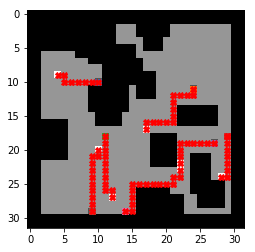

[9, 4]->[9, 5]->[10, 5]->[10, 6]->[10, 7]->[10, 8]->[10, 9]->[10, 10]->End
[17, 17]->[16, 17]->[16, 18]->[16, 19]->[16, 20]->[16, 21]->[15, 21]->[14, 21]->[13, 21]->[12, 21]->[12, 22]->[12, 23]->[12, 24]->[11, 24]->End
[27, 12]->[26, 12]->[26, 11]->[25, 11]->[24, 11]->[23, 11]->[22, 11]->[21, 11]->[20, 11]->[19, 11]->[18, 11]->End
[24, 28]->[24, 29]->[23, 29]->[22, 29]->[21, 29]->[20, 29]->[19, 29]->[18, 29]->End
[22, 22]->[21, 22]->[20, 22]->[19, 22]->[19, 23]->[19, 24]->[19, 25]->[19, 26]->[19, 27]->End
[20, 10]->[21, 10]->[21, 9]->[22, 9]->[23, 9]->[24, 9]->[25, 9]->[26, 9]->[27, 9]->[28, 9]->[29, 9]->End
[23, 22]->[24, 22]->[24, 21]->[25, 21]->[25, 20]->[25, 19]->[25, 18]->[25, 17]->[25, 16]->[25, 15]->[26, 15]->[27, 15]->[28, 15]->[29, 15]->[29, 14]->End


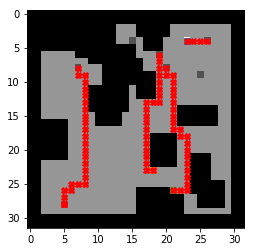

[4, 23]->[4, 24]->[4, 25]->[4, 26]->End
[23, 18]->[23, 17]->[22, 17]->[21, 17]->[20, 17]->[19, 17]->[18, 17]->[17, 17]->[16, 17]->[15, 17]->[14, 17]->[13, 17]->[13, 18]->[13, 19]->[12, 19]->[11, 19]->[10, 19]->[9, 19]->[8, 19]->[7, 19]->[6, 19]->End
[26, 21]->[26, 22]->[26, 23]->[25, 23]->[24, 23]->[23, 23]->[22, 23]->[21, 23]->[20, 23]->[19, 23]->[18, 23]->[18, 22]->[17, 22]->[17, 21]->[16, 21]->[15, 21]->[14, 21]->[13, 21]->[12, 21]->[11, 21]->[10, 21]->[9, 21]->[9, 20]->[8, 20]->End
[28, 5]->[27, 5]->[26, 5]->[26, 6]->[25, 6]->[25, 7]->[25, 8]->[24, 8]->[23, 8]->[22, 8]->[21, 8]->[20, 8]->[19, 8]->[18, 8]->[17, 8]->[16, 8]->[15, 8]->[14, 8]->[13, 8]->[12, 8]->[11, 8]->[10, 8]->[9, 8]->[9, 7]->[8, 7]->End


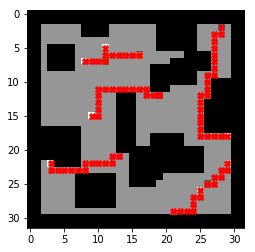

[18, 29]->[18, 28]->[18, 27]->[18, 26]->[18, 25]->[17, 25]->[16, 25]->[15, 25]->[14, 25]->[13, 25]->[12, 25]->[12, 26]->[11, 26]->[10, 26]->[9, 26]->[9, 27]->[8, 27]->[7, 27]->[6, 27]->[5, 27]->[4, 27]->[3, 27]->[3, 28]->[2, 28]->End
[5, 11]->[6, 11]->[6, 12]->[6, 13]->[6, 14]->[6, 15]->[6, 16]->End
[7, 8]->[7, 9]->[7, 10]->[7, 11]->End
[15, 9]->[15, 10]->[14, 10]->[13, 10]->[12, 10]->[11, 10]->[11, 11]->[11, 12]->[11, 13]->[11, 14]->[11, 15]->[11, 16]->[11, 17]->[12, 17]->[12, 18]->[12, 19]->End
[22, 3]->[23, 3]->[23, 4]->[23, 5]->[23, 6]->[23, 7]->[23, 8]->[22, 8]->[22, 9]->[22, 10]->[22, 11]->[22, 12]->[21, 12]->[21, 13]->End
[22, 29]->[23, 29]->[23, 28]->[24, 28]->[24, 27]->[25, 27]->[25, 26]->End
[26, 25]->[27, 25]->[27, 24]->[28, 24]->[29, 24]->[29, 23]->[29, 22]->[29, 21]->End


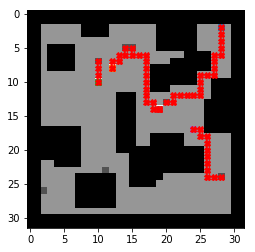

[2, 28]->[3, 28]->[4, 28]->[5, 28]->[6, 28]->[6, 27]->[7, 27]->[8, 27]->[9, 27]->[9, 26]->[9, 25]->[10, 25]->[11, 25]->[12, 25]->[12, 24]->[12, 23]->[12, 22]->[12, 21]->[13, 21]->[13, 20]->End
[8, 12]->[7, 12]->[7, 13]->[6, 13]->[6, 14]->[5, 14]->End
[10, 10]->[9, 10]->[8, 10]->[7, 10]->End
[14, 19]->[14, 18]->[13, 18]->[13, 17]->[12, 17]->[11, 17]->[10, 17]->[9, 17]->[8, 17]->[7, 17]->[6, 17]->[6, 16]->[6, 15]->[5, 15]->End
[17, 24]->[17, 25]->[18, 25]->[18, 26]->[19, 26]->[20, 26]->[21, 26]->[22, 26]->[23, 26]->[24, 26]->[24, 27]->[24, 28]->End


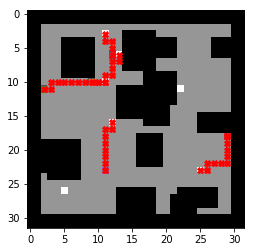

[3, 11]->[4, 11]->[4, 12]->[5, 12]->[6, 12]->End
[6, 13]->[7, 13]->[7, 12]->[8, 12]->[9, 12]->[9, 11]->[10, 11]->[10, 10]->[10, 9]->End
[10, 11]->[10, 10]->[10, 9]->[10, 8]->[10, 7]->[10, 6]->[10, 5]->[10, 4]->[10, 3]->[11, 3]->[11, 2]->End
[23, 25]->[23, 26]->[22, 26]->[22, 27]->[22, 28]->[22, 29]->[21, 29]->[20, 29]->[19, 29]->[18, 29]->End
[16, 12]->[17, 12]->[17, 11]->[18, 11]->[19, 11]->[20, 11]->[21, 11]->[22, 11]->[23, 11]->End


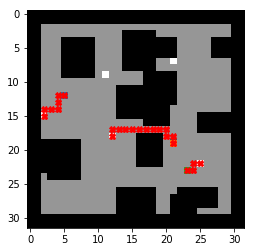

[15, 2]->[14, 2]->[14, 3]->[14, 4]->[13, 4]->[12, 4]->[12, 5]->End
[18, 12]->[17, 12]->[17, 13]->[17, 14]->[17, 15]->[17, 16]->[17, 17]->[17, 18]->[17, 19]->[17, 20]->[18, 20]->[18, 21]->[19, 21]->End
[22, 25]->[22, 24]->[23, 24]->[23, 23]->End


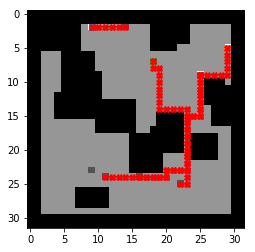

[2, 9]->[2, 10]->[2, 11]->[2, 12]->[2, 13]->[2, 14]->End
[5, 29]->[6, 29]->[7, 29]->[8, 29]->[9, 29]->[9, 28]->[9, 27]->[9, 26]->[9, 25]->[10, 25]->[11, 25]->[12, 25]->[13, 25]->[14, 25]->[15, 25]->[15, 24]->[15, 23]->[16, 23]->[17, 23]->[18, 23]->[19, 23]->[20, 23]->[21, 23]->[22, 23]->[23, 23]->[24, 23]->[25, 23]->[25, 22]->End
[7, 18]->[8, 18]->[8, 19]->[9, 19]->[10, 19]->[11, 19]->[12, 19]->[13, 19]->[14, 19]->[14, 20]->[14, 21]->[14, 22]->[14, 23]->[15, 23]->[16, 23]->[17, 23]->[18, 23]->[19, 23]->[20, 23]->[21, 23]->[22, 23]->[23, 23]->[23, 22]->[23, 21]->[23, 20]->[24, 20]->[24, 19]->[24, 18]->[24, 17]->[24, 16]->End
[9, 25]->[10, 25]->[11, 25]->[12, 25]->[13, 25]->[14, 25]->[15, 25]->[15, 24]->[15, 23]->[16, 23]->[17, 23]->[18, 23]->[19, 23]->[20, 23]->[21, 23]->[22, 23]->[23, 23]->[23, 22]->[23, 21]->[23, 20]->[24, 20]->[24, 19]->[24, 18]->[24, 17]->[24, 16]->[24, 15]->[24, 14]->[24, 13]->[24, 12]->[24, 11]->End


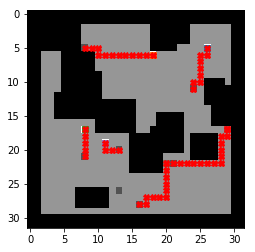

[5, 26]->[6, 26]->[6, 25]->[7, 25]->[8, 25]->[9, 25]->[10, 25]->[10, 24]->[11, 24]->End
[6, 18]->[6, 17]->[6, 16]->[6, 15]->[6, 14]->[6, 13]->[6, 12]->[6, 11]->[6, 10]->[5, 10]->[5, 9]->[5, 8]->End
[17, 8]->[18, 8]->[19, 8]->[20, 8]->[21, 8]->End
[17, 29]->[18, 29]->[18, 28]->[19, 28]->[20, 28]->[21, 28]->[22, 28]->[22, 27]->[22, 26]->[22, 25]->[22, 24]->[22, 23]->[22, 22]->[22, 21]->End
[19, 11]->[20, 11]->[20, 12]->[20, 13]->End
[22, 20]->[23, 20]->[24, 20]->[25, 20]->[26, 20]->[27, 20]->[27, 19]->[27, 18]->[27, 17]->[28, 17]->[28, 16]->End


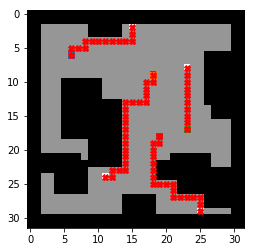

[2, 15]->[3, 15]->[4, 15]->[4, 14]->[4, 13]->[4, 12]->[4, 11]->[4, 10]->[4, 9]->[4, 8]->[5, 8]->[5, 7]->[5, 6]->[6, 6]->End
[24, 11]->[24, 12]->[23, 12]->[23, 13]->[23, 14]->[22, 14]->[21, 14]->[20, 14]->[19, 14]->[18, 14]->[17, 14]->[16, 14]->[15, 14]->[14, 14]->[13, 14]->[13, 15]->[13, 16]->[13, 17]->[12, 17]->[11, 17]->[10, 17]->[10, 18]->[9, 18]->End
[8, 23]->[9, 23]->[10, 23]->[11, 23]->[12, 23]->[13, 23]->[14, 23]->[15, 23]->[16, 23]->[17, 23]->End
[29, 25]->[28, 25]->[27, 25]->[27, 24]->[27, 23]->[27, 22]->[27, 21]->[26, 21]->[25, 21]->[25, 20]->[25, 19]->[25, 18]->[24, 18]->[23, 18]->[22, 18]->[21, 18]->[20, 18]->[19, 18]->[19, 19]->[18, 19]->End


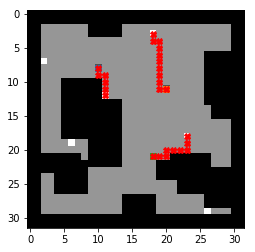

[12, 11]->[11, 11]->[10, 11]->[9, 11]->[9, 10]->[8, 10]->End
[3, 18]->[4, 18]->[4, 19]->[5, 19]->[6, 19]->[7, 19]->[8, 19]->[9, 19]->[10, 19]->[11, 19]->[11, 20]->End
[18, 23]->[19, 23]->[20, 23]->[20, 22]->[20, 21]->[20, 20]->[21, 20]->[21, 19]->[21, 18]->End


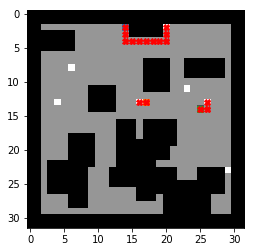

[2, 20]->[3, 20]->[4, 20]->[4, 19]->[4, 18]->[4, 17]->[4, 16]->[4, 15]->[4, 14]->[3, 14]->[2, 14]->End
[13, 16]->[13, 17]->End
[13, 26]->[14, 26]->[14, 25]->End


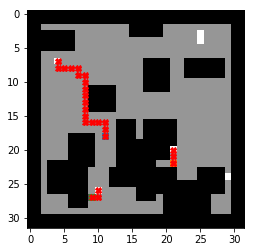

[7, 4]->[8, 4]->[8, 5]->[8, 6]->[8, 7]->[9, 7]->[9, 8]->[10, 8]->[11, 8]->[12, 8]->[13, 8]->[14, 8]->[15, 8]->[16, 8]->[16, 9]->[16, 10]->[16, 11]->[17, 11]->[18, 11]->End
[20, 21]->[21, 21]->[22, 21]->End
[26, 10]->[27, 10]->[27, 9]->End


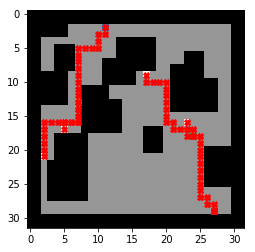

[17, 5]->[16, 5]->[16, 6]->[16, 7]->[15, 7]->[14, 7]->[13, 7]->[12, 7]->[11, 7]->[10, 7]->[9, 7]->[8, 7]->[7, 7]->[6, 7]->[5, 7]->[5, 8]->[5, 9]->[5, 10]->[4, 10]->[3, 10]->[3, 11]->[2, 11]->End
[21, 2]->[20, 2]->[19, 2]->[18, 2]->[17, 2]->[16, 2]->[16, 3]->[16, 4]->[16, 5]->[16, 6]->[16, 7]->[15, 7]->[14, 7]->[13, 7]->End
[9, 17]->[10, 17]->[10, 18]->[10, 19]->[10, 20]->[11, 20]->[12, 20]->[13, 20]->[14, 20]->[15, 20]->[16, 20]->[16, 21]->[17, 21]->[17, 22]->[17, 23]->[18, 23]->[18, 24]->End
[16, 23]->[17, 23]->[17, 24]->[18, 24]->[18, 25]->[19, 25]->[20, 25]->[21, 25]->[22, 25]->[23, 25]->[24, 25]->[25, 25]->[26, 25]->[27, 25]->[27, 26]->[28, 26]->[28, 27]->[29, 27]->End


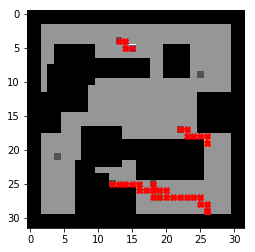

[5, 15]->[5, 14]->[4, 14]->[4, 13]->End
[19, 26]->[18, 26]->[18, 25]->[18, 24]->[18, 23]->[17, 23]->[17, 22]->End
[27, 19]->[27, 18]->[26, 18]->[26, 17]->[26, 16]->[25, 16]->[25, 15]->[25, 14]->[25, 13]->[25, 12]->End
[29, 26]->[28, 26]->[28, 25]->[27, 25]->[27, 24]->[27, 23]->[27, 22]->[27, 21]->[27, 20]->[26, 20]->[26, 19]->[26, 18]->[25, 18]->End


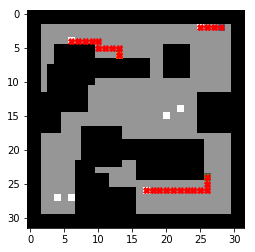

[2, 25]->[2, 26]->[2, 27]->[2, 28]->End
[4, 6]->[4, 7]->[4, 8]->[4, 9]->[4, 10]->[5, 10]->[5, 11]->[5, 12]->[5, 13]->[6, 13]->End
[26, 17]->[26, 18]->[26, 19]->[26, 20]->[26, 21]->[26, 22]->[26, 23]->[26, 24]->[26, 25]->[26, 26]->[25, 26]->[24, 26]->End


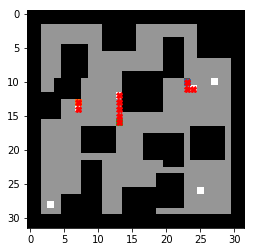

[11, 24]->[11, 23]->[10, 23]->End
[14, 7]->[13, 7]->End
[12, 13]->[13, 13]->[14, 13]->[15, 13]->[16, 13]->End


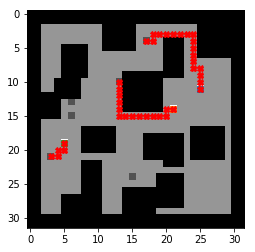

[11, 25]->[10, 25]->[9, 25]->[8, 25]->[8, 24]->[7, 24]->[6, 24]->[5, 24]->[4, 24]->[3, 24]->[3, 23]->[3, 22]->[3, 21]->[3, 20]->[3, 19]->[3, 18]->[4, 18]->[4, 17]->End
[14, 21]->[14, 20]->[15, 20]->[15, 19]->[15, 18]->[15, 17]->[15, 16]->[15, 15]->[15, 14]->[15, 13]->[14, 13]->[13, 13]->[12, 13]->[11, 13]->[10, 13]->End
[19, 5]->[20, 5]->[20, 4]->[21, 4]->[21, 3]->End
Goal Accuracy: 1.0
218.0 218.0
Average traj step length : 19.12
956.0 50


In [117]:
correct,total,traj_step = 0.0,0.0,0.0   
imsize = 32
max_rand_play= 0
memory = []
for i in range(50):
    if  i == 44:
      continue
    
    X = test_data[i][0].clone()
    
    Y = torch.zeros([3,32,32])
    
    Y[:,2:30,2:30] = X.clone()
    
    go = np.where(Y[1] == 1.0)
    goal = np.column_stack([go[0],go[1]])
    
  
        
    #current_goal,current_total,traj,memory = agent_predict(model_28x28,Y.clone(),goal,imsize,max_rand_play)
   # correct_goal,total_goal, traj_length,traj = agent_prediction(model_28x28,Y.clone(),[],goal,imsize,0)
    correct_goal,total_goal, traj_length,traj,change = cooperative(model=model_28x28,X=Y.clone(),imsize=imsize)
    
    dom = Y[0] - 0.5 * Y[1] + Y[2]
    visualization(dom,traj)
        
    if change == 1:
        for i in traj:
            L = len(i[0])
            for j in range(L-1,-1,-1):
                print([i[0][j][0].item(),i[0][j][1].item()],end='->')
            print("End")
    else :
        for i in traj:
            for j in i[0]:
                print([j[0].item(),j[1].item()],end='->')
            print("End")
    
    correct += correct_goal
    total += total_goal
    traj_step += traj_length
    
print(f'Goal Accuracy: {correct/total}')
print(correct,total)
print(f'Average traj step length : {traj_step/50}')
print(traj_step,50)

In [0]:
test = []
with np.load('Env_32x32.npz', mmap_mode='r') as f:
    test = f['arr_0']

In [0]:
test_data = []

for i in test:
    env = -1 *(i[0] == 0) + 1.0
    goal = (i[0] == 0.5) + 0.0
    Agent = i[1]
    domain = np.array([env,goal,Agent])
    
    test_data.append([torch.tensor(domain.copy())])

In [120]:
model_32x32 = MA_P(50,36)
model_32x32.load_state_dict(torch.load('MA_P_2_9_2.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [121]:
model_32x32.cuda()

MA_P(
  (h): Conv2d(3, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (r): Conv2d(150, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (q): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (sm): Softmax()
)

In [0]:
correct,total,traj_step = 0.0,0.0,0.0   
imsize = 36
max_rand_play= 0
memory = []
for i in range(50):
    if i == 32 :
      continue
    
    X = test_data[i][0].clone()
    
    Y = torch.zeros([3,36,36])
    
    Y[:,2:34,2:34] = X.clone()
    
    go = np.where(Y[1] == 1.0)
    goal = np.column_stack([go[0],go[1]])
    
  
        
    #current_goal,current_total,traj,memory = agent_predict(model_28x28,Y.clone(),goal,imsize,max_rand_play)
    correct_goal,total_goal, traj_length,traj = agent_prediction(model_32x32,Y.clone(),[],goal,imsize,0)
    #correct_goal,total_goal, traj_length,traj = cooperative(model=model_32x32,X=Y.clone(),imsize=imsize)
    
    #for j in traj:
     # for k in j:
      #   print(k,end="->")
     # print("End")
      
   # print(i,correct_goal,total_goal)
    
    correct += correct_goal
    total += total_goal
    traj_step += traj_length
    
print(f'Goal Accuracy: {correct/total}')
print(correct,total)
print(f'Average traj step length : {traj_step/50}')
print(traj_step,50)

Goal Accuracy: 0.7183908045977011
125.0 174.0
Average traj step length : 18.82
941.0 50


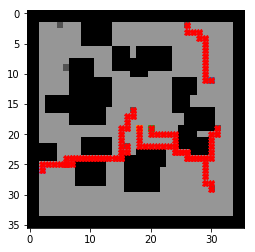

[11, 30]->[11, 29]->[10, 29]->[9, 29]->[8, 29]->[7, 29]->[6, 29]->[5, 29]->[4, 29]->[4, 28]->[3, 28]->[3, 27]->[3, 26]->[2, 26]->End
[19, 18]->[20, 18]->[21, 18]->[22, 18]->[22, 19]->[22, 20]->[22, 21]->[22, 22]->[22, 23]->[22, 24]->[23, 24]->[23, 25]->[23, 26]->[24, 26]->[24, 27]->[24, 28]->[24, 29]->[25, 29]->[26, 29]->[27, 29]->[28, 29]->[28, 30]->[29, 30]->End
[19, 20]->[20, 20]->[20, 21]->[20, 22]->[20, 23]->[20, 24]->[21, 24]->[22, 24]->[23, 24]->[23, 25]->[23, 26]->[24, 26]->[24, 27]->[24, 28]->[24, 29]->[24, 30]->[23, 30]->[22, 30]->[21, 30]->[20, 30]->[20, 31]->[19, 31]->End
[25, 6]->[24, 6]->[24, 7]->[24, 8]->[24, 9]->[24, 10]->[24, 11]->[24, 12]->[24, 13]->[24, 14]->[24, 15]->[23, 15]->[22, 15]->[21, 15]->[20, 15]->[19, 15]->[19, 16]->[18, 16]->[17, 16]->[17, 17]->[16, 17]->End
[26, 2]->[25, 2]->[25, 3]->[25, 4]->[25, 5]->[25, 6]->[25, 7]->[24, 7]->[24, 8]->[24, 9]->[24, 10]->[24, 11]->[24, 12]->[24, 13]->[24, 14]->[24, 15]->[23, 15]->[23, 16]->[22, 16]->End


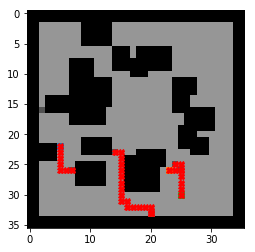

[22, 5]->[23, 5]->[24, 5]->[25, 5]->[26, 5]->[26, 6]->[26, 7]->End
[26, 23]->[26, 24]->[26, 25]->End
[30, 25]->[29, 25]->[28, 25]->[27, 25]->[26, 25]->[25, 25]->[25, 24]->End
[33, 20]->[32, 20]->[32, 19]->[32, 18]->[32, 17]->[32, 16]->[31, 16]->[31, 15]->[30, 15]->[29, 15]->[28, 15]->[27, 15]->[26, 15]->[25, 15]->[24, 15]->[23, 15]->[23, 14]->End


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


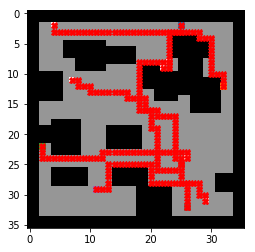

[9, 22]->[9, 23]->[8, 23]->[7, 23]->[6, 23]->[5, 23]->[4, 23]->[3, 23]->[3, 24]->[3, 25]->[2, 25]->End
[2, 4]->[3, 4]->[3, 5]->[3, 6]->[3, 7]->[3, 8]->[3, 9]->[3, 10]->[3, 11]->[3, 12]->[3, 13]->[3, 14]->[3, 15]->[3, 16]->[3, 17]->[3, 18]->[3, 19]->[3, 20]->[3, 21]->[3, 22]->[3, 23]->[3, 24]->[3, 25]->[3, 26]->[3, 27]->[3, 28]->[4, 28]->[4, 29]->[4, 30]->[5, 30]->[6, 30]->[7, 30]->[8, 30]->[9, 30]->[10, 30]->[10, 31]->[10, 32]->[11, 32]->[12, 32]->End
[24, 26]->[23, 26]->[23, 25]->[23, 24]->[23, 23]->[23, 22]->[23, 21]->[23, 20]->[23, 19]->[23, 18]->[23, 17]->[23, 16]->[23, 15]->[23, 14]->[23, 13]->[23, 12]->[24, 12]->[24, 11]->[24, 10]->[24, 9]->[24, 8]->[24, 7]->[24, 6]->[24, 5]->[24, 4]->[24, 3]->[24, 2]->[23, 2]->[22, 2]->End
[11, 7]->[11, 8]->[12, 8]->[12, 9]->[12, 10]->[13, 10]->[13, 11]->[13, 12]->[13, 13]->[13, 14]->[13, 15]->[13, 16]->[14, 16]->[14, 17]->[14, 18]->[15, 18]->[16, 18]->[16, 19]->[16, 20]->[16, 21]->[17, 21]->[17, 22]->[17, 23]->[17, 24]->[18, 24]->[19, 24]->[20,

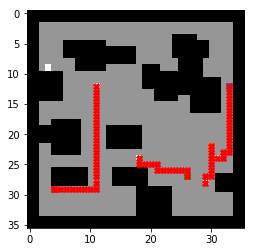

[24, 31]->[24, 32]->[23, 32]->[23, 33]->[22, 33]->[21, 33]->[20, 33]->[19, 33]->[18, 33]->[17, 33]->[16, 33]->[15, 33]->[14, 33]->[13, 33]->[12, 33]->End
[28, 29]->[27, 29]->[27, 30]->[26, 30]->[25, 30]->[24, 30]->[23, 30]->[22, 30]->End
[24, 18]->[25, 18]->[25, 19]->[25, 20]->[25, 21]->[26, 21]->[26, 22]->[26, 23]->[26, 24]->[26, 25]->[26, 26]->[27, 26]->End
[12, 11]->[13, 11]->[14, 11]->[15, 11]->[16, 11]->[17, 11]->[18, 11]->[19, 11]->[20, 11]->[21, 11]->[22, 11]->[23, 11]->[24, 11]->[25, 11]->[26, 11]->[27, 11]->[28, 11]->[29, 11]->[29, 10]->[29, 9]->[29, 8]->[29, 7]->[29, 6]->[29, 5]->[29, 4]->End


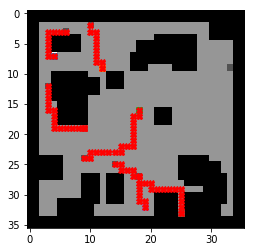

[7, 4]->[7, 3]->[6, 3]->[5, 3]->[4, 3]->[3, 3]->[3, 4]->[3, 5]->[3, 6]->End
[9, 12]->[8, 12]->[8, 11]->[7, 11]->[6, 11]->[5, 11]->[4, 11]->[3, 11]->[3, 10]->[2, 10]->End
[16, 18]->[17, 18]->[17, 17]->[18, 17]->[19, 17]->[20, 17]->[21, 17]->[22, 17]->[22, 16]->[22, 15]->[23, 15]->[23, 14]->[23, 13]->[23, 12]->[23, 11]->[23, 10]->[24, 10]->[24, 9]->End
[19, 9]->[19, 8]->[19, 7]->[19, 6]->[19, 5]->[19, 4]->[18, 4]->[17, 4]->[16, 4]->[16, 3]->[15, 3]->[14, 3]->[13, 3]->[12, 3]->End
[32, 19]->[31, 19]->[31, 18]->[30, 18]->[29, 18]->[28, 18]->[27, 18]->[27, 17]->[26, 17]->[26, 16]->[26, 15]->[25, 15]->[25, 14]->End
[33, 25]->[32, 25]->[31, 25]->[30, 25]->[29, 25]->[29, 24]->[29, 23]->[29, 22]->[29, 21]->[29, 20]->[28, 20]->[28, 19]->[28, 18]->[27, 18]->End


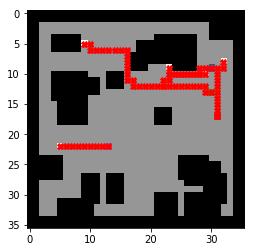

[9, 23]->[10, 23]->[10, 24]->[10, 25]->[10, 26]->[10, 27]->[10, 28]->[9, 28]->[9, 29]->[9, 30]->End
[10, 29]->[10, 28]->[10, 27]->[10, 26]->[10, 25]->[10, 24]->[10, 23]->[11, 23]->[11, 22]->[12, 22]->End
[5, 9]->[5, 10]->[6, 10]->[6, 11]->[6, 12]->[6, 13]->[6, 14]->[6, 15]->[6, 16]->[7, 16]->[8, 16]->[9, 16]->[10, 16]->[11, 16]->[11, 17]->[12, 17]->[12, 18]->[12, 19]->[12, 20]->[12, 21]->[12, 22]->[12, 23]->[12, 24]->[12, 25]->[12, 26]->[12, 27]->[12, 28]->[12, 29]->[13, 29]->[13, 30]->End
[8, 32]->[9, 32]->[9, 31]->[10, 31]->[11, 31]->[12, 31]->[13, 31]->[14, 31]->[15, 31]->[16, 31]->[17, 31]->End
[22, 5]->[22, 6]->[22, 7]->[22, 8]->[22, 9]->[22, 10]->[22, 11]->[22, 12]->[22, 13]->End


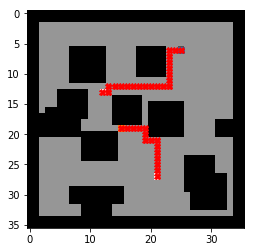

[13, 12]->[13, 13]->[12, 13]->[12, 14]->[12, 15]->[12, 16]->[12, 17]->[12, 18]->[12, 19]->[12, 20]->[12, 21]->[12, 22]->[12, 23]->[11, 23]->[10, 23]->[9, 23]->[8, 23]->[7, 23]->[6, 23]->[6, 24]->[6, 25]->End
[27, 21]->[26, 21]->[25, 21]->[24, 21]->[23, 21]->[22, 21]->[21, 21]->[21, 20]->[21, 19]->[20, 19]->[19, 19]->[19, 18]->[19, 17]->[19, 16]->[19, 15]->End


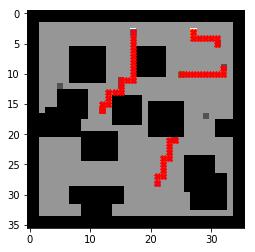

[3, 17]->[4, 17]->[5, 17]->[6, 17]->[7, 17]->[8, 17]->[9, 17]->[10, 17]->[11, 17]->[11, 16]->[11, 15]->End
[3, 27]->[4, 27]->[4, 28]->[4, 29]->[4, 30]->[4, 31]->[5, 31]->End
[10, 25]->[10, 26]->[10, 27]->[10, 28]->[10, 29]->[10, 30]->[10, 31]->[10, 32]->[9, 32]->End
[16, 12]->[15, 12]->[15, 13]->[14, 13]->[13, 13]->[13, 14]->[13, 15]->[12, 15]->End
[28, 21]->[27, 21]->[27, 22]->[26, 22]->[25, 22]->[24, 22]->[24, 23]->[23, 23]->[22, 23]->[21, 23]->[21, 24]->End


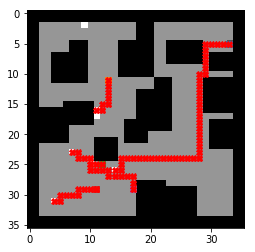

[26, 14]->[26, 15]->[25, 15]->[24, 15]->[24, 16]->[24, 17]->[24, 18]->[24, 19]->[24, 20]->[24, 21]->[24, 22]->[24, 23]->[24, 24]->[24, 25]->[24, 26]->[24, 27]->[24, 28]->[23, 28]->[22, 28]->[21, 28]->[20, 28]->[19, 28]->[18, 28]->[17, 28]->[16, 28]->[15, 28]->[14, 28]->[13, 28]->[12, 28]->[11, 28]->[10, 28]->[10, 29]->[9, 29]->[8, 29]->[7, 29]->[6, 29]->[5, 29]->[5, 30]->[5, 31]->[5, 32]->[5, 33]->End
[16, 11]->[16, 12]->[15, 12]->[15, 13]->[14, 13]->[13, 13]->[12, 13]->[11, 13]->End
[23, 7]->[23, 8]->[24, 8]->[24, 9]->[24, 10]->[25, 10]->[25, 11]->[25, 12]->End
[31, 4]->[31, 5]->[30, 5]->[30, 6]->[30, 7]->[30, 8]->[29, 8]->[29, 9]->[29, 10]->[29, 11]->End
[25, 10]->[26, 10]->[26, 11]->[26, 12]->[26, 13]->[27, 13]->[27, 14]->[27, 15]->[27, 16]->[27, 17]->[28, 17]->[29, 17]->End


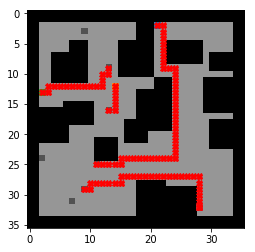

[2, 21]->[2, 22]->[3, 22]->[4, 22]->[5, 22]->[6, 22]->[7, 22]->[8, 22]->[9, 22]->[9, 23]->[9, 24]->[10, 24]->[11, 24]->[12, 24]->[13, 24]->[14, 24]->[15, 24]->[16, 24]->[17, 24]->[18, 24]->[19, 24]->[20, 24]->[21, 24]->[22, 24]->[23, 24]->[24, 24]->[24, 23]->[24, 22]->[24, 21]->[24, 20]->[24, 19]->[24, 18]->[24, 17]->[24, 16]->[24, 15]->[25, 15]->[25, 14]->[25, 13]->[25, 12]->[25, 11]->End
[12, 14]->[13, 14]->[14, 14]->[15, 14]->[16, 14]->[16, 13]->End
[13, 2]->[13, 3]->[12, 3]->[12, 4]->[12, 5]->[12, 6]->[12, 7]->[12, 8]->[12, 9]->[12, 10]->[12, 11]->[12, 12]->[11, 12]->[10, 12]->[10, 13]->[9, 13]->End
[32, 28]->[31, 28]->[30, 28]->[29, 28]->[28, 28]->[27, 28]->[27, 27]->[27, 26]->[27, 25]->[27, 24]->[27, 23]->[27, 22]->[27, 21]->[27, 20]->[27, 19]->[27, 18]->[27, 17]->[27, 16]->[27, 15]->[28, 15]->[28, 14]->[28, 13]->[28, 12]->[28, 11]->[28, 10]->[29, 10]->[29, 9]->End


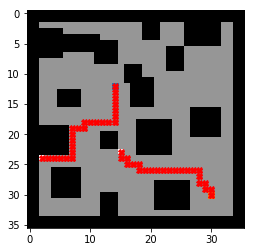

[24, 2]->[24, 3]->[24, 4]->[24, 5]->[24, 6]->[24, 7]->[23, 7]->[22, 7]->[21, 7]->[20, 7]->[19, 7]->[19, 8]->[19, 9]->[18, 9]->[18, 10]->[18, 11]->[18, 12]->[18, 13]->[18, 14]->[17, 14]->[16, 14]->[15, 14]->[14, 14]->[13, 14]->[12, 14]->End
[23, 15]->[24, 15]->[24, 16]->[25, 16]->[25, 17]->[25, 18]->[26, 18]->[26, 19]->[26, 20]->[26, 21]->[26, 22]->[26, 23]->[26, 24]->[26, 25]->[26, 26]->[26, 27]->[26, 28]->[27, 28]->[28, 28]->[28, 29]->[29, 29]->[29, 30]->[30, 30]->End


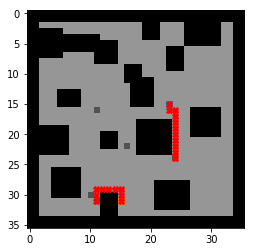

[15, 23]->[16, 23]->[16, 24]->[17, 24]->[18, 24]->[19, 24]->[20, 24]->[21, 24]->[22, 24]->[23, 24]->[24, 24]->End
[31, 15]->[30, 15]->[29, 15]->[29, 14]->[29, 13]->[29, 12]->[29, 11]->[30, 11]->[31, 11]->End


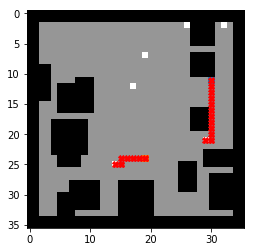

[21, 29]->[21, 30]->[20, 30]->[19, 30]->[18, 30]->[17, 30]->[16, 30]->[15, 30]->[14, 30]->[13, 30]->[12, 30]->[11, 30]->End
[25, 14]->[25, 15]->[24, 15]->[24, 16]->[24, 17]->[24, 18]->[24, 19]->End


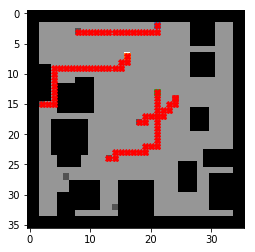

[2, 21]->[3, 21]->[3, 20]->[3, 19]->[3, 18]->[3, 17]->[3, 16]->[3, 15]->[3, 14]->[3, 13]->[3, 12]->[3, 11]->[3, 10]->[3, 9]->[3, 8]->End
[7, 16]->[8, 16]->[8, 15]->[9, 15]->[9, 14]->[9, 13]->[9, 12]->[9, 11]->[9, 10]->[9, 9]->[9, 8]->[9, 7]->[9, 6]->[9, 5]->[9, 4]->[10, 4]->[11, 4]->[12, 4]->[13, 4]->[14, 4]->[15, 4]->[15, 3]->[15, 2]->End
[13, 21]->[14, 21]->[15, 21]->[16, 21]->[17, 21]->[18, 21]->[19, 21]->[20, 21]->[21, 21]->[22, 21]->[22, 20]->[22, 19]->[23, 19]->[23, 18]->[23, 17]->[23, 16]->[23, 15]->[23, 14]->[24, 14]->[24, 13]->End
[14, 24]->[15, 24]->[15, 23]->[16, 23]->[16, 22]->[17, 22]->[17, 21]->[17, 20]->[17, 19]->[18, 19]->[18, 18]->End


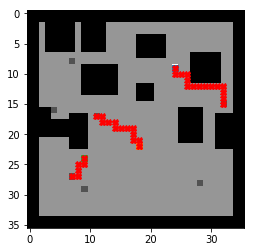

[9, 24]->[10, 24]->[10, 25]->[10, 26]->[11, 26]->[12, 26]->[12, 27]->[12, 28]->[12, 29]->[12, 30]->[12, 31]->[12, 32]->[13, 32]->[14, 32]->[15, 32]->End
[22, 18]->[21, 18]->[21, 17]->[20, 17]->[19, 17]->[19, 16]->[19, 15]->[19, 14]->[18, 14]->[18, 13]->[18, 12]->[17, 12]->[17, 11]->End
[24, 9]->[25, 9]->[25, 8]->[26, 8]->[27, 8]->[27, 7]->End


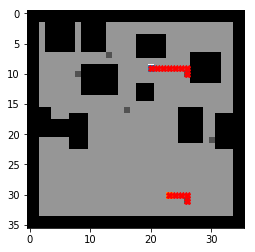

[9, 20]->[9, 21]->[9, 22]->[9, 23]->[9, 24]->[9, 25]->[9, 26]->[10, 26]->End
[30, 23]->[30, 24]->[30, 25]->[30, 26]->[31, 26]->End


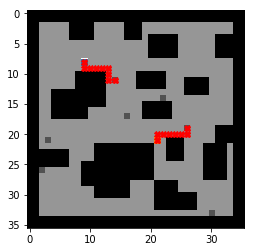

[8, 9]->[9, 9]->[9, 10]->[9, 11]->[9, 12]->[9, 13]->[10, 13]->[11, 13]->[11, 14]->End
[21, 21]->[20, 21]->[20, 22]->[20, 23]->[20, 24]->[20, 25]->[20, 26]->[19, 26]->End


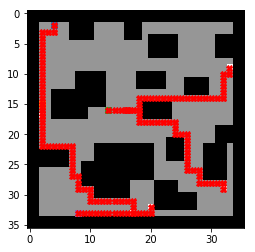

[17, 2]->[16, 2]->[15, 2]->[14, 2]->[13, 2]->[12, 2]->[11, 2]->[10, 2]->[9, 2]->[8, 2]->[7, 2]->[6, 2]->[5, 2]->[4, 2]->[3, 2]->[3, 3]->[3, 4]->[2, 4]->End
[33, 17]->[32, 17]->[31, 17]->[31, 16]->[31, 15]->[31, 14]->[31, 13]->[31, 12]->[31, 11]->[31, 10]->[30, 10]->[29, 10]->[29, 9]->[29, 8]->[28, 8]->[27, 8]->[27, 7]->[26, 7]->[25, 7]->[24, 7]->[23, 7]->[22, 7]->[22, 6]->[22, 5]->[22, 4]->[22, 3]->[22, 2]->[21, 2]->[20, 2]->[19, 2]->[18, 2]->[17, 2]->[16, 2]->[15, 2]->End
[9, 33]->[10, 33]->[10, 32]->[11, 32]->[12, 32]->[13, 32]->[14, 32]->[14, 31]->[14, 30]->[14, 29]->[14, 28]->[14, 27]->[14, 26]->[14, 25]->[14, 24]->[14, 23]->[14, 22]->[14, 21]->[14, 20]->[14, 19]->[14, 18]->[15, 18]->[16, 18]->[16, 17]->[16, 16]->[16, 15]->[16, 14]->[16, 13]->End
[29, 32]->[28, 32]->[28, 31]->[28, 30]->[28, 29]->[28, 28]->[27, 28]->[26, 28]->[26, 27]->[26, 26]->[25, 26]->[24, 26]->[23, 26]->[22, 26]->[21, 26]->[20, 26]->[20, 25]->[20, 24]->[19, 24]->[18, 24]->[18, 23]->[18, 22]->[18, 21]->[18, 20]-

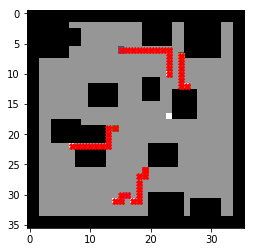

[10, 23]->[9, 23]->[8, 23]->[7, 23]->[6, 23]->[6, 22]->[6, 21]->[6, 20]->[6, 19]->[6, 18]->[6, 17]->[6, 16]->[6, 15]->End
[12, 26]->[12, 25]->[11, 25]->[10, 25]->[9, 25]->[8, 25]->[7, 25]->End
[22, 7]->[22, 8]->[22, 9]->[22, 10]->[22, 11]->[22, 12]->[22, 13]->[21, 13]->[20, 13]->[19, 13]->[19, 14]->End
[31, 17]->[31, 18]->[30, 18]->[29, 18]->[28, 18]->[27, 18]->[27, 19]->[26, 19]->End
[31, 14]->[31, 15]->[30, 15]->[30, 16]->End


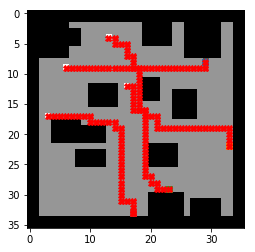

[9, 6]->[9, 7]->[9, 8]->[9, 9]->[9, 10]->[9, 11]->[9, 12]->[9, 13]->[9, 14]->[9, 15]->[9, 16]->[9, 17]->[9, 18]->[9, 19]->[9, 20]->[9, 21]->[9, 22]->[9, 23]->[9, 24]->[9, 25]->[9, 26]->[9, 27]->[9, 28]->[9, 29]->[8, 29]->End
[12, 16]->[12, 17]->[13, 17]->[14, 17]->[15, 17]->[16, 17]->[16, 18]->[16, 19]->[17, 19]->[17, 20]->[17, 21]->[18, 21]->[19, 21]->[19, 22]->[19, 23]->[19, 24]->[19, 25]->[19, 26]->[19, 27]->[19, 28]->[19, 29]->[19, 30]->[19, 31]->[19, 32]->[19, 33]->[20, 33]->[21, 33]->[22, 33]->End
[4, 13]->[4, 14]->[5, 14]->[5, 15]->[5, 16]->[6, 16]->[7, 16]->[7, 17]->[8, 17]->[9, 17]->[9, 18]->[10, 18]->[11, 18]->[12, 18]->[13, 18]->[14, 18]->[15, 18]->[16, 18]->[16, 19]->[17, 19]->[18, 19]->[19, 19]->[20, 19]->[21, 19]->[22, 19]->[23, 19]->[24, 19]->[25, 19]->[26, 19]->[27, 19]->[27, 20]->[28, 20]->[28, 21]->[29, 21]->[29, 22]->[29, 23]->End
[17, 3]->[17, 4]->[17, 5]->[17, 6]->[17, 7]->[17, 8]->[17, 9]->[17, 10]->[18, 10]->[18, 11]->[18, 12]->[18, 13]->[18, 14]->[19, 14]->[19, 

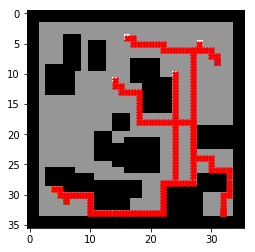

[4, 16]->[4, 17]->[5, 17]->[5, 18]->[5, 19]->[5, 20]->[5, 21]->[5, 22]->[6, 22]->[6, 23]->[6, 24]->[6, 25]->[6, 26]->[6, 27]->[6, 28]->[6, 29]->[6, 30]->[7, 30]->[7, 31]->[8, 31]->End
[10, 24]->[11, 24]->[12, 24]->[13, 24]->[14, 24]->[15, 24]->[16, 24]->[17, 24]->[18, 24]->[19, 24]->[20, 24]->[21, 24]->[22, 24]->[23, 24]->[24, 24]->[25, 24]->[26, 24]->[27, 24]->[28, 24]->[28, 23]->[28, 22]->[29, 22]->[30, 22]->[31, 22]->[32, 22]->[33, 22]->[33, 21]->[33, 20]->[33, 19]->[33, 18]->[33, 17]->[33, 16]->[33, 15]->[33, 14]->[33, 13]->[33, 12]->[33, 11]->[33, 10]->[32, 10]->[31, 10]->[30, 10]->[30, 9]->[30, 8]->[30, 7]->[30, 6]->[30, 5]->[29, 5]->[29, 4]->End
[5, 28]->[6, 28]->[6, 27]->[7, 27]->[8, 27]->[9, 27]->[10, 27]->[11, 27]->[12, 27]->[13, 27]->[14, 27]->[15, 27]->[16, 27]->[17, 27]->[18, 27]->[19, 27]->[20, 27]->[21, 27]->[22, 27]->[23, 27]->[24, 27]->[25, 27]->[26, 27]->[27, 27]->[28, 27]->[28, 26]->[28, 25]->[28, 24]->[28, 23]->[28, 22]->[29, 22]->[30, 22]->[31, 22]->[32, 22]->[33, 

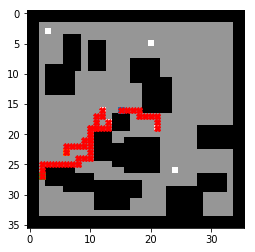

[19, 21]->[18, 21]->[17, 21]->[17, 20]->[17, 19]->[17, 18]->[16, 18]->[16, 17]->[16, 16]->[16, 15]->End
[16, 12]->[17, 12]->[17, 11]->[18, 11]->[19, 11]->[19, 10]->[20, 10]->[21, 10]->[21, 9]->[22, 9]->[22, 8]->[22, 7]->[22, 6]->[23, 6]->End
[18, 13]->[19, 13]->[19, 12]->[19, 11]->[19, 10]->[20, 10]->[21, 10]->[22, 10]->[23, 10]->[24, 10]->[24, 9]->[24, 8]->[25, 8]->[25, 7]->[25, 6]->[25, 5]->[25, 4]->[25, 3]->[25, 2]->[26, 2]->[27, 2]->End


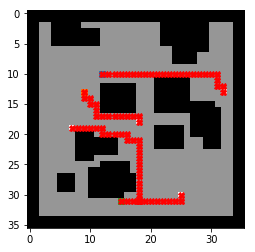

[13, 32]->[12, 32]->[12, 31]->[11, 31]->[10, 31]->[10, 30]->[10, 29]->[10, 28]->[10, 27]->[10, 26]->[10, 25]->[10, 24]->[10, 23]->[10, 22]->[10, 21]->[10, 20]->[10, 19]->[10, 18]->[10, 17]->[10, 16]->[10, 15]->[10, 14]->[10, 13]->[10, 12]->End
[18, 18]->[17, 18]->[17, 17]->[17, 16]->[17, 15]->[17, 14]->[17, 13]->[17, 12]->[17, 11]->[16, 11]->[15, 11]->[15, 10]->[14, 10]->[14, 9]->[13, 9]->End
[30, 25]->[31, 25]->[31, 24]->[31, 23]->[31, 22]->[31, 21]->[31, 20]->[31, 19]->[31, 18]->[31, 17]->[31, 16]->[31, 15]->End
[19, 7]->[19, 8]->[19, 9]->[19, 10]->[19, 11]->[19, 12]->[20, 12]->[20, 13]->[20, 14]->[20, 15]->[20, 16]->[21, 16]->[21, 17]->[21, 18]->[22, 18]->[23, 18]->[24, 18]->[25, 18]->[26, 18]->[27, 18]->[28, 18]->[29, 18]->[30, 18]->[31, 18]->End


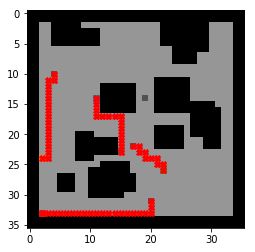

[14, 11]->[15, 11]->[16, 11]->[17, 11]->[17, 12]->[17, 13]->[17, 14]->[17, 15]->[18, 15]->[19, 15]->[20, 15]->[21, 15]->[22, 15]->[23, 15]->End
[24, 2]->[24, 3]->[23, 3]->[22, 3]->[21, 3]->[20, 3]->[19, 3]->[18, 3]->[17, 3]->[16, 3]->[15, 3]->[14, 3]->[13, 3]->[12, 3]->[11, 3]->[11, 4]->[10, 4]->End
[26, 22]->[25, 22]->[25, 21]->[24, 21]->[24, 20]->[24, 19]->[23, 19]->[23, 18]->[22, 18]->[22, 17]->End
[33, 2]->[33, 3]->[33, 4]->[33, 5]->[33, 6]->[33, 7]->[33, 8]->[33, 9]->[33, 10]->[33, 11]->[33, 12]->[33, 13]->[33, 14]->[33, 15]->[33, 16]->[33, 17]->[33, 18]->[33, 19]->[33, 20]->[32, 20]->[31, 20]->End


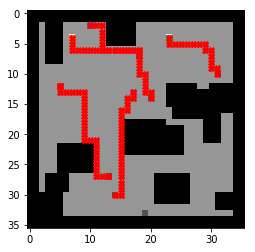

[2, 10]->[2, 11]->[2, 12]->[3, 12]->[4, 12]->[5, 12]->[6, 12]->[6, 13]->[6, 14]->[6, 15]->[6, 16]->[6, 17]->[6, 18]->[7, 18]->[8, 18]->[9, 18]->[10, 18]->[10, 19]->[11, 19]->[12, 19]->[13, 19]->[13, 20]->[14, 20]->End
[4, 7]->[5, 7]->[6, 7]->[6, 8]->[6, 9]->[6, 10]->[6, 11]->[6, 12]->[6, 13]->[6, 14]->[6, 15]->[6, 16]->[6, 17]->[6, 18]->[7, 18]->End
[4, 23]->[5, 23]->[5, 24]->[5, 25]->[5, 26]->[5, 27]->[5, 28]->[5, 29]->[6, 29]->[6, 30]->[7, 30]->[8, 30]->[9, 30]->[9, 31]->[10, 31]->End
[12, 5]->[13, 5]->[13, 6]->[13, 7]->[13, 8]->[13, 9]->[14, 9]->[15, 9]->[16, 9]->[17, 9]->[18, 9]->[19, 9]->[20, 9]->[21, 9]->[21, 10]->[21, 11]->[22, 11]->[23, 11]->[24, 11]->[25, 11]->[26, 11]->[27, 11]->[27, 12]->[27, 13]->End
[13, 17]->[14, 17]->[14, 16]->[15, 16]->[16, 16]->[16, 15]->[17, 15]->[18, 15]->[19, 15]->[20, 15]->[21, 15]->[22, 15]->[23, 15]->[24, 15]->[25, 15]->[26, 15]->[27, 15]->[28, 15]->[29, 15]->[30, 15]->[30, 14]->End


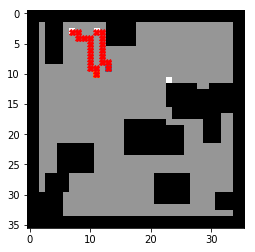

[3, 11]->[3, 12]->[4, 12]->[5, 12]->[6, 12]->[7, 12]->[8, 12]->[8, 13]->[9, 13]->End
[3, 7]->[3, 8]->[4, 8]->[4, 9]->[4, 10]->[5, 10]->[6, 10]->[7, 10]->[8, 10]->[9, 10]->[9, 11]->[10, 11]->End


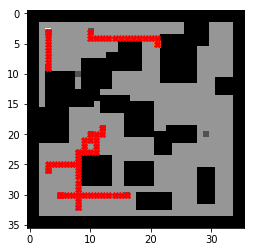

[3, 3]->[4, 3]->[5, 3]->[6, 3]->[7, 3]->[8, 3]->[9, 3]->End
[5, 21]->[4, 21]->[4, 20]->[4, 19]->[4, 18]->[4, 17]->[4, 16]->[4, 15]->[4, 14]->[4, 13]->[4, 12]->[4, 11]->[4, 10]->[3, 10]->End
[26, 3]->[25, 3]->[25, 4]->[25, 5]->[25, 6]->[25, 7]->[25, 8]->[24, 8]->[23, 8]->[23, 9]->[23, 10]->[23, 11]->[22, 11]->[21, 11]->[20, 11]->[20, 12]->[19, 12]->End
[30, 5]->[30, 6]->[30, 7]->[30, 8]->[30, 9]->[30, 10]->[30, 11]->[30, 12]->[30, 13]->[30, 14]->[30, 15]->[30, 16]->End
[32, 8]->[31, 8]->[30, 8]->[29, 8]->[28, 8]->[27, 8]->[26, 8]->[25, 8]->[24, 8]->[23, 8]->[23, 9]->[22, 9]->[21, 9]->[21, 10]->[20, 10]->End


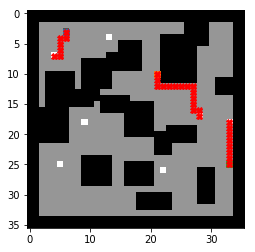

[7, 4]->[7, 5]->[6, 5]->[5, 5]->[4, 5]->[4, 6]->[3, 6]->End
[17, 28]->[16, 28]->[16, 27]->[15, 27]->[14, 27]->[13, 27]->[12, 27]->[12, 26]->[12, 25]->[12, 24]->[12, 23]->[12, 22]->[12, 21]->[11, 21]->[10, 21]->End
[18, 33]->[19, 33]->[20, 33]->[21, 33]->[22, 33]->[23, 33]->[24, 33]->[25, 33]->End


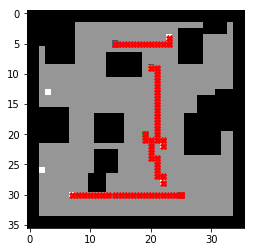

[4, 23]->[5, 23]->[5, 22]->[5, 21]->[5, 20]->[5, 19]->[5, 18]->[5, 17]->[5, 16]->[5, 15]->[5, 14]->End
[22, 22]->[21, 22]->[21, 21]->[20, 21]->[19, 21]->[18, 21]->[17, 21]->[16, 21]->[15, 21]->[14, 21]->[13, 21]->[12, 21]->[11, 21]->[10, 21]->[9, 21]->[9, 20]->End
[28, 22]->[27, 22]->[27, 21]->[26, 21]->[25, 21]->[24, 21]->[24, 20]->[23, 20]->[22, 20]->[21, 20]->[21, 19]->[20, 19]->End
[30, 7]->[30, 8]->[30, 9]->[30, 10]->[30, 11]->[30, 12]->[30, 13]->[30, 14]->[30, 15]->[30, 16]->[30, 17]->[30, 18]->[30, 19]->[30, 20]->[30, 21]->[30, 22]->[30, 23]->[30, 24]->[30, 25]->End


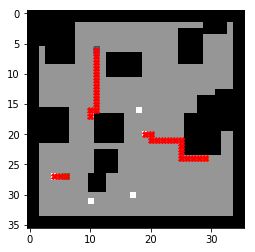

[17, 10]->[16, 10]->[16, 11]->[15, 11]->[14, 11]->[13, 11]->[12, 11]->[11, 11]->[10, 11]->[9, 11]->[8, 11]->[7, 11]->[6, 11]->End
[20, 19]->[20, 20]->[21, 20]->[21, 21]->[21, 22]->[21, 23]->[21, 24]->[21, 25]->[22, 25]->[23, 25]->[24, 25]->[24, 26]->[24, 27]->[24, 28]->[24, 29]->End
[27, 4]->[27, 5]->[27, 6]->End


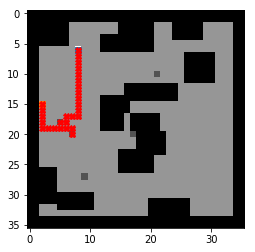

[6, 8]->[7, 8]->[8, 8]->[9, 8]->[10, 8]->[11, 8]->[12, 8]->[13, 8]->[14, 8]->[15, 8]->[16, 8]->[17, 8]->[17, 7]->[17, 6]->[18, 6]->[18, 5]->End
[15, 2]->[16, 2]->[17, 2]->[18, 2]->[19, 2]->[19, 3]->[19, 4]->[19, 5]->[19, 6]->[19, 7]->[20, 7]->End


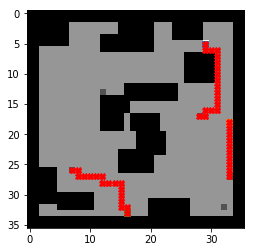

[5, 29]->[6, 29]->[6, 30]->[6, 31]->[7, 31]->[8, 31]->[9, 31]->[10, 31]->[11, 31]->[12, 31]->[13, 31]->[14, 31]->[15, 31]->[16, 31]->[16, 30]->[16, 29]->[17, 29]->[17, 28]->End
[18, 33]->[19, 33]->[20, 33]->[21, 33]->[22, 33]->[23, 33]->[24, 33]->[25, 33]->[26, 33]->[27, 33]->End
[33, 16]->[32, 16]->[32, 15]->[31, 15]->[30, 15]->[29, 15]->[28, 15]->[28, 14]->[28, 13]->[28, 12]->[27, 12]->[27, 11]->[27, 10]->[27, 9]->[27, 8]->[26, 8]->[26, 7]->End


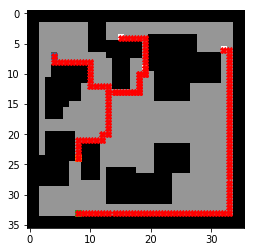

[4, 15]->[4, 16]->[4, 17]->[4, 18]->[4, 19]->[5, 19]->[6, 19]->[7, 19]->[8, 19]->[9, 19]->[10, 19]->[10, 18]->[11, 18]->[12, 18]->[13, 18]->[13, 17]->[13, 16]->[13, 15]->[13, 14]->[13, 13]->[12, 13]->[12, 12]->[12, 11]->[12, 10]->[11, 10]->[10, 10]->[9, 10]->[8, 10]->[8, 9]->[8, 8]->[8, 7]->[8, 6]->[8, 5]->[8, 4]->[7, 4]->End
[9, 19]->[10, 19]->[10, 18]->[11, 18]->[12, 18]->[13, 18]->[13, 17]->[13, 16]->[13, 15]->[13, 14]->[13, 13]->[14, 13]->[15, 13]->[16, 13]->[17, 13]->[18, 13]->[19, 13]->[20, 13]->[20, 12]->[21, 12]->[21, 11]->[21, 10]->[21, 9]->[21, 8]->[22, 8]->[23, 8]->[24, 8]->End
[6, 32]->[6, 33]->[7, 33]->[8, 33]->[9, 33]->[10, 33]->[11, 33]->[12, 33]->[13, 33]->[14, 33]->[15, 33]->[16, 33]->[17, 33]->[18, 33]->[19, 33]->[20, 33]->[21, 33]->[22, 33]->[23, 33]->[24, 33]->[25, 33]->[26, 33]->[27, 33]->[28, 33]->[29, 33]->[30, 33]->[31, 33]->[32, 33]->[33, 33]->[33, 32]->[33, 31]->[33, 30]->[33, 29]->[33, 28]->[33, 27]->[33, 26]->[33, 25]->[33, 24]->[33, 23]->[33, 22]->[33, 21]-

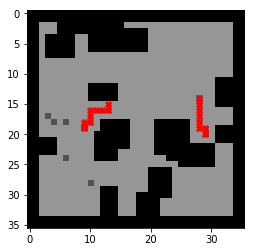

[14, 28]->[15, 28]->[16, 28]->[17, 28]->[18, 28]->[19, 28]->[19, 29]->[20, 29]->End
[15, 13]->[16, 13]->[16, 12]->[16, 11]->[16, 10]->[17, 10]->[18, 10]->[18, 9]->[19, 9]->End


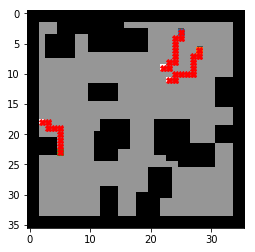

[9, 22]->[9, 23]->[8, 23]->[8, 24]->[7, 24]->[6, 24]->[5, 24]->[4, 24]->[4, 25]->[3, 25]->End
[11, 23]->[11, 24]->[10, 24]->[10, 25]->[10, 26]->[10, 27]->[9, 27]->[8, 27]->[7, 27]->[7, 28]->[6, 28]->End
[18, 2]->[18, 3]->[19, 3]->[19, 4]->[19, 5]->[20, 5]->[21, 5]->[22, 5]->[23, 5]->End


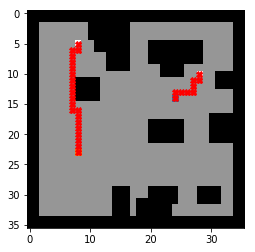

[10, 28]->[11, 28]->[11, 27]->[12, 27]->[13, 27]->[13, 26]->[13, 25]->[13, 24]->[14, 24]->End
[5, 8]->[6, 8]->[6, 7]->[7, 7]->[8, 7]->[9, 7]->[10, 7]->[11, 7]->[12, 7]->[13, 7]->[14, 7]->[15, 7]->[16, 7]->[16, 8]->[17, 8]->[18, 8]->[19, 8]->[20, 8]->[21, 8]->[22, 8]->[23, 8]->End


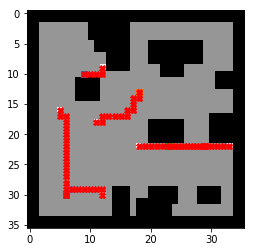

[9, 12]->[10, 12]->[10, 11]->[10, 10]->[10, 9]->End
[18, 11]->[18, 12]->[17, 12]->[17, 13]->[17, 14]->[17, 15]->[17, 16]->[16, 16]->[16, 17]->[15, 17]->[14, 17]->[14, 18]->[13, 18]->End
[22, 33]->[22, 32]->[22, 31]->[22, 30]->[22, 29]->[22, 28]->[22, 27]->[22, 26]->[22, 25]->[22, 24]->[22, 23]->End
[22, 18]->[22, 19]->[22, 20]->[22, 21]->[22, 22]->[22, 23]->[22, 24]->[22, 25]->[22, 26]->[22, 27]->[22, 28]->[22, 29]->End
[30, 12]->[29, 12]->[29, 11]->[29, 10]->[29, 9]->[29, 8]->[29, 7]->End
[16, 5]->[17, 5]->[17, 6]->[18, 6]->[19, 6]->[20, 6]->[21, 6]->[22, 6]->[23, 6]->[24, 6]->[25, 6]->[26, 6]->[27, 6]->[28, 6]->[29, 6]->[30, 6]->End


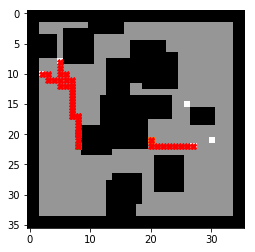

[10, 2]->[10, 3]->[11, 3]->[11, 4]->[11, 5]->[12, 5]->[12, 6]->[12, 7]->[13, 7]->[14, 7]->[15, 7]->[16, 7]->[17, 7]->[17, 8]->[18, 8]->[19, 8]->[20, 8]->End
[22, 27]->[22, 26]->[22, 25]->[22, 24]->[22, 23]->[22, 22]->[22, 21]->[22, 20]->[21, 20]->End
[8, 5]->[9, 5]->[10, 5]->[10, 6]->[11, 6]->[11, 7]->[12, 7]->[13, 7]->[14, 7]->[15, 7]->[16, 7]->[17, 7]->[17, 8]->[18, 8]->[19, 8]->[20, 8]->[21, 8]->[22, 8]->End


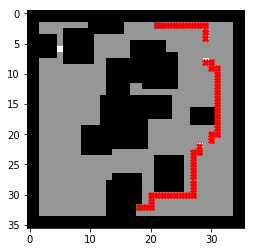

[4, 29]->[3, 29]->[2, 29]->[2, 28]->[2, 27]->[2, 26]->[2, 25]->[2, 24]->[2, 23]->[2, 22]->[2, 21]->End
[8, 29]->[8, 30]->[9, 30]->[9, 31]->[10, 31]->[11, 31]->[12, 31]->[13, 31]->[14, 31]->[15, 31]->[16, 31]->[17, 31]->[18, 31]->[19, 31]->[20, 31]->[20, 30]->[21, 30]->End
[22, 28]->[23, 28]->[23, 27]->[24, 27]->[25, 27]->[26, 27]->[27, 27]->[28, 27]->[29, 27]->[30, 27]->[30, 26]->[30, 25]->[30, 24]->[30, 23]->[30, 22]->[30, 21]->[30, 20]->[31, 20]->[32, 20]->[32, 19]->[32, 18]->End


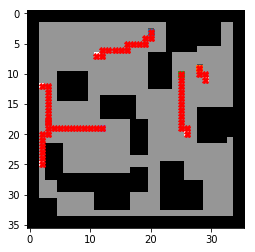

[7, 11]->[7, 12]->[6, 12]->[6, 13]->[6, 14]->[6, 15]->[6, 16]->[5, 16]->[5, 17]->[5, 18]->[5, 19]->[4, 19]->[4, 20]->[3, 20]->End
[11, 29]->[10, 29]->[10, 28]->[9, 28]->End
[20, 26]->[19, 26]->[19, 25]->[18, 25]->[17, 25]->[16, 25]->[15, 25]->[14, 25]->[13, 25]->[12, 25]->[11, 25]->[10, 25]->End
[12, 2]->[12, 3]->[13, 3]->[14, 3]->[15, 3]->[16, 3]->[17, 3]->[18, 3]->End
[25, 2]->[24, 2]->[23, 2]->[22, 2]->[21, 2]->[20, 2]->[20, 3]->[19, 3]->[19, 4]->[19, 5]->[19, 6]->[19, 7]->[19, 8]->[19, 9]->[19, 10]->[19, 11]->[19, 12]->End


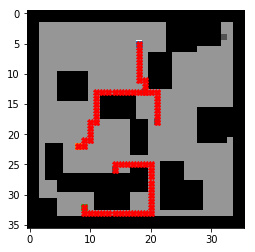

[5, 18]->[6, 18]->[7, 18]->[8, 18]->[9, 18]->[10, 18]->[11, 18]->[11, 19]->[12, 19]->[13, 19]->[13, 20]->[13, 21]->[14, 21]->[15, 21]->[16, 21]->[17, 21]->[18, 21]->End
[22, 8]->[22, 9]->[21, 9]->[21, 10]->[20, 10]->[19, 10]->[18, 10]->[18, 11]->[17, 11]->[16, 11]->[15, 11]->[14, 11]->[13, 11]->[13, 12]->[13, 13]->[13, 14]->[13, 15]->[13, 16]->[13, 17]->[13, 18]->[13, 19]->End
[32, 9]->[33, 9]->[33, 10]->[33, 11]->[33, 12]->[33, 13]->[33, 14]->[33, 15]->[33, 16]->[33, 17]->[33, 18]->[33, 19]->[33, 20]->[32, 20]->[31, 20]->[30, 20]->[29, 20]->[28, 20]->[27, 20]->[26, 20]->[25, 20]->[25, 19]->[25, 18]->[25, 17]->[25, 16]->[25, 15]->[25, 14]->[26, 14]->End


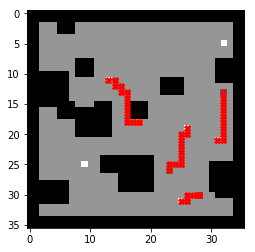

[21, 31]->[21, 32]->[20, 32]->[19, 32]->[18, 32]->[17, 32]->[16, 32]->[15, 32]->[14, 32]->[13, 32]->End
[11, 13]->[11, 14]->[12, 14]->[12, 15]->[13, 15]->[13, 16]->[14, 16]->[15, 16]->[16, 16]->[17, 16]->[18, 16]->[18, 17]->[18, 18]->End
[19, 26]->[20, 26]->[20, 25]->[21, 25]->[22, 25]->[23, 25]->[24, 25]->[25, 25]->[25, 24]->[25, 23]->[26, 23]->End
[31, 25]->[31, 26]->[30, 26]->[30, 27]->[30, 28]->End


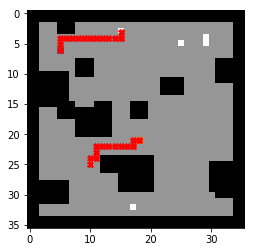

[3, 15]->[4, 15]->[4, 14]->[4, 13]->[4, 12]->[4, 11]->[4, 10]->[4, 9]->[4, 8]->[4, 7]->[4, 6]->[4, 5]->[5, 5]->[6, 5]->End
[25, 10]->[24, 10]->[24, 11]->[23, 11]->[22, 11]->[22, 12]->[22, 13]->[22, 14]->[22, 15]->[22, 16]->[22, 17]->[21, 17]->[21, 18]->End


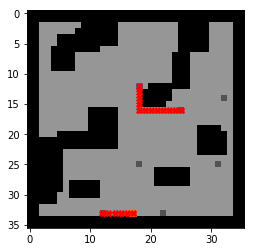

[12, 18]->[13, 18]->[14, 18]->[15, 18]->[16, 18]->[16, 19]->[16, 20]->[16, 21]->[16, 22]->[16, 23]->[16, 24]->[16, 25]->End
[33, 17]->[33, 16]->[33, 15]->[33, 14]->[33, 13]->[33, 12]->End


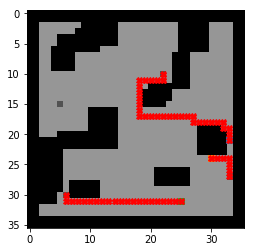

[21, 33]->[20, 33]->[19, 33]->[19, 32]->[18, 32]->[18, 31]->[18, 30]->[18, 29]->[18, 28]->[18, 27]->[17, 27]->[17, 26]->[17, 25]->[17, 24]->[17, 23]->[17, 22]->[17, 21]->[17, 20]->[17, 19]->[17, 18]->[16, 18]->[15, 18]->[14, 18]->[13, 18]->[12, 18]->[11, 18]->[11, 19]->[11, 20]->[11, 21]->[11, 22]->[10, 22]->End
[24, 30]->[24, 31]->[24, 32]->[24, 33]->[25, 33]->[26, 33]->[27, 33]->End
[31, 25]->[31, 24]->[31, 23]->[31, 22]->[31, 21]->[31, 20]->[31, 19]->[31, 18]->[31, 17]->[31, 16]->[31, 15]->[31, 14]->[31, 13]->[31, 12]->[31, 11]->[31, 10]->[31, 9]->[31, 8]->[31, 7]->[31, 6]->[30, 6]->End


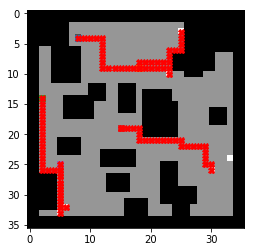

[10, 23]->[9, 23]->[9, 22]->[9, 21]->[9, 20]->[9, 19]->[9, 18]->[9, 17]->[9, 16]->[9, 15]->[9, 14]->[9, 13]->[9, 12]->[8, 12]->[7, 12]->[6, 12]->[5, 12]->[4, 12]->[4, 11]->[4, 10]->[4, 9]->[4, 8]->End
[3, 25]->[4, 25]->[5, 25]->[6, 25]->[6, 24]->[6, 23]->[7, 23]->[8, 23]->[8, 22]->[8, 21]->[8, 20]->[8, 19]->[8, 18]->[9, 18]->End
[33, 5]->[32, 5]->[31, 5]->[30, 5]->[29, 5]->[28, 5]->[27, 5]->[26, 5]->[26, 4]->[26, 3]->[26, 2]->[25, 2]->[24, 2]->[23, 2]->[22, 2]->[21, 2]->[20, 2]->[19, 2]->[18, 2]->[17, 2]->[16, 2]->[15, 2]->[14, 2]->End
[26, 30]->[25, 30]->[25, 29]->[24, 29]->[23, 29]->[22, 29]->[22, 28]->[22, 27]->[22, 26]->[22, 25]->[21, 25]->[21, 24]->[21, 23]->[21, 22]->[21, 21]->[21, 20]->[21, 19]->[21, 18]->[20, 18]->[19, 18]->[19, 17]->[19, 16]->[19, 15]->End
[32, 6]->[32, 5]->[31, 5]->[30, 5]->[29, 5]->[28, 5]->[27, 5]->[26, 5]->[25, 5]->End


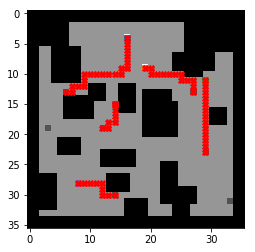

[4, 16]->[5, 16]->[6, 16]->[7, 16]->[8, 16]->[9, 16]->[9, 15]->[10, 15]->[10, 14]->[10, 13]->[10, 12]->[10, 11]->[10, 10]->[10, 9]->[11, 9]->[12, 9]->[12, 8]->[12, 7]->[13, 7]->[13, 6]->End
[9, 19]->[9, 20]->[10, 20]->[10, 21]->[10, 22]->[10, 23]->[10, 24]->[10, 25]->[11, 25]->[11, 26]->[11, 27]->[12, 27]->[13, 27]->End
[11, 29]->[12, 29]->[13, 29]->[14, 29]->[15, 29]->[16, 29]->[17, 29]->[18, 29]->[19, 29]->[20, 29]->[21, 29]->[22, 29]->[23, 29]->End
[15, 14]->[16, 14]->[17, 14]->[18, 14]->[18, 13]->[19, 13]->[19, 12]->End
[28, 8]->[28, 9]->[28, 10]->[28, 11]->[28, 12]->[29, 12]->[30, 12]->[30, 13]->[30, 14]->End


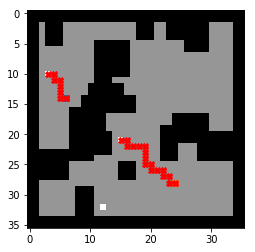

[10, 3]->[10, 4]->[11, 4]->[11, 5]->[12, 5]->[13, 5]->[14, 5]->[14, 6]->End
[21, 15]->[21, 16]->[22, 16]->[22, 17]->[22, 18]->[22, 19]->[23, 19]->[24, 19]->[25, 19]->[25, 20]->[26, 20]->[26, 21]->[26, 22]->[27, 22]->[27, 23]->[28, 23]->[28, 24]->End


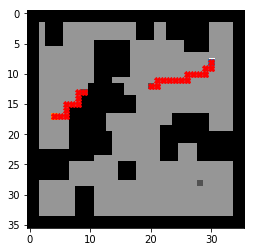

[8, 30]->[9, 30]->[9, 29]->[10, 29]->[10, 28]->[10, 27]->[10, 26]->[11, 26]->[11, 25]->[11, 24]->[11, 23]->[11, 22]->[11, 21]->[12, 21]->[12, 20]->End
[17, 4]->[17, 5]->[17, 6]->[16, 6]->[15, 6]->[15, 7]->[15, 8]->[14, 8]->[13, 8]->[13, 9]->End
Goal Accuracy: 1.0
174.0 174.0
Average traj step length : 20.96
1048.0 50


In [123]:
correct,total,traj_step = 0.0,0.0,0.0   
imsize = 36
max_rand_play= 0
memory = []
for i in range(50):
    if i == 32 :
      continue
    
    X = test_data[i][0].clone()
    
    Y = torch.zeros([3,36,36])
    
    Y[:,2:34,2:34] = X.clone()
    
    go = np.where(Y[1] == 1.0)
    goal = np.column_stack([go[0],go[1]])
    
  
        
    #current_goal,current_total,traj,memory = agent_predict(model_28x28,Y.clone(),goal,imsize,max_rand_play)
    #correct_goal,total_goal, traj_length,traj = agent_prediction(model_32x32,Y.clone(),[],goal,imsize,0)
    correct_goal,total_goal, traj_length,traj,change = cooperative(model=model_32x32,X=Y.clone(),imsize=imsize)
    
    dom = Y[0] - 0.5 * Y[1] + Y[2]
    visualization(dom,traj)
        
    if change == 1:
        for i in traj:
            L = len(i[0])
            for j in range(L-1,-1,-1):
                print([i[0][j][0].item(),i[0][j][1].item()],end='->')
            print("End")
    else :
        for i in traj:
            for j in i[0]:
                print([j[0].item(),j[1].item()],end='->')
            print("End")
    
    correct += correct_goal
    total += total_goal
    traj_step += traj_length
    
print(f'Goal Accuracy: {correct/total}')
print(correct,total)
print(f'Average traj step length : {traj_step/50}')
print(traj_step,50)

In [0]:
test = []
with np.load('Env_64x64.npz', mmap_mode='r',allow_pickle=True) as f:
    test = f['arr_0']

In [0]:
test_data = []

for i in test:
    env = -1 *(i[0] == 0) + 1.0
    goal = (i[0] == 0.5) + 0.0
    Agent = i[1]
    domain = np.array([env,goal,Agent])
    
    test_data.append([torch.tensor(domain.copy())])

In [126]:
model_64x64 = MA_P(80,68)
model_64x64.load_state_dict(torch.load('MA_P_2_9_2.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [127]:
model_64x64.cuda()

MA_P(
  (h): Conv2d(3, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (r): Conv2d(150, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (q): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (sm): Softmax()
)

In [0]:
correct,total,traj_step = 0.0,0.0,0.0   
imsize = 68
max_rand_play= 0
memory = []
for i in range(50):
    if i == 27 :
      continue
    
    X = test_data[i][0].clone()
    
    Y = torch.zeros([3,68,68])
    
    Y[:,2:66,2:66] = X.clone()
    
    go = np.where(Y[1] == 1.0)
    goal = np.column_stack([go[0],go[1]])
    
  
        
    #current_goal,current_total,traj,memory = agent_predict(model_28x28,Y.clone(),goal,imsize,max_rand_play)
    correct_goal,total_goal, traj_length,traj = agent_prediction(model_64x64,Y.clone(),[],goal,imsize,0)
    #correct_goal,total_goal, traj_length,traj = cooperative(model=model_64x64,X=Y.clone(),imsize=imsize)
    
    #for j in traj:
     # for k in j:
      #   print(k,end="->")
      #print("End")
      
    #print(i,correct_goal,total_goal)
    
    correct += correct_goal
    total += total_goal
    traj_step += traj_length
    
print(f'Goal Accuracy: {correct/total}')
print(correct,total)
print(f'Average traj step length : {traj_step/50}')
print(traj_step,50)

Goal Accuracy: 0.5263157894736842
110.0 209.0
Average traj step length : 20.34
1017.0 50


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


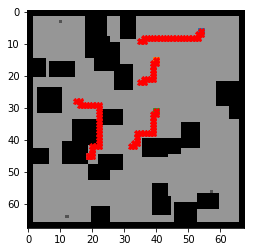

[6, 54]->[7, 54]->[7, 53]->[8, 53]->[8, 52]->[8, 51]->[8, 50]->[8, 49]->[8, 48]->[8, 47]->[8, 46]->[8, 45]->[8, 44]->[8, 43]->[8, 42]->[8, 41]->[8, 40]->[8, 39]->[8, 38]->[8, 37]->[8, 36]->[9, 36]->[9, 35]->End
[15, 40]->[16, 40]->[16, 39]->[17, 39]->[18, 39]->[19, 39]->[20, 39]->[21, 39]->[21, 38]->[21, 37]->[21, 36]->[22, 36]->[22, 35]->End
[31, 40]->[32, 40]->[32, 39]->[33, 39]->[34, 39]->[35, 39]->[36, 39]->[37, 39]->[38, 39]->[38, 38]->[38, 37]->[38, 36]->[38, 35]->[38, 34]->[39, 34]->[40, 34]->[41, 34]->[41, 33]->[42, 33]->[42, 32]->End
[45, 19]->[45, 20]->[44, 20]->[43, 20]->[42, 20]->[42, 21]->[42, 22]->[41, 22]->[40, 22]->[39, 22]->[38, 22]->[37, 22]->[36, 22]->[35, 22]->[34, 22]->[33, 22]->[32, 22]->[31, 22]->[30, 22]->[29, 22]->[29, 21]->[29, 20]->[29, 19]->[29, 18]->[29, 17]->[29, 16]->[28, 16]->[28, 15]->End


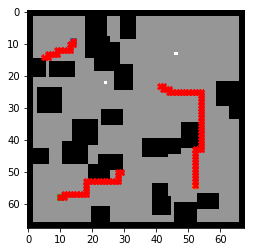

[14, 5]->[14, 6]->[13, 6]->[13, 7]->[13, 8]->[13, 9]->[12, 9]->[12, 10]->[12, 11]->[12, 12]->[12, 13]->[11, 13]->[10, 13]->[10, 14]->[9, 14]->End
[23, 41]->[23, 42]->[24, 42]->[24, 43]->[24, 44]->[25, 44]->[25, 45]->[25, 46]->[25, 47]->[25, 48]->[25, 49]->[25, 50]->[25, 51]->[25, 52]->[25, 53]->[25, 54]->[26, 54]->[27, 54]->[28, 54]->[29, 54]->[30, 54]->[31, 54]->[32, 54]->[33, 54]->[34, 54]->[35, 54]->[36, 54]->[37, 54]->[38, 54]->[39, 54]->[40, 54]->[41, 54]->[42, 54]->[43, 54]->[43, 53]->[43, 52]->[44, 52]->[45, 52]->[46, 52]->[47, 52]->[48, 52]->[49, 52]->[50, 52]->[51, 52]->[52, 52]->[53, 52]->[54, 52]->End
[50, 29]->[50, 28]->[51, 28]->[52, 28]->[53, 28]->[53, 27]->[53, 26]->[53, 25]->[53, 24]->[53, 23]->[53, 22]->[53, 21]->[53, 20]->[53, 19]->[53, 18]->[54, 18]->[55, 18]->[56, 18]->[57, 18]->[57, 17]->[57, 16]->[57, 15]->[57, 14]->[57, 13]->[57, 12]->[57, 11]->[58, 11]->[58, 10]->End


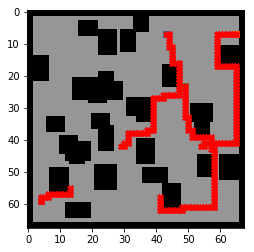

[42, 29]->[42, 30]->[41, 30]->[41, 31]->[40, 31]->[39, 31]->[38, 31]->[38, 32]->[38, 33]->[38, 34]->[38, 35]->[38, 36]->[38, 37]->[37, 37]->[37, 38]->[37, 39]->[36, 39]->[35, 39]->[34, 39]->[33, 39]->[32, 39]->[31, 39]->[30, 39]->[29, 39]->[28, 39]->[27, 39]->[27, 40]->[27, 41]->[27, 42]->[26, 42]->[26, 43]->[26, 44]->[26, 45]->[26, 46]->[26, 47]->[25, 47]->[24, 47]->[23, 47]->[22, 47]->[21, 47]->[20, 47]->[19, 47]->[18, 47]->[17, 47]->[16, 47]->[16, 46]->[16, 45]->[15, 45]->[14, 45]->[13, 45]->[12, 45]->[11, 45]->[11, 44]->[10, 44]->[9, 44]->[8, 44]->[7, 44]->[7, 43]->End
[42, 54]->[42, 55]->[41, 55]->[41, 56]->[41, 57]->[41, 58]->[41, 59]->[41, 60]->[41, 61]->[41, 62]->[41, 63]->[41, 64]->[41, 65]->[40, 65]->[39, 65]->[38, 65]->[37, 65]->[36, 65]->[35, 65]->[34, 65]->[33, 65]->[32, 65]->[31, 65]->[30, 65]->[29, 65]->[28, 65]->[27, 65]->[26, 65]->[25, 65]->[24, 65]->[23, 65]->[22, 65]->[21, 65]->[20, 65]->[19, 65]->[18, 65]->[17, 65]->[17, 64]->[17, 63]->[17, 62]->[17, 61]->[17, 60]->

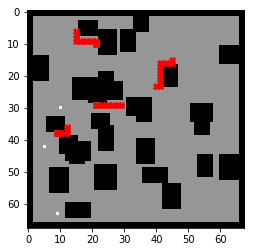

[6, 15]->[7, 15]->[8, 15]->[9, 15]->[9, 16]->[9, 17]->[9, 18]->[9, 19]->[9, 20]->[9, 21]->[10, 21]->End
[15, 45]->[16, 45]->[16, 44]->[16, 43]->[16, 42]->[16, 41]->[17, 41]->[18, 41]->[19, 41]->[20, 41]->[21, 41]->[22, 41]->[23, 41]->[23, 40]->End
[29, 29]->[29, 28]->[29, 27]->[29, 26]->[29, 25]->[29, 24]->[29, 23]->[29, 22]->[29, 21]->End
[36, 12]->[37, 12]->[38, 12]->[38, 11]->[38, 10]->[38, 9]->End


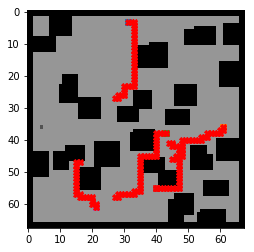

[3, 31]->[3, 32]->[3, 33]->[4, 33]->[5, 33]->[6, 33]->[7, 33]->[8, 33]->[9, 33]->[10, 33]->[11, 33]->[12, 33]->[13, 33]->[14, 33]->[15, 33]->[16, 33]->[17, 33]->[18, 33]->[19, 33]->[20, 33]->[21, 33]->[22, 33]->[23, 33]->[23, 32]->[23, 31]->[23, 30]->[24, 30]->[25, 30]->[26, 30]->[26, 29]->[26, 28]->[27, 28]->[27, 27]->End
[36, 61]->[37, 61]->[37, 60]->[38, 60]->[38, 59]->[38, 58]->[38, 57]->[38, 56]->[39, 56]->[39, 55]->[39, 54]->[40, 54]->[40, 53]->[40, 52]->[40, 51]->[40, 50]->[40, 49]->[40, 48]->[41, 48]->[42, 48]->[43, 48]->[44, 48]->[45, 48]->[45, 47]->[45, 46]->[46, 46]->[46, 45]->End
[38, 43]->[38, 42]->[38, 41]->[38, 40]->[39, 40]->[40, 40]->[41, 40]->[42, 40]->[43, 40]->[44, 40]->[45, 40]->[45, 39]->[45, 38]->[45, 37]->[45, 36]->[45, 35]->[46, 35]->[47, 35]->[48, 35]->[49, 35]->[50, 35]->[51, 35]->[52, 35]->[53, 35]->[54, 35]->[55, 35]->[56, 35]->[56, 34]->[56, 33]->[57, 33]->[57, 32]->[57, 31]->[57, 30]->[57, 29]->[57, 28]->[58, 28]->[58, 27]->End
[55, 40]->[55, 41]->[55, 42

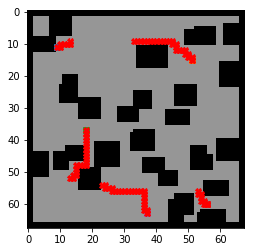

[9, 13]->[10, 13]->[10, 12]->[10, 11]->[10, 10]->[11, 10]->[11, 9]->End
[9, 33]->[9, 34]->[9, 35]->[9, 36]->[9, 37]->[9, 38]->[9, 39]->[9, 40]->[9, 41]->[9, 42]->[9, 43]->[9, 44]->[9, 45]->[10, 45]->[10, 46]->[11, 46]->[12, 46]->[12, 47]->[12, 48]->[12, 49]->[13, 49]->[13, 50]->[14, 50]->[14, 51]->[15, 51]->End
[52, 13]->[52, 14]->[51, 14]->[51, 15]->[50, 15]->[49, 15]->[48, 15]->[48, 16]->[48, 17]->[48, 18]->[47, 18]->[46, 18]->[45, 18]->[44, 18]->[43, 18]->[42, 18]->[41, 18]->[40, 18]->[39, 18]->[38, 18]->[37, 18]->End
[56, 53]->[57, 53]->[57, 54]->[58, 54]->[59, 54]->[59, 55]->[60, 55]->[60, 56]->End
[54, 23]->[54, 24]->[55, 24]->[55, 25]->[55, 26]->[56, 26]->[56, 27]->[56, 28]->[56, 29]->[56, 30]->[56, 31]->[56, 32]->[56, 33]->[56, 34]->[56, 35]->[56, 36]->[57, 36]->[58, 36]->[59, 36]->[60, 36]->[61, 36]->[62, 36]->[62, 37]->[63, 37]->End


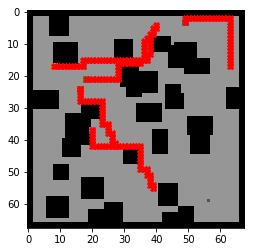

[3, 49]->[2, 49]->[2, 50]->[2, 51]->[2, 52]->[2, 53]->[2, 54]->[2, 55]->[2, 56]->[2, 57]->[2, 58]->[2, 59]->[2, 60]->[2, 61]->[2, 62]->[2, 63]->[3, 63]->[4, 63]->[5, 63]->[6, 63]->[7, 63]->[8, 63]->[9, 63]->[10, 63]->[11, 63]->[12, 63]->[13, 63]->[14, 63]->[15, 63]->[16, 63]->[17, 63]->End
[17, 8]->[17, 9]->[17, 10]->[17, 11]->[17, 12]->[17, 13]->[17, 14]->[17, 15]->[17, 16]->[17, 17]->[16, 17]->[15, 17]->[15, 18]->[15, 19]->[15, 20]->[15, 21]->[15, 22]->[15, 23]->[15, 24]->[15, 25]->[15, 26]->[15, 27]->[15, 28]->[15, 29]->[15, 30]->[15, 31]->[15, 32]->[15, 33]->[15, 34]->[15, 35]->[15, 36]->[14, 36]->[13, 36]->[12, 36]->[11, 36]->[10, 36]->[9, 36]->[9, 37]->[8, 37]->End
[21, 18]->[21, 19]->[21, 20]->[21, 21]->[21, 22]->[21, 23]->[21, 24]->[21, 25]->[21, 26]->[21, 27]->[21, 28]->[20, 28]->[19, 28]->[18, 28]->[17, 28]->[16, 28]->[16, 29]->[16, 30]->[16, 31]->[16, 32]->[16, 33]->[16, 34]->[16, 35]->[15, 35]->[15, 36]->[15, 37]->[14, 37]->[13, 37]->[13, 38]->[12, 38]->[11, 38]->[10, 38]->

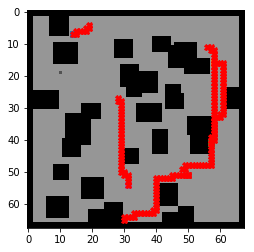

[7, 14]->[7, 15]->[6, 15]->[6, 16]->[6, 17]->[6, 18]->[5, 18]->[5, 19]->[4, 19]->End
[16, 58]->[16, 59]->[16, 60]->[16, 61]->[17, 61]->[18, 61]->[19, 61]->[20, 61]->[21, 61]->[22, 61]->[23, 61]->[24, 61]->[25, 61]->[26, 61]->[27, 61]->[28, 61]->[29, 61]->[30, 61]->[31, 61]->[32, 61]->[32, 60]->[33, 60]->[33, 59]->[33, 58]->[34, 58]->[35, 58]->[36, 58]->[37, 58]->[38, 58]->[39, 58]->[40, 58]->[40, 57]->[41, 57]->[42, 57]->[43, 57]->[44, 57]->[45, 57]->[46, 57]->[47, 57]->[48, 57]->[48, 56]->[48, 55]->[48, 54]->[48, 53]->[48, 52]->[48, 51]->[48, 50]->[48, 49]->[49, 49]->[49, 48]->End
[41, 57]->[40, 57]->[39, 57]->[39, 58]->[38, 58]->[37, 58]->[36, 58]->[35, 58]->[34, 58]->[33, 58]->[32, 58]->[31, 58]->[30, 58]->[29, 58]->[28, 58]->[27, 58]->[26, 58]->[25, 58]->[24, 58]->[23, 58]->[22, 58]->[21, 58]->[20, 58]->[19, 58]->[18, 58]->[17, 58]->[16, 58]->[15, 58]->[14, 58]->[13, 58]->[12, 58]->[12, 57]->[11, 57]->[11, 56]->End
[51, 50]->[51, 49]->[51, 48]->[51, 47]->[51, 46]->[51, 45]->[52, 45

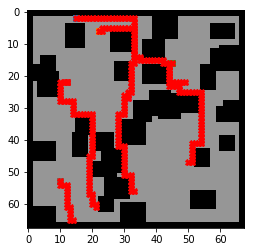

[26, 30]->[26, 31]->[25, 31]->[25, 32]->[24, 32]->[23, 32]->[22, 32]->[21, 32]->[20, 32]->[19, 32]->[18, 32]->[17, 32]->[16, 32]->[16, 33]->[15, 33]->[14, 33]->[13, 33]->[12, 33]->[11, 33]->[10, 33]->[9, 33]->[8, 33]->[7, 33]->[6, 33]->[5, 33]->[4, 33]->[3, 33]->[2, 33]->[2, 32]->[2, 31]->[2, 30]->[2, 29]->[2, 28]->[2, 27]->[2, 26]->[2, 25]->[2, 24]->[2, 23]->[2, 22]->[2, 21]->[2, 20]->[2, 19]->[2, 18]->[2, 17]->[2, 16]->[2, 15]->End
[22, 49]->[22, 48]->[22, 47]->[22, 46]->[22, 45]->[22, 44]->[21, 44]->[20, 44]->[19, 44]->[18, 44]->[17, 44]->[16, 44]->[16, 43]->[16, 42]->[15, 42]->[15, 41]->[15, 40]->[15, 39]->[15, 38]->[15, 37]->[15, 36]->[15, 35]->[14, 35]->[14, 34]->[14, 33]->[13, 33]->[12, 33]->[11, 33]->[10, 33]->[9, 33]->[8, 33]->[7, 33]->[6, 33]->[5, 33]->[5, 32]->[5, 31]->[5, 30]->[5, 29]->[5, 28]->[5, 27]->[5, 26]->[5, 25]->[5, 24]->[5, 23]->[6, 23]->[6, 22]->End
[47, 50]->[47, 51]->[46, 51]->[45, 51]->[44, 51]->[43, 51]->[42, 51]->[41, 51]->[41, 52]->[41, 53]->[41, 54]->[40, 

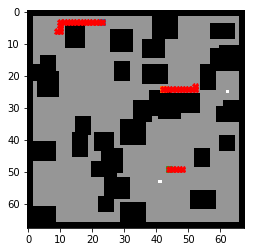

[6, 9]->[6, 10]->[5, 10]->[4, 10]->[3, 10]->[3, 11]->[3, 12]->[3, 13]->[3, 14]->[3, 15]->[3, 16]->[3, 17]->[3, 18]->[3, 19]->[3, 20]->[3, 21]->[3, 22]->[3, 23]->End
[23, 52]->[24, 52]->[24, 51]->[24, 50]->[24, 49]->[24, 48]->[24, 47]->[24, 46]->[24, 45]->[24, 44]->[24, 43]->[24, 42]->End
[49, 48]->[49, 47]->[49, 46]->[49, 45]->[49, 44]->End


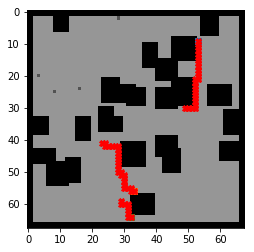

[9, 53]->[10, 53]->[11, 53]->[12, 53]->[13, 53]->[14, 53]->[15, 53]->[16, 53]->[17, 53]->[18, 53]->[19, 53]->[20, 53]->[21, 53]->[21, 52]->[22, 52]->[23, 52]->[24, 52]->[25, 52]->[26, 52]->[27, 52]->[28, 52]->[29, 52]->[30, 52]->[30, 51]->[30, 50]->[30, 49]->End
[56, 33]->[56, 32]->[55, 32]->[55, 31]->[55, 30]->[54, 30]->[53, 30]->[52, 30]->[51, 30]->[51, 29]->[50, 29]->[50, 28]->[49, 28]->[48, 28]->[47, 28]->[46, 28]->[45, 28]->[44, 28]->[43, 28]->[42, 28]->[42, 27]->[42, 26]->[42, 25]->[42, 24]->[41, 24]->[41, 23]->End
[64, 32]->[64, 31]->[63, 31]->[62, 31]->[61, 31]->[60, 31]->[60, 30]->[60, 29]->[59, 29]->End


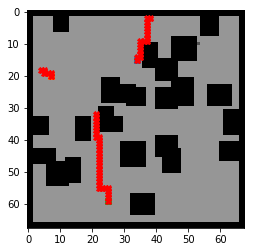

[15, 34]->[14, 34]->[14, 35]->[13, 35]->[12, 35]->[11, 35]->[10, 35]->[9, 35]->[9, 36]->[9, 37]->[8, 37]->[7, 37]->[6, 37]->[5, 37]->[4, 37]->[3, 37]->[2, 37]->[2, 38]->End
[20, 7]->[19, 7]->[19, 6]->[19, 5]->[18, 5]->[18, 4]->End
[59, 25]->[58, 25]->[57, 25]->[56, 25]->[55, 25]->[55, 24]->[55, 23]->[55, 22]->[54, 22]->[53, 22]->[52, 22]->[51, 22]->[50, 22]->[49, 22]->[48, 22]->[47, 22]->[46, 22]->[45, 22]->[44, 22]->[43, 22]->[42, 22]->[41, 22]->[40, 22]->[39, 22]->[39, 21]->[38, 21]->[37, 21]->[36, 21]->[35, 21]->[34, 21]->[33, 21]->[32, 21]->End


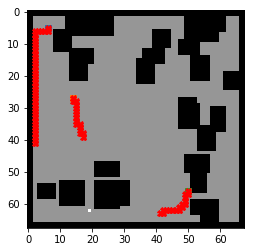

[41, 2]->[40, 2]->[39, 2]->[38, 2]->[37, 2]->[36, 2]->[35, 2]->[34, 2]->[33, 2]->[32, 2]->[31, 2]->[30, 2]->[29, 2]->[28, 2]->[27, 2]->[26, 2]->[25, 2]->[24, 2]->[23, 2]->[22, 2]->[21, 2]->[20, 2]->[19, 2]->[18, 2]->[17, 2]->[16, 2]->[15, 2]->[14, 2]->[13, 2]->[12, 2]->[11, 2]->[10, 2]->[9, 2]->[8, 2]->[7, 2]->[6, 2]->[6, 3]->[6, 4]->[6, 5]->[6, 6]->[5, 6]->End
[39, 17]->[38, 17]->[38, 16]->[37, 16]->[36, 16]->[35, 16]->[35, 15]->[34, 15]->[33, 15]->[32, 15]->[31, 15]->[30, 15]->[29, 15]->[28, 15]->[28, 14]->[27, 14]->End
[63, 41]->[63, 42]->[62, 42]->[62, 43]->[62, 44]->[62, 45]->[62, 46]->[62, 47]->[61, 47]->[61, 48]->[60, 48]->[60, 49]->[59, 49]->[58, 49]->[57, 49]->[57, 50]->[56, 50]->End


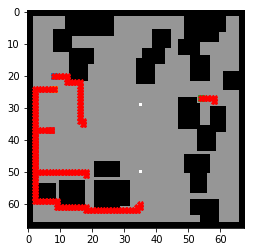

[35, 17]->[34, 17]->[34, 16]->[33, 16]->[32, 16]->[31, 16]->[30, 16]->[29, 16]->[28, 16]->[27, 16]->[26, 16]->[25, 16]->[24, 16]->[23, 16]->[22, 16]->[22, 15]->[22, 14]->[22, 13]->[22, 12]->[21, 12]->[20, 12]->[20, 11]->[20, 10]->[20, 9]->[20, 8]->End
[51, 18]->[50, 18]->[50, 17]->[50, 16]->[50, 15]->[50, 14]->[50, 13]->[50, 12]->[50, 11]->[50, 10]->[50, 9]->[50, 8]->[50, 7]->[50, 6]->[50, 5]->[50, 4]->[50, 3]->[50, 2]->[49, 2]->[48, 2]->[47, 2]->[46, 2]->[45, 2]->[44, 2]->[43, 2]->[42, 2]->[41, 2]->[40, 2]->[39, 2]->[38, 2]->[37, 2]->[36, 2]->[35, 2]->[34, 2]->[33, 2]->[32, 2]->[31, 2]->[30, 2]->[29, 2]->[28, 2]->[27, 2]->[26, 2]->[25, 2]->[24, 2]->[24, 3]->[24, 4]->[24, 5]->[24, 6]->[24, 7]->[24, 8]->End
[28, 58]->[27, 58]->[27, 57]->[27, 56]->[27, 55]->[27, 54]->End
[60, 35]->[61, 35]->[61, 34]->[62, 34]->[62, 33]->[62, 32]->[62, 31]->[62, 30]->[62, 29]->[62, 28]->[62, 27]->[62, 26]->[62, 25]->[62, 24]->[62, 23]->[62, 22]->[62, 21]->[62, 20]->[62, 19]->[62, 18]->[61, 18]->[61, 17]->

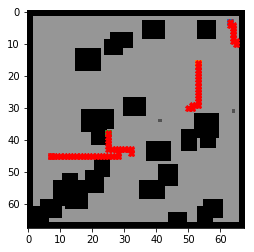

[3, 63]->[4, 63]->[4, 64]->[5, 64]->[6, 64]->[7, 64]->[8, 64]->[9, 64]->[9, 65]->[10, 65]->End
[16, 53]->[17, 53]->[18, 53]->[19, 53]->[20, 53]->[21, 53]->[22, 53]->[23, 53]->[24, 53]->[25, 53]->[26, 53]->[27, 53]->[28, 53]->[29, 53]->[29, 52]->[29, 51]->[30, 51]->[30, 50]->End
[38, 25]->[39, 25]->[40, 25]->[41, 25]->[42, 25]->[43, 25]->[43, 26]->[43, 27]->[43, 28]->[43, 29]->[43, 30]->[43, 31]->[43, 32]->[44, 32]->End
[45, 7]->[45, 8]->[45, 9]->[45, 10]->[45, 11]->[45, 12]->[45, 13]->[45, 14]->[45, 15]->[45, 16]->[45, 17]->[45, 18]->[45, 19]->[45, 20]->[45, 21]->[45, 22]->[45, 23]->[45, 24]->[45, 25]->[45, 26]->[45, 27]->[45, 28]->[44, 28]->End


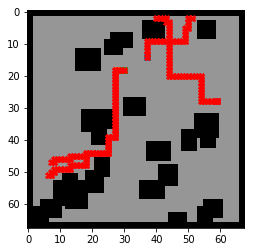

[2, 51]->[2, 50]->[3, 50]->[4, 50]->[5, 50]->[5, 49]->[6, 49]->[7, 49]->[8, 49]->[9, 49]->[9, 48]->[9, 47]->[9, 46]->[9, 45]->[9, 44]->[9, 43]->[9, 42]->[9, 41]->[9, 40]->[9, 39]->[9, 38]->[9, 37]->[10, 37]->[11, 37]->[12, 37]->[13, 37]->[14, 37]->End
[51, 6]->[51, 7]->[50, 7]->[50, 8]->[49, 8]->[49, 9]->[49, 10]->[49, 11]->[49, 12]->[49, 13]->[48, 13]->[48, 14]->[48, 15]->[48, 16]->[48, 17]->[48, 18]->[47, 18]->[46, 18]->[45, 18]->[44, 18]->[44, 19]->[44, 20]->[44, 21]->[44, 22]->[44, 23]->[44, 24]->[44, 25]->[43, 25]->[42, 25]->[41, 25]->[40, 25]->[39, 25]->[39, 26]->[39, 27]->[38, 27]->[37, 27]->[36, 27]->[35, 27]->[34, 27]->[33, 27]->[32, 27]->[31, 27]->[30, 27]->[29, 27]->[28, 27]->[27, 27]->[26, 27]->[25, 27]->[24, 27]->[23, 27]->[22, 27]->[21, 27]->[20, 27]->[19, 27]->[18, 27]->[18, 28]->End
[47, 7]->[47, 8]->[46, 8]->[46, 9]->[46, 10]->[46, 11]->[46, 12]->[46, 13]->[45, 13]->[45, 14]->[45, 15]->[45, 16]->[45, 17]->[45, 18]->[44, 18]->[44, 19]->[44, 20]->[44, 21]->[44, 22]->[44,

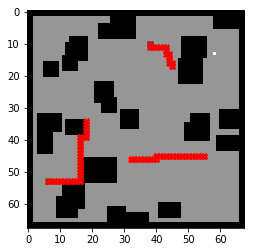

[17, 45]->[16, 45]->[16, 44]->[15, 44]->[14, 44]->[13, 44]->[13, 43]->[12, 43]->[11, 43]->[11, 42]->[11, 41]->[11, 40]->[11, 39]->[11, 38]->[10, 38]->End
[45, 55]->[45, 54]->[45, 53]->[45, 52]->[45, 51]->[45, 50]->[45, 49]->[45, 48]->[45, 47]->[45, 46]->[45, 45]->[45, 44]->[45, 43]->[45, 42]->[45, 41]->[45, 40]->[46, 40]->[46, 39]->[46, 38]->[46, 37]->[46, 36]->[46, 35]->[46, 34]->[46, 33]->[46, 32]->End
[34, 18]->[35, 18]->[36, 18]->[37, 18]->[38, 18]->[39, 18]->[39, 17]->[39, 16]->[40, 16]->[41, 16]->[42, 16]->[43, 16]->[44, 16]->[45, 16]->[46, 16]->[47, 16]->[48, 16]->[49, 16]->[50, 16]->[51, 16]->[52, 16]->[53, 16]->[53, 15]->[53, 14]->[53, 13]->[53, 12]->[53, 11]->[53, 10]->[53, 9]->[53, 8]->[53, 7]->[53, 6]->End


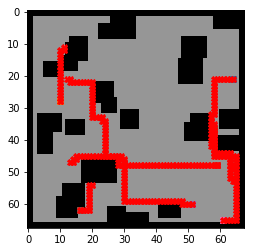

[49, 64]->[48, 64]->[48, 63]->[47, 63]->[46, 63]->[45, 63]->[44, 63]->[44, 62]->[44, 61]->[44, 60]->[44, 59]->[44, 58]->[43, 58]->[42, 58]->[42, 57]->[41, 57]->[40, 57]->[39, 57]->[38, 57]->[37, 57]->[36, 57]->[35, 57]->[34, 57]->[33, 57]->[32, 57]->[32, 58]->[31, 58]->[30, 58]->[29, 58]->[28, 58]->[27, 58]->[26, 58]->[25, 58]->[24, 58]->[23, 58]->[22, 58]->[21, 58]->[21, 59]->[21, 60]->[21, 61]->[21, 62]->[21, 63]->[21, 64]->End
[11, 11]->[12, 11]->[12, 10]->[13, 10]->[14, 10]->[15, 10]->[16, 10]->[17, 10]->[18, 10]->[19, 10]->[20, 10]->[21, 10]->[22, 10]->[23, 10]->[24, 10]->[25, 10]->[26, 10]->[27, 10]->[28, 10]->End
[53, 64]->[52, 64]->[52, 63]->[51, 63]->[50, 63]->[49, 63]->[48, 63]->[47, 63]->[46, 63]->[45, 63]->[44, 63]->[44, 62]->[44, 61]->[44, 60]->[44, 59]->[44, 58]->[43, 58]->[42, 58]->[41, 58]->[40, 58]->[39, 58]->[38, 58]->[37, 58]->End
[21, 12]->[21, 13]->[22, 13]->[22, 14]->[22, 15]->[22, 16]->[22, 17]->[22, 18]->[22, 19]->[22, 20]->[23, 20]->[24, 20]->[25, 20]->[26, 20]

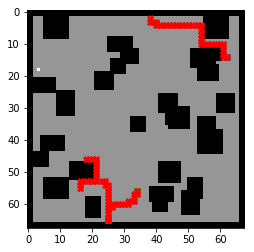

[2, 38]->[3, 38]->[3, 39]->[3, 40]->[4, 40]->[4, 41]->[4, 42]->[4, 43]->[4, 44]->[4, 45]->[4, 46]->[4, 47]->[4, 48]->[4, 49]->[4, 50]->[4, 51]->[4, 52]->[4, 53]->[4, 54]->[5, 54]->[6, 54]->[7, 54]->[8, 54]->[9, 54]->[10, 54]->[10, 55]->[10, 56]->[10, 57]->[10, 58]->[10, 59]->[10, 60]->[10, 61]->[11, 61]->[12, 61]->[13, 61]->[14, 61]->[14, 62]->End
[46, 18]->[46, 19]->[46, 20]->[46, 21]->[47, 21]->[48, 21]->[49, 21]->[50, 21]->[51, 21]->[52, 21]->[53, 21]->[53, 20]->[53, 19]->[53, 18]->[53, 17]->[53, 16]->[54, 16]->[55, 16]->End
[61, 25]->[61, 26]->[60, 26]->[60, 27]->[60, 28]->[60, 29]->[60, 30]->[60, 31]->[59, 31]->[59, 32]->[59, 33]->[58, 33]->[57, 33]->[57, 34]->[56, 34]->End
[53, 23]->[53, 24]->[54, 24]->[54, 25]->[55, 25]->[56, 25]->[57, 25]->[58, 25]->[59, 25]->[60, 25]->[61, 25]->[62, 25]->[63, 25]->[64, 25]->[65, 25]->End


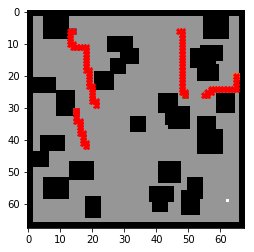

[29, 21]->[28, 21]->[28, 20]->[27, 20]->[26, 20]->[25, 20]->[24, 20]->[23, 20]->[23, 19]->[22, 19]->[21, 19]->[20, 19]->[19, 19]->[18, 19]->[18, 18]->[17, 18]->[16, 18]->[15, 18]->[14, 18]->[13, 18]->[12, 18]->[11, 18]->[11, 17]->[11, 16]->[11, 15]->[11, 14]->[10, 14]->[10, 13]->[9, 13]->[8, 13]->[7, 13]->[6, 13]->[6, 14]->End
[26, 55]->[26, 56]->[25, 56]->[25, 57]->[24, 57]->[24, 58]->[24, 59]->[24, 60]->[24, 61]->[24, 62]->[24, 63]->[24, 64]->[24, 65]->[23, 65]->[22, 65]->[21, 65]->[20, 65]->End
[6, 47]->[6, 48]->[7, 48]->[8, 48]->[9, 48]->[10, 48]->[11, 48]->[12, 48]->[13, 48]->[14, 48]->[15, 48]->[16, 48]->[17, 48]->[18, 48]->[19, 48]->[20, 48]->[21, 48]->[22, 48]->[23, 48]->[24, 48]->[25, 48]->[25, 49]->[26, 49]->End
[42, 18]->[41, 18]->[41, 17]->[40, 17]->[39, 17]->[38, 17]->[38, 16]->[37, 16]->[36, 16]->[35, 16]->[34, 16]->[34, 15]->[33, 15]->[32, 15]->[31, 15]->End


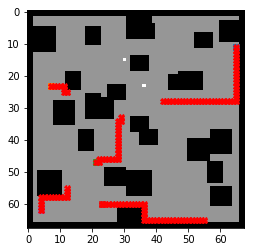

[28, 42]->[28, 43]->[28, 44]->[28, 45]->[28, 46]->[28, 47]->[28, 48]->[28, 49]->[28, 50]->[28, 51]->[28, 52]->[28, 53]->[28, 54]->[28, 55]->[28, 56]->[28, 57]->[28, 58]->[28, 59]->[28, 60]->[28, 61]->[28, 62]->[28, 63]->[28, 64]->[28, 65]->[27, 65]->[26, 65]->[25, 65]->[24, 65]->[23, 65]->[22, 65]->[21, 65]->[20, 65]->[19, 65]->[18, 65]->[17, 65]->[16, 65]->[15, 65]->[14, 65]->[13, 65]->[12, 65]->[11, 65]->End
[25, 12]->[25, 11]->[24, 11]->[23, 11]->[23, 10]->[23, 9]->[23, 8]->[23, 7]->End
[33, 29]->[34, 29]->[34, 28]->[35, 28]->[36, 28]->[37, 28]->[38, 28]->[39, 28]->[40, 28]->[41, 28]->[42, 28]->[43, 28]->[44, 28]->[45, 28]->[46, 28]->[46, 27]->[46, 26]->[46, 25]->[46, 24]->[46, 23]->[46, 22]->[47, 22]->[47, 21]->End
[65, 55]->[65, 54]->[65, 53]->[65, 52]->[65, 51]->[65, 50]->[65, 49]->[65, 48]->[65, 47]->[65, 46]->[65, 45]->[65, 44]->[65, 43]->[65, 42]->[65, 41]->[65, 40]->[65, 39]->[65, 38]->[65, 37]->[65, 36]->[64, 36]->[63, 36]->[62, 36]->[61, 36]->[60, 36]->[60, 35]->[60, 34]->[

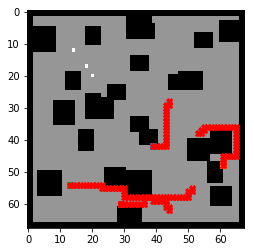

[28, 44]->[29, 44]->[29, 43]->[30, 43]->[31, 43]->[32, 43]->[33, 43]->[34, 43]->[35, 43]->[36, 43]->[37, 43]->[38, 43]->[39, 43]->[40, 43]->[41, 43]->[42, 43]->[42, 42]->[42, 41]->[42, 40]->[42, 39]->End
[38, 53]->[38, 54]->[37, 54]->[37, 55]->[36, 55]->[36, 56]->[36, 57]->[36, 58]->[36, 59]->[36, 60]->[36, 61]->[36, 62]->[36, 63]->[36, 64]->[36, 65]->[37, 65]->[38, 65]->[39, 65]->[40, 65]->[41, 65]->[42, 65]->[43, 65]->[44, 65]->[45, 65]->[45, 64]->[45, 63]->[45, 62]->[45, 61]->[46, 61]->[47, 61]->[48, 61]->End
[62, 44]->[61, 44]->[61, 43]->[60, 43]->[59, 43]->[59, 42]->[59, 41]->[59, 40]->[59, 39]->[58, 39]->[58, 38]->[58, 37]->[58, 36]->[58, 35]->[58, 34]->[58, 33]->[58, 32]->[58, 31]->[58, 30]->[57, 30]->[56, 30]->[55, 30]->[55, 29]->[55, 28]->[55, 27]->[55, 26]->[55, 25]->[55, 24]->[55, 23]->[54, 23]->[54, 22]->[54, 21]->[54, 20]->[54, 19]->[54, 18]->[54, 17]->[54, 16]->[54, 15]->[54, 14]->[54, 13]->End
[55, 51]->[56, 51]->[56, 50]->[57, 50]->[58, 50]->[58, 49]->[58, 48]->[58, 47]

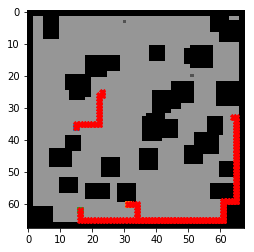

[36, 15]->[35, 15]->[35, 16]->[35, 17]->[35, 18]->[35, 19]->[35, 20]->[35, 21]->[35, 22]->[34, 22]->[33, 22]->[32, 22]->[31, 22]->[30, 22]->[29, 22]->[28, 22]->[27, 22]->[26, 22]->[26, 23]->[25, 23]->End
[60, 31]->[60, 32]->[60, 33]->[60, 34]->[61, 34]->[62, 34]->[63, 34]->[64, 34]->[65, 34]->[65, 35]->[65, 36]->[65, 37]->[65, 38]->[65, 39]->[65, 40]->[65, 41]->[65, 42]->[65, 43]->[65, 44]->[65, 45]->[65, 46]->[65, 47]->[65, 48]->[65, 49]->[65, 50]->[65, 51]->[65, 52]->[65, 53]->[65, 54]->[65, 55]->[65, 56]->[65, 57]->[65, 58]->[65, 59]->[65, 60]->[65, 61]->[64, 61]->[63, 61]->[62, 61]->[61, 61]->[60, 61]->[59, 61]->[59, 62]->[59, 63]->[59, 64]->[59, 65]->[58, 65]->[57, 65]->[56, 65]->[55, 65]->[54, 65]->[53, 65]->[52, 65]->[51, 65]->[50, 65]->[49, 65]->[48, 65]->[47, 65]->[46, 65]->[45, 65]->[44, 65]->[43, 65]->[42, 65]->[41, 65]->[40, 65]->[39, 65]->[38, 65]->[37, 65]->[36, 65]->[35, 65]->[34, 65]->[33, 65]->[33, 64]->End
[62, 16]->[63, 16]->[64, 16]->[65, 16]->[65, 17]->[65, 18]->[6

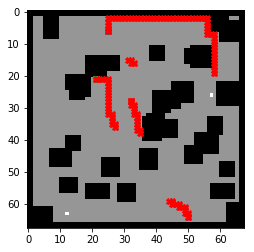

[19, 58]->[18, 58]->[17, 58]->[16, 58]->[15, 58]->[14, 58]->[13, 58]->[12, 58]->[11, 58]->[10, 58]->[9, 58]->[8, 58]->[7, 58]->[7, 57]->[7, 56]->[6, 56]->[5, 56]->[4, 56]->[3, 56]->[2, 56]->[2, 55]->[2, 54]->[2, 53]->[2, 52]->[2, 51]->[2, 50]->[2, 49]->[2, 48]->[2, 47]->[2, 46]->[2, 45]->[2, 44]->[2, 43]->[2, 42]->[2, 41]->[2, 40]->[2, 39]->[2, 38]->[2, 37]->[2, 36]->[2, 35]->[2, 34]->[2, 33]->[2, 32]->[2, 31]->[2, 30]->[2, 29]->[2, 28]->[2, 27]->[2, 26]->[2, 25]->[3, 25]->[4, 25]->[5, 25]->[6, 25]->End
[16, 33]->[16, 32]->[15, 32]->[15, 31]->End
[36, 27]->[35, 27]->[35, 26]->[34, 26]->[33, 26]->[32, 26]->[32, 25]->[31, 25]->[30, 25]->[29, 25]->[28, 25]->[27, 25]->[26, 25]->[25, 25]->[24, 25]->[23, 25]->[22, 25]->[21, 25]->[21, 24]->[21, 23]->[21, 22]->[21, 21]->End
[38, 35]->[37, 35]->[37, 34]->[36, 34]->[35, 34]->[34, 34]->[33, 34]->[32, 34]->[32, 33]->[31, 33]->[30, 33]->[29, 33]->[29, 32]->[28, 32]->End
[59, 44]->[59, 45]->[60, 45]->[60, 46]->[60, 47]->[61, 47]->[61, 48]->[61, 49]-

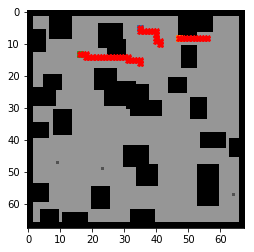

[5, 35]->[6, 35]->[6, 36]->[6, 37]->[6, 38]->[6, 39]->[6, 40]->[7, 40]->[8, 40]->[9, 40]->[9, 41]->[10, 41]->End
[8, 47]->[8, 48]->[8, 49]->[8, 50]->[8, 51]->[8, 52]->[8, 53]->[8, 54]->[8, 55]->[8, 56]->End
[13, 16]->[13, 17]->[13, 18]->[14, 18]->[14, 19]->[14, 20]->[14, 21]->[14, 22]->[14, 23]->[14, 24]->[14, 25]->[14, 26]->[14, 27]->[14, 28]->[14, 29]->[14, 30]->[14, 31]->[15, 31]->[15, 32]->[15, 33]->[15, 34]->[15, 35]->[16, 35]->End


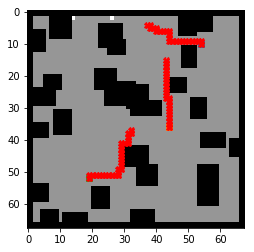

[4, 37]->[4, 38]->[5, 38]->[5, 39]->[5, 40]->[6, 40]->[6, 41]->[6, 42]->[6, 43]->[6, 44]->[7, 44]->[8, 44]->[9, 44]->[9, 45]->[9, 46]->[9, 47]->[9, 48]->[9, 49]->[9, 50]->[9, 51]->[9, 52]->[9, 53]->[9, 54]->[10, 54]->End
[15, 43]->[16, 43]->[17, 43]->[18, 43]->[19, 43]->[20, 43]->[21, 43]->[22, 43]->[23, 43]->[24, 43]->[25, 43]->[26, 43]->[27, 43]->[27, 44]->[28, 44]->[29, 44]->[30, 44]->[31, 44]->[32, 44]->[33, 44]->[34, 44]->[35, 44]->[36, 44]->End
[37, 32]->[38, 32]->[38, 31]->[39, 31]->[40, 31]->[41, 31]->[41, 30]->[41, 29]->[42, 29]->[43, 29]->[44, 29]->[45, 29]->[46, 29]->[47, 29]->[48, 29]->[49, 29]->[49, 28]->[50, 28]->[51, 28]->[51, 27]->[51, 26]->[51, 25]->[51, 24]->[51, 23]->[51, 22]->[51, 21]->[51, 20]->[51, 19]->[52, 19]->End


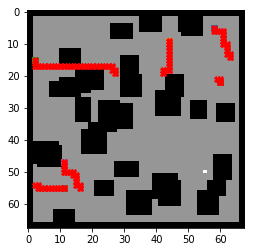

[14, 63]->[13, 63]->[13, 62]->[12, 62]->[11, 62]->[10, 62]->[10, 61]->[9, 61]->[8, 61]->[7, 61]->[6, 61]->[6, 60]->[6, 59]->[6, 58]->[5, 58]->End
[19, 42]->[18, 42]->[18, 43]->[18, 44]->[17, 44]->[16, 44]->[15, 44]->[14, 44]->[13, 44]->[12, 44]->[11, 44]->[10, 44]->[9, 44]->End
[19, 27]->[18, 27]->[18, 26]->[17, 26]->[17, 25]->[17, 24]->[17, 23]->[17, 22]->[17, 21]->[17, 20]->[17, 19]->[17, 18]->[17, 17]->[17, 16]->[17, 15]->[17, 14]->[17, 13]->[17, 12]->[17, 11]->[17, 10]->[17, 9]->[17, 8]->[17, 7]->[17, 6]->[17, 5]->[17, 4]->[17, 3]->[17, 2]->[16, 2]->[15, 2]->End
[21, 59]->[21, 60]->[22, 60]->End
[55, 16]->[54, 16]->[54, 15]->[53, 15]->[52, 15]->[51, 15]->[51, 14]->[50, 14]->[50, 13]->[50, 12]->[50, 11]->[49, 11]->[48, 11]->[47, 11]->End
[54, 2]->[54, 3]->[55, 3]->[55, 4]->[55, 5]->[55, 6]->[55, 7]->[55, 8]->[55, 9]->[55, 10]->[55, 11]->End


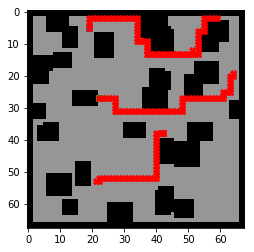

[12, 51]->[13, 51]->[13, 50]->[13, 49]->[13, 48]->[13, 47]->[13, 46]->[13, 45]->[13, 44]->[13, 43]->[13, 42]->[13, 41]->[13, 40]->[13, 39]->[13, 38]->[13, 37]->[12, 37]->[11, 37]->[10, 37]->[9, 37]->[9, 36]->[9, 35]->[9, 34]->[8, 34]->[7, 34]->[6, 34]->[5, 34]->[4, 34]->[3, 34]->[2, 34]->[2, 33]->[2, 32]->[2, 31]->[2, 30]->[2, 29]->[2, 28]->[2, 27]->[2, 26]->[2, 25]->[2, 24]->[2, 23]->[2, 22]->[2, 21]->[2, 20]->[2, 19]->[3, 19]->[4, 19]->[5, 19]->End
[2, 59]->[2, 58]->[2, 57]->[2, 56]->[2, 55]->[3, 55]->[4, 55]->[5, 55]->[6, 55]->[6, 54]->[6, 53]->[7, 53]->[8, 53]->[9, 53]->[10, 53]->[11, 53]->[12, 53]->[13, 53]->[13, 52]->[13, 51]->[13, 50]->[13, 49]->[13, 48]->[13, 47]->[13, 46]->[13, 45]->[13, 44]->[13, 43]->[13, 42]->[13, 41]->[13, 40]->[13, 39]->[13, 38]->[13, 37]->[12, 37]->[11, 37]->[10, 37]->[9, 37]->[9, 36]->[9, 35]->End
[19, 64]->[20, 64]->[20, 63]->[21, 63]->[22, 63]->[23, 63]->[24, 63]->[25, 63]->[25, 62]->[25, 61]->[26, 61]->[27, 61]->[27, 60]->[27, 59]->[27, 58]->[27, 57]

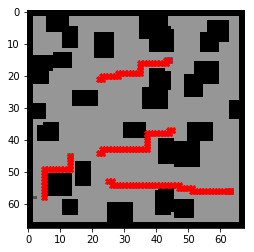

[15, 44]->[15, 43]->[16, 43]->[16, 42]->[16, 41]->[16, 40]->[16, 39]->[16, 38]->[16, 37]->[16, 36]->[16, 35]->[17, 35]->[18, 35]->[19, 35]->[19, 34]->[19, 33]->[19, 32]->[19, 31]->[19, 30]->[19, 29]->[19, 28]->[20, 28]->[20, 27]->[20, 26]->[20, 25]->[20, 24]->[20, 23]->[21, 23]->[21, 22]->End
[37, 45]->[37, 44]->[38, 44]->[38, 43]->[38, 42]->[38, 41]->[38, 40]->[38, 39]->[38, 38]->[38, 37]->[39, 37]->[40, 37]->[41, 37]->[42, 37]->[43, 37]->[43, 36]->[43, 35]->[43, 34]->[43, 33]->[43, 32]->[43, 31]->[43, 30]->[43, 29]->[43, 28]->[43, 27]->[43, 26]->[43, 25]->[43, 24]->[43, 23]->[44, 23]->[44, 22]->End
[45, 13]->[46, 13]->[47, 13]->[48, 13]->[49, 13]->[49, 12]->[49, 11]->[49, 10]->[49, 9]->[49, 8]->[49, 7]->[49, 6]->[49, 5]->[50, 5]->[51, 5]->[52, 5]->[53, 5]->[54, 5]->[55, 5]->[56, 5]->[57, 5]->[58, 5]->End
[56, 63]->[56, 62]->[56, 61]->[56, 60]->[56, 59]->[56, 58]->[56, 57]->[56, 56]->[56, 55]->[56, 54]->[56, 53]->[56, 52]->[56, 51]->[55, 51]->[55, 50]->[55, 49]->[55, 48]->[55, 47]->[5

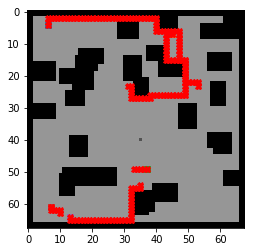

[4, 6]->[3, 6]->[2, 6]->[2, 7]->[2, 8]->[2, 9]->[2, 10]->[2, 11]->[2, 12]->[2, 13]->[2, 14]->[2, 15]->[2, 16]->[2, 17]->[2, 18]->[2, 19]->[2, 20]->[2, 21]->[2, 22]->[2, 23]->[2, 24]->[2, 25]->[2, 26]->[2, 27]->[2, 28]->[2, 29]->[2, 30]->[2, 31]->[2, 32]->[2, 33]->[2, 34]->[2, 35]->[2, 36]->[2, 37]->[2, 38]->[2, 39]->[2, 40]->[3, 40]->[4, 40]->[5, 40]->[6, 40]->[6, 41]->[6, 42]->[6, 43]->[6, 44]->[6, 45]->[6, 46]->[6, 47]->[7, 47]->[8, 47]->[9, 47]->[10, 47]->[11, 47]->[12, 47]->[13, 47]->[14, 47]->[15, 47]->[15, 48]->[15, 49]->[16, 49]->[17, 49]->[18, 49]->[19, 49]->[20, 49]->[21, 49]->[22, 49]->[22, 50]->[22, 51]->[22, 52]->[22, 53]->[23, 53]->End
[7, 45]->[7, 44]->[7, 43]->[8, 43]->[9, 43]->[10, 43]->[11, 43]->[12, 43]->[13, 43]->[14, 43]->[15, 43]->[15, 44]->[15, 45]->[15, 46]->[15, 47]->[15, 48]->[15, 49]->[16, 49]->[17, 49]->[18, 49]->[19, 49]->[20, 49]->[21, 49]->[22, 49]->[23, 49]->[24, 49]->[25, 49]->[26, 49]->[26, 48]->[26, 47]->[26, 46]->[26, 45]->[26, 44]->[26, 43]->[26, 42]

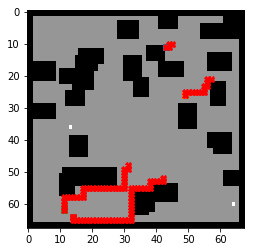

[10, 45]->[10, 44]->[11, 44]->[11, 43]->End
[21, 57]->[21, 56]->[22, 56]->[23, 56]->[23, 55]->[24, 55]->[25, 55]->[25, 54]->[25, 53]->[25, 52]->[25, 51]->[25, 50]->[25, 49]->[26, 49]->End
[48, 31]->[49, 31]->[49, 30]->[50, 30]->[51, 30]->[52, 30]->[53, 30]->[54, 30]->[55, 30]->[55, 29]->[55, 28]->[55, 27]->[55, 26]->[55, 25]->[55, 24]->[55, 23]->[55, 22]->[55, 21]->[55, 20]->[55, 19]->[55, 18]->[55, 17]->[56, 17]->[57, 17]->[58, 17]->[58, 16]->[58, 15]->[58, 14]->[58, 13]->[58, 12]->[58, 11]->[59, 11]->[60, 11]->[61, 11]->[62, 11]->End
[52, 42]->[53, 42]->[53, 41]->[53, 40]->[53, 39]->[53, 38]->[54, 38]->[55, 38]->[55, 37]->[55, 36]->[55, 35]->[55, 34]->[55, 33]->[55, 32]->[56, 32]->[57, 32]->[58, 32]->[59, 32]->[60, 32]->[61, 32]->[62, 32]->[63, 32]->[64, 32]->[65, 32]->[65, 31]->[65, 30]->[65, 29]->[65, 28]->[65, 27]->[65, 26]->[65, 25]->[65, 24]->[65, 23]->[65, 22]->[65, 21]->[65, 20]->[65, 19]->[65, 18]->[65, 17]->[65, 16]->[65, 15]->[65, 14]->[64, 14]->End


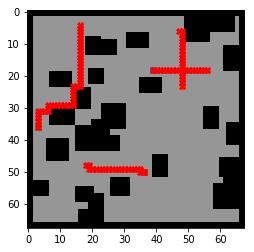

[18, 56]->[18, 55]->[18, 54]->[18, 53]->[18, 52]->[18, 51]->[18, 50]->[18, 49]->[18, 48]->[18, 47]->[18, 46]->[18, 45]->[18, 44]->[18, 43]->[18, 42]->[18, 41]->[18, 40]->[18, 39]->End
[6, 47]->[6, 48]->[7, 48]->[8, 48]->[9, 48]->[10, 48]->[11, 48]->[12, 48]->[13, 48]->[14, 48]->[15, 48]->[16, 48]->[17, 48]->[18, 48]->[19, 48]->[20, 48]->[21, 48]->[22, 48]->[23, 48]->End
[4, 16]->[5, 16]->[6, 16]->[7, 16]->[8, 16]->[9, 16]->[10, 16]->[11, 16]->[12, 16]->[13, 16]->[14, 16]->[15, 16]->[16, 16]->[17, 16]->[18, 16]->[19, 16]->[20, 16]->[21, 16]->[22, 16]->[23, 16]->[23, 15]->[23, 14]->[24, 14]->[25, 14]->[26, 14]->[27, 14]->[28, 14]->[29, 14]->[29, 13]->[29, 12]->[29, 11]->[29, 10]->[29, 9]->[29, 8]->[29, 7]->[29, 6]->[30, 6]->[31, 6]->[31, 5]->[31, 4]->[31, 3]->[32, 3]->[33, 3]->[34, 3]->[35, 3]->[36, 3]->End
[48, 18]->[48, 19]->[49, 19]->[49, 20]->[49, 21]->[49, 22]->[49, 23]->[49, 24]->[49, 25]->[49, 26]->[49, 27]->[49, 28]->[49, 29]->[49, 30]->[49, 31]->[49, 32]->[49, 33]->[49, 34]->[49

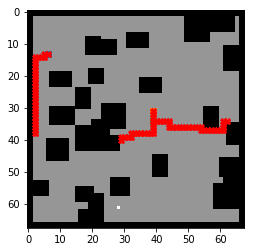

[38, 2]->[37, 2]->[36, 2]->[35, 2]->[34, 2]->[33, 2]->[32, 2]->[31, 2]->[30, 2]->[29, 2]->[28, 2]->[27, 2]->[26, 2]->[25, 2]->[24, 2]->[23, 2]->[22, 2]->[21, 2]->[20, 2]->[19, 2]->[18, 2]->[17, 2]->[16, 2]->[15, 2]->[14, 2]->[14, 3]->[14, 4]->[14, 5]->[13, 5]->[13, 6]->End
[40, 29]->[39, 29]->[39, 30]->[39, 31]->[39, 32]->[38, 32]->[38, 33]->[38, 34]->[38, 35]->[38, 36]->[38, 37]->[38, 38]->[38, 39]->[37, 39]->[36, 39]->[35, 39]->[34, 39]->[33, 39]->[32, 39]->[31, 39]->End
[34, 62]->[34, 61]->[35, 61]->[36, 61]->[37, 61]->[37, 60]->[37, 59]->[37, 58]->[37, 57]->[37, 56]->[37, 55]->[37, 54]->[36, 54]->[36, 53]->[36, 52]->[36, 51]->[36, 50]->[36, 49]->[36, 48]->[36, 47]->[36, 46]->[36, 45]->[36, 44]->[35, 44]->[34, 44]->[34, 43]->[34, 42]->[34, 41]->[34, 40]->[34, 39]->End


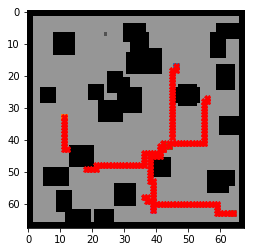

[17, 46]->[18, 46]->[18, 45]->[19, 45]->[20, 45]->[21, 45]->[22, 45]->[23, 45]->[24, 45]->[25, 45]->[26, 45]->[27, 45]->[28, 45]->[29, 45]->[30, 45]->[31, 45]->[32, 45]->[33, 45]->[34, 45]->[35, 45]->[36, 45]->[37, 45]->[38, 45]->[39, 45]->End
[33, 11]->[34, 11]->[35, 11]->[36, 11]->[37, 11]->[38, 11]->[39, 11]->[40, 11]->[41, 11]->[42, 11]->[43, 11]->[43, 12]->End
[42, 44]->[41, 44]->[41, 45]->[41, 46]->[41, 47]->[41, 48]->[41, 49]->[41, 50]->[41, 51]->[41, 52]->[41, 53]->[41, 54]->[41, 55]->[40, 55]->[39, 55]->[38, 55]->[37, 55]->[36, 55]->[35, 55]->[34, 55]->[33, 55]->[32, 55]->[31, 55]->[30, 55]->[29, 55]->[28, 55]->[28, 56]->[27, 56]->End
[43, 42]->[43, 41]->[44, 41]->[44, 40]->[44, 39]->[44, 38]->[44, 37]->[44, 36]->[45, 36]->[46, 36]->[47, 36]->[48, 36]->[48, 35]->[48, 34]->[48, 33]->[48, 32]->[48, 31]->[48, 30]->[48, 29]->[48, 28]->[48, 27]->[48, 26]->[48, 25]->[48, 24]->[48, 23]->[48, 22]->[48, 21]->[49, 21]->[49, 20]->[49, 19]->[49, 18]->End
[62, 39]->[61, 39]->[60, 39]->[59,

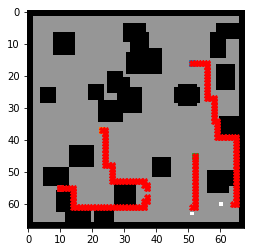

[60, 64]->[60, 65]->[59, 65]->[58, 65]->[57, 65]->[56, 65]->[55, 65]->[54, 65]->[53, 65]->[52, 65]->[51, 65]->[50, 65]->[49, 65]->[48, 65]->[47, 65]->[46, 65]->[45, 65]->[44, 65]->[43, 65]->[42, 65]->[41, 65]->[40, 65]->[39, 65]->[39, 64]->[39, 63]->[39, 62]->[39, 61]->[39, 60]->[39, 59]->[38, 59]->[37, 59]->[36, 59]->[35, 59]->[34, 59]->[34, 58]->[33, 58]->[32, 58]->[31, 58]->[30, 58]->[29, 58]->[28, 58]->[27, 58]->[27, 57]->[27, 56]->[26, 56]->[25, 56]->[24, 56]->[23, 56]->[22, 56]->[21, 56]->[20, 56]->[19, 56]->[18, 56]->[17, 56]->[16, 56]->[16, 55]->[16, 54]->[16, 53]->[16, 52]->[16, 51]->End
[55, 37]->[54, 37]->[54, 36]->[53, 36]->[53, 35]->[53, 34]->[53, 33]->[53, 32]->[53, 31]->[53, 30]->[53, 29]->[53, 28]->[53, 27]->[53, 26]->[52, 26]->[51, 26]->[50, 26]->[49, 26]->[48, 26]->[48, 25]->[48, 24]->[47, 24]->[46, 24]->[45, 24]->[44, 24]->[43, 24]->[42, 24]->[41, 24]->[40, 24]->[39, 24]->[38, 24]->[37, 24]->[37, 23]->End
[61, 51]->[61, 52]->[60, 52]->[59, 52]->[58, 52]->[57, 52]->[5

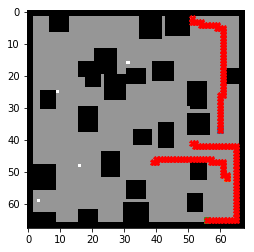

[2, 51]->[3, 51]->[3, 52]->[3, 53]->[3, 54]->[4, 54]->[4, 55]->[4, 56]->[4, 57]->[4, 58]->[4, 59]->[5, 59]->[5, 60]->[5, 61]->[6, 61]->[7, 61]->[8, 61]->[9, 61]->[10, 61]->[11, 61]->[12, 61]->[13, 61]->[14, 61]->[15, 61]->[16, 61]->[17, 61]->[18, 61]->[19, 61]->[20, 61]->[21, 61]->[22, 61]->[23, 61]->[24, 61]->[25, 61]->[26, 61]->[26, 60]->[27, 60]->[28, 60]->[29, 60]->[30, 60]->[31, 60]->[32, 60]->[33, 60]->[34, 60]->[35, 60]->[36, 60]->[37, 60]->End
[47, 39]->[47, 40]->[46, 40]->[46, 41]->[46, 42]->[46, 43]->[46, 44]->[46, 45]->[46, 46]->[46, 47]->[46, 48]->[46, 49]->[46, 50]->[46, 51]->[46, 52]->[46, 53]->[46, 54]->[46, 55]->[46, 56]->[46, 57]->[47, 57]->[47, 58]->[47, 59]->[47, 60]->[47, 61]->[48, 61]->[49, 61]->[50, 61]->[51, 61]->[51, 62]->[52, 62]->End
[41, 51]->[41, 52]->[42, 52]->[42, 53]->[42, 54]->[42, 55]->[42, 56]->[42, 57]->[42, 58]->[42, 59]->[42, 60]->[42, 61]->[42, 62]->[42, 63]->[42, 64]->[42, 65]->[43, 65]->[44, 65]->[45, 65]->[46, 65]->[47, 65]->[48, 65]->[49, 65]->

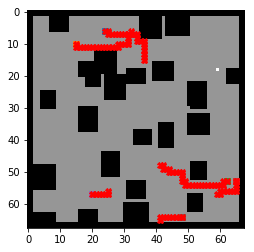

[15, 36]->[14, 36]->[13, 36]->[12, 36]->[11, 36]->[10, 36]->[9, 36]->[9, 35]->[9, 34]->[8, 34]->[7, 34]->[7, 33]->[7, 32]->[7, 31]->[7, 30]->[7, 29]->[7, 28]->[7, 27]->[7, 26]->[7, 25]->[6, 25]->[6, 24]->End
[6, 32]->[7, 32]->[7, 31]->[8, 31]->[9, 31]->[10, 31]->[10, 30]->[10, 29]->[10, 28]->[11, 28]->[11, 27]->[11, 26]->[11, 25]->[11, 24]->[11, 23]->[11, 22]->[11, 21]->[11, 20]->[11, 19]->[11, 18]->[11, 17]->[11, 16]->[11, 15]->[10, 15]->End
[48, 41]->[48, 42]->[49, 42]->[49, 43]->[49, 44]->[50, 44]->[50, 45]->[50, 46]->[50, 47]->[50, 48]->[51, 48]->[52, 48]->[53, 48]->[53, 49]->[54, 49]->[54, 50]->[54, 51]->[54, 52]->[54, 53]->[54, 54]->[54, 55]->[54, 56]->[54, 57]->[54, 58]->[54, 59]->[54, 60]->[54, 61]->[53, 61]->[53, 62]->End
[57, 59]->[57, 60]->[56, 60]->[56, 61]->[56, 62]->[56, 63]->[56, 64]->[56, 65]->[55, 65]->[54, 65]->[53, 65]->End
[56, 25]->[57, 25]->[57, 24]->[57, 23]->[57, 22]->[57, 21]->[57, 20]->End
[65, 41]->[64, 41]->[64, 42]->[64, 43]->[64, 44]->[64, 45]->[64, 46]->[

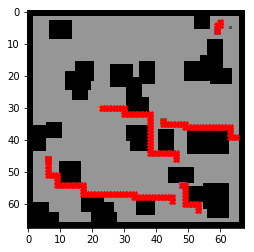

[6, 59]->[5, 59]->[4, 59]->[4, 60]->[3, 60]->End
[30, 23]->[30, 24]->[30, 25]->[30, 26]->[30, 27]->[30, 28]->[30, 29]->[30, 30]->[31, 30]->[32, 30]->[32, 31]->[32, 32]->[32, 33]->[32, 34]->[32, 35]->[32, 36]->[32, 37]->[32, 38]->[33, 38]->[34, 38]->[35, 38]->[36, 38]->[37, 38]->[38, 38]->[39, 38]->[40, 38]->[41, 38]->[42, 38]->[43, 38]->[44, 38]->[44, 39]->[44, 40]->[44, 41]->[44, 42]->[44, 43]->[44, 44]->[44, 45]->[44, 46]->[45, 46]->[46, 46]->End
[34, 42]->[35, 42]->[35, 43]->[35, 44]->[35, 45]->[35, 46]->[35, 47]->[35, 48]->[35, 49]->[36, 49]->[36, 50]->[36, 51]->[36, 52]->[36, 53]->[36, 54]->[36, 55]->[36, 56]->[36, 57]->[36, 58]->[36, 59]->[36, 60]->[36, 61]->[36, 62]->[36, 63]->[37, 63]->[38, 63]->[39, 63]->[39, 64]->[39, 65]->End
[46, 6]->[47, 6]->[48, 6]->[49, 6]->[50, 6]->[51, 6]->[51, 7]->[51, 8]->[51, 9]->[52, 9]->[53, 9]->[54, 9]->[54, 10]->[54, 11]->[54, 12]->[54, 13]->[54, 14]->[54, 15]->[54, 16]->[54, 17]->[55, 17]->[56, 17]->[57, 17]->[57, 18]->[57, 19]->[57, 20]->[57, 

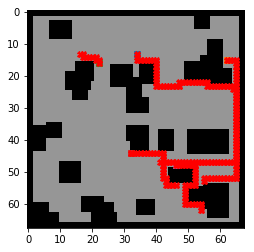

[53, 55]->[52, 55]->[52, 56]->[52, 57]->[52, 58]->[52, 59]->[52, 60]->[52, 61]->[52, 62]->[52, 63]->[52, 64]->[52, 65]->[51, 65]->[50, 65]->[49, 65]->[48, 65]->[47, 65]->[46, 65]->[45, 65]->[44, 65]->[43, 65]->[42, 65]->[41, 65]->[40, 65]->[39, 65]->[38, 65]->[37, 65]->[36, 65]->[35, 65]->[34, 65]->[33, 65]->[32, 65]->[31, 65]->[30, 65]->[29, 65]->[28, 65]->[27, 65]->[26, 65]->[25, 65]->[24, 65]->[24, 64]->[23, 64]->[23, 63]->[23, 62]->[23, 61]->[23, 60]->[23, 59]->[23, 58]->[23, 57]->[23, 56]->[22, 56]->[22, 55]->[22, 54]->[22, 53]->[22, 52]->[22, 51]->[22, 50]->[22, 49]->[22, 48]->[22, 47]->[23, 47]->[23, 46]->[23, 45]->[23, 44]->[23, 43]->[23, 42]->[23, 41]->[23, 40]->[22, 40]->[21, 40]->[20, 40]->[19, 40]->[18, 40]->[17, 40]->[16, 40]->[15, 40]->[15, 39]->[15, 38]->[15, 37]->[15, 36]->[15, 35]->[15, 34]->[14, 34]->[13, 34]->End
[47, 41]->[47, 42]->[47, 43]->[47, 44]->[47, 45]->[47, 46]->[47, 47]->[47, 48]->[47, 49]->[47, 50]->[47, 51]->[47, 52]->[47, 53]->[47, 54]->[47, 55]->[47, 5

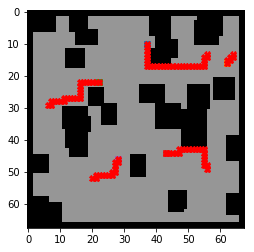

[13, 56]->[14, 56]->[14, 55]->[15, 55]->[16, 55]->[17, 55]->[17, 54]->[17, 53]->[17, 52]->[17, 51]->[17, 50]->[17, 49]->[17, 48]->[17, 47]->[17, 46]->[17, 45]->[17, 44]->[17, 43]->[17, 42]->[17, 41]->[17, 40]->[17, 39]->[17, 38]->[17, 37]->[16, 37]->[15, 37]->[14, 37]->[13, 37]->[12, 37]->[11, 37]->[10, 37]->End
[13, 64]->[14, 64]->[14, 63]->[15, 63]->[15, 62]->[16, 62]->End
[29, 6]->[29, 7]->[28, 7]->[28, 8]->[28, 9]->[28, 10]->[28, 11]->[27, 11]->[27, 12]->[27, 13]->[27, 14]->[27, 15]->[27, 16]->[26, 16]->[25, 16]->[24, 16]->[23, 16]->[22, 16]->[22, 17]->[22, 18]->[22, 19]->[22, 20]->[22, 21]->[22, 22]->End
[49, 56]->[48, 56]->[48, 55]->[47, 55]->[46, 55]->[45, 55]->[44, 55]->[43, 55]->[43, 54]->[43, 53]->[43, 52]->[43, 51]->[43, 50]->[43, 49]->[43, 48]->[43, 47]->[44, 47]->[44, 46]->[44, 45]->[44, 44]->[44, 43]->End
[52, 20]->[52, 21]->[51, 21]->[51, 22]->[51, 23]->[51, 24]->[51, 25]->[51, 26]->[50, 26]->[50, 27]->[49, 27]->[48, 27]->[47, 27]->[47, 28]->[46, 28]->End


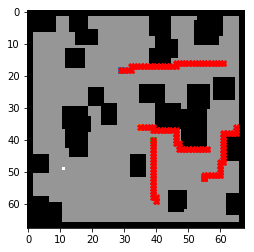

[16, 61]->[16, 60]->[16, 59]->[16, 58]->[16, 57]->[16, 56]->[16, 55]->[16, 54]->[16, 53]->[16, 52]->[16, 51]->[16, 50]->[16, 49]->[16, 48]->[16, 47]->[16, 46]->[17, 46]->[17, 45]->[17, 44]->[17, 43]->[17, 42]->[17, 41]->[17, 40]->[17, 39]->[17, 38]->[17, 37]->[17, 36]->[17, 35]->[17, 34]->[17, 33]->[17, 32]->[18, 32]->[18, 31]->[18, 30]->[18, 29]->End
[43, 56]->[43, 55]->[43, 54]->[43, 53]->[43, 52]->[43, 51]->[43, 50]->[43, 49]->[43, 48]->[43, 47]->[42, 47]->[41, 47]->[41, 46]->[40, 46]->[39, 46]->[38, 46]->[37, 46]->[37, 45]->[37, 44]->[37, 43]->[37, 42]->[37, 41]->[37, 40]->[37, 39]->[36, 39]->[36, 38]->[36, 37]->[36, 36]->[36, 35]->End
[59, 40]->[58, 40]->[58, 39]->[57, 39]->[56, 39]->[55, 39]->[54, 39]->[53, 39]->[52, 39]->[51, 39]->[50, 39]->[49, 39]->[48, 39]->[47, 39]->[46, 39]->[45, 39]->[44, 39]->[43, 39]->[42, 39]->[41, 39]->[40, 39]->End
[36, 65]->[37, 65]->[38, 65]->[38, 64]->[38, 63]->[38, 62]->[38, 61]->[39, 61]->[40, 61]->[41, 61]->[42, 61]->[43, 61]->[44, 61]->[45, 61]

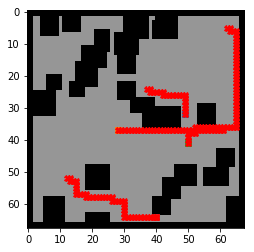

[24, 37]->[24, 38]->[25, 38]->[25, 39]->[25, 40]->[25, 41]->[25, 42]->[26, 42]->[26, 43]->[26, 44]->[26, 45]->[26, 46]->[26, 47]->[26, 48]->[26, 49]->[27, 49]->[28, 49]->[29, 49]->[30, 49]->[31, 49]->[32, 49]->End
[37, 61]->[37, 60]->[37, 59]->[37, 58]->[37, 57]->[37, 56]->[37, 55]->[37, 54]->[37, 53]->[37, 52]->[37, 51]->[37, 50]->[37, 49]->[37, 48]->[37, 47]->[37, 46]->[37, 45]->[37, 44]->[37, 43]->[37, 42]->[37, 41]->[37, 40]->[37, 39]->[37, 38]->[37, 37]->[37, 36]->[37, 35]->[37, 34]->[37, 33]->[37, 32]->[37, 31]->[37, 30]->[37, 29]->[37, 28]->End
[5, 62]->[5, 63]->[6, 63]->[6, 64]->[6, 65]->[7, 65]->[8, 65]->[9, 65]->[10, 65]->[11, 65]->[12, 65]->[13, 65]->[14, 65]->[15, 65]->[16, 65]->[17, 65]->[18, 65]->[19, 65]->[20, 65]->[21, 65]->[22, 65]->[23, 65]->[24, 65]->[25, 65]->[26, 65]->[27, 65]->[28, 65]->[29, 65]->[30, 65]->[31, 65]->[32, 65]->[33, 65]->[34, 65]->[35, 65]->[36, 65]->[36, 64]->[36, 63]->[36, 62]->[36, 61]->[36, 60]->[36, 59]->[36, 58]->[36, 57]->[36, 56]->[36, 55]->

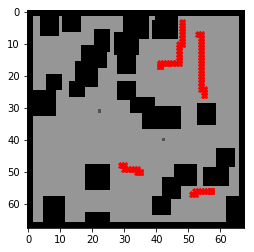

[17, 41]->[16, 41]->[16, 42]->[16, 43]->[16, 44]->[16, 45]->[16, 46]->[16, 47]->[15, 47]->[14, 47]->[13, 47]->[12, 47]->[11, 47]->[10, 47]->[10, 48]->[9, 48]->[8, 48]->[7, 48]->[6, 48]->[5, 48]->[4, 48]->[3, 48]->End
[26, 55]->[25, 55]->[24, 55]->[24, 54]->[23, 54]->[22, 54]->[21, 54]->[20, 54]->[19, 54]->[18, 54]->[17, 54]->[16, 54]->[15, 54]->[14, 54]->[13, 54]->[12, 54]->[11, 54]->[10, 54]->[9, 54]->[8, 54]->[7, 54]->[7, 53]->End
[50, 35]->[50, 34]->[49, 34]->[49, 33]->[49, 32]->[49, 31]->[49, 30]->[48, 30]->[48, 29]->End
[56, 57]->[56, 56]->[56, 55]->[56, 54]->[56, 53]->[56, 52]->[57, 52]->[57, 51]->End


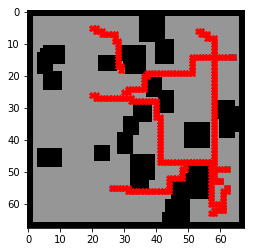

[25, 30]->[25, 31]->[24, 31]->[24, 32]->[24, 33]->[24, 34]->[24, 35]->[24, 36]->[23, 36]->[22, 36]->[21, 36]->[20, 36]->[20, 37]->[19, 37]->[19, 38]->[19, 39]->[19, 40]->[19, 41]->[19, 42]->[19, 43]->[19, 44]->[19, 45]->[19, 46]->[19, 47]->[19, 48]->[19, 49]->[19, 50]->[19, 51]->[18, 51]->[17, 51]->[16, 51]->[15, 51]->[14, 51]->[14, 52]->[14, 53]->[14, 54]->[14, 55]->[14, 56]->[14, 57]->[14, 58]->[14, 59]->[14, 60]->[14, 61]->[14, 62]->[14, 63]->[14, 64]->End
[5, 20]->[5, 21]->[6, 21]->[6, 22]->[6, 23]->[7, 23]->[7, 24]->[7, 25]->[7, 26]->[7, 27]->[8, 27]->[9, 27]->[9, 28]->[10, 28]->[11, 28]->[12, 28]->[13, 28]->[14, 28]->[15, 28]->[16, 28]->[17, 28]->[17, 29]->[18, 29]->End
[26, 20]->[26, 21]->[27, 21]->[27, 22]->[27, 23]->[27, 24]->[27, 25]->[27, 26]->[27, 27]->[27, 28]->[27, 29]->[27, 30]->[27, 31]->[27, 32]->[28, 32]->[28, 33]->[28, 34]->[28, 35]->[28, 36]->[28, 37]->[28, 38]->[28, 39]->[28, 40]->[29, 40]->[30, 40]->[31, 40]->[32, 40]->[33, 40]->[33, 41]->[34, 41]->[35, 41]->[36, 

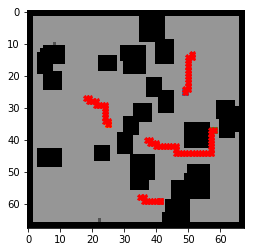

[25, 49]->[24, 49]->[24, 50]->[23, 50]->[22, 50]->[21, 50]->[20, 50]->[19, 50]->[18, 50]->[17, 50]->[16, 50]->[15, 50]->[14, 50]->[14, 51]->[13, 51]->End
[35, 25]->[34, 25]->[34, 24]->[33, 24]->[32, 24]->[31, 24]->[30, 24]->[29, 24]->[29, 23]->[29, 22]->[29, 21]->[28, 21]->[28, 20]->[28, 19]->[27, 19]->[27, 18]->End
[37, 58]->[37, 57]->[38, 57]->[39, 57]->[40, 57]->[41, 57]->[42, 57]->[43, 57]->[44, 57]->[44, 56]->[44, 55]->[44, 54]->[44, 53]->[44, 52]->[44, 51]->[44, 50]->[44, 49]->[44, 48]->[44, 47]->[44, 46]->[43, 46]->[42, 46]->[42, 45]->[42, 44]->[42, 43]->[42, 42]->[42, 41]->[42, 40]->[41, 40]->[41, 39]->[41, 38]->[40, 38]->[40, 37]->End
[59, 41]->[59, 40]->[59, 39]->[59, 38]->[59, 37]->[59, 36]->[58, 36]->[58, 35]->End


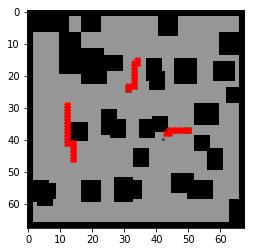

[24, 31]->[23, 31]->[23, 32]->[23, 33]->[22, 33]->[21, 33]->[20, 33]->[19, 33]->[18, 33]->[17, 33]->[16, 33]->[16, 34]->[15, 34]->End
[29, 12]->[30, 12]->[31, 12]->[32, 12]->[33, 12]->[34, 12]->[35, 12]->[36, 12]->[37, 12]->[38, 12]->[39, 12]->[40, 12]->[41, 12]->[41, 13]->[41, 14]->[42, 14]->[43, 14]->[44, 14]->[45, 14]->[46, 14]->End
[37, 50]->[37, 49]->[37, 48]->[37, 47]->[37, 46]->[37, 45]->[37, 44]->[38, 44]->[38, 43]->End


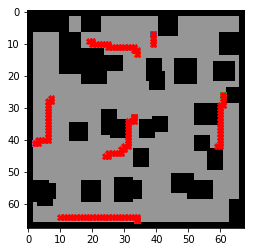

[10, 39]->[9, 39]->[8, 39]->[7, 39]->End
[9, 19]->[9, 20]->[10, 20]->[10, 21]->[10, 22]->[10, 23]->[10, 24]->[10, 25]->[11, 25]->[11, 26]->[11, 27]->[11, 28]->[11, 29]->[11, 30]->[11, 31]->[11, 32]->[11, 33]->[12, 33]->[12, 34]->[13, 34]->End
[42, 59]->[42, 60]->[41, 60]->[40, 60]->[39, 60]->[38, 60]->[37, 60]->[36, 60]->[35, 60]->[34, 60]->[33, 60]->[32, 60]->[31, 60]->[30, 60]->[29, 60]->[29, 61]->[28, 61]->[27, 61]->[26, 61]->End
[45, 24]->[45, 25]->[44, 25]->[44, 26]->[44, 27]->[44, 28]->[44, 29]->[43, 29]->[43, 30]->[42, 30]->[42, 31]->[41, 31]->[40, 31]->[39, 31]->[38, 31]->[37, 31]->[36, 31]->[35, 31]->[34, 31]->[34, 32]->[34, 33]->[33, 33]->End
[27, 7]->[28, 7]->[28, 6]->[29, 6]->[30, 6]->[31, 6]->[32, 6]->[33, 6]->[34, 6]->[35, 6]->[36, 6]->[37, 6]->[38, 6]->[39, 6]->[40, 6]->[40, 5]->[40, 4]->[40, 3]->[41, 3]->[41, 2]->End
[64, 10]->[64, 11]->[64, 12]->[64, 13]->[64, 14]->[64, 15]->[64, 16]->[64, 17]->[64, 18]->[64, 19]->[64, 20]->[64, 21]->[64, 22]->[64, 23]->[64, 24]->[64, 

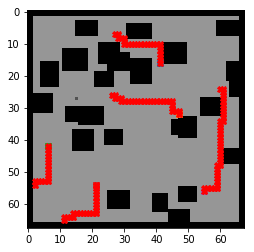

[16, 41]->[15, 41]->[14, 41]->[13, 41]->[12, 41]->[11, 41]->[10, 41]->[10, 40]->[10, 39]->[10, 38]->[10, 37]->[10, 36]->[10, 35]->[10, 34]->[10, 33]->[10, 32]->[10, 31]->[10, 30]->[9, 30]->[8, 30]->[8, 29]->[8, 28]->[7, 28]->[7, 27]->End
[32, 47]->[31, 47]->[31, 46]->[31, 45]->[30, 45]->[29, 45]->[28, 45]->[28, 44]->[28, 43]->[28, 42]->[28, 41]->[28, 40]->[28, 39]->[28, 38]->[28, 37]->[28, 36]->[28, 35]->[28, 34]->[28, 33]->[28, 32]->[28, 31]->[28, 30]->[28, 29]->[27, 29]->[27, 28]->[27, 27]->[26, 27]->[26, 26]->End
[42, 6]->[43, 6]->[44, 6]->[45, 6]->[46, 6]->[47, 6]->[48, 6]->[49, 6]->[50, 6]->[51, 6]->[52, 6]->[53, 6]->[53, 5]->[53, 4]->[53, 3]->[53, 2]->[54, 2]->End
[54, 21]->[55, 21]->[56, 21]->[57, 21]->[58, 21]->[59, 21]->[60, 21]->[61, 21]->[62, 21]->[63, 21]->[63, 20]->[63, 19]->[63, 18]->[63, 17]->[63, 16]->[63, 15]->[63, 14]->[64, 14]->[64, 13]->[64, 12]->[64, 11]->[65, 11]->End
[56, 55]->[55, 55]->[55, 56]->[55, 57]->[55, 58]->[55, 59]->[54, 59]->[53, 59]->[52, 59]->[51, 59

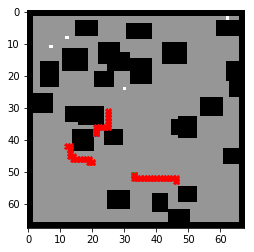

[31, 25]->[32, 25]->[33, 25]->[34, 25]->[35, 25]->[36, 25]->[36, 24]->[36, 23]->[36, 22]->[36, 21]->[37, 21]->[38, 21]->End
[42, 12]->[42, 13]->[43, 13]->[44, 13]->[45, 13]->[45, 14]->[46, 14]->[46, 15]->[46, 16]->[46, 17]->[46, 18]->[46, 19]->[47, 19]->[47, 20]->End
[53, 46]->[52, 46]->[52, 45]->[52, 44]->[52, 43]->[52, 42]->[52, 41]->[52, 40]->[52, 39]->[52, 38]->[52, 37]->[52, 36]->[52, 35]->[52, 34]->[52, 33]->[51, 33]->End
Goal Accuracy: 1.0
209.0 209.0
Average traj step length : 40.98
2049.0 50


In [128]:
correct,total,traj_step = 0.0,0.0,0.0   
imsize = 68
max_rand_play= 0
memory = []
for i in range(50):
    if i == 27 :
      continue
    
    X = test_data[i][0].clone()
    
    Y = torch.zeros([3,68,68])
    
    Y[:,2:66,2:66] = X.clone()
    
    go = np.where(Y[1] == 1.0)
    goal = np.column_stack([go[0],go[1]])
    
  
        
    #current_goal,current_total,traj,memory = agent_predict(model_28x28,Y.clone(),goal,imsize,max_rand_play)
    #correct_goal,total_goal, traj_length,traj = agent_prediction(model_64x64,Y.clone(),[],goal,imsize,0)
    correct_goal,total_goal, traj_length,traj,change = cooperative(model=model_64x64,X=Y.clone(),imsize=imsize)
    
    dom = Y[0] - 0.5 * Y[1] + Y[2]
    visualization(dom,traj)
        
    if change == 1:
        for i in traj:
            L = len(i[0])
            for j in range(L-1,-1,-1):
                print([i[0][j][0].item(),i[0][j][1].item()],end='->')
            print("End")
    else :
        for i in traj:
            for j in i[0]:
                print([j[0].item(),j[1].item()],end='->')
            print("End")
    
    correct += correct_goal
    total += total_goal
    traj_step += traj_length
    
print(f'Goal Accuracy: {correct/total}')
print(correct,total)
print(f'Average traj step length : {traj_step/50}')
print(traj_step,50)

In [0]:
test = []
with np.load('Env_80x80.npz', mmap_mode='r',allow_pickle=True) as f:
    test = f['arr_0']

In [0]:
test_data = []

for i in test:
    env = -1 *(i[0] == 0) + 1.0
    goal = (i[0] == 0.5) + 0.0
    Agent = i[1]
    domain = np.array([env,goal,Agent])
    
    test_data.append([torch.tensor(domain.copy())])

In [0]:
model_80x80 = MA_P(84,84)
model_80x80.load_state_dict(torch.load('MA_P_2_9_2.pth'))
model_80x80.cuda()

MA_P(
  (h): Conv2d(3, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (r): Conv2d(150, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (q): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (sm): Softmax()
)

In [0]:
correct,total,traj_step = 0.0,0.0,0.0   
imsize = 84
max_rand_play= 0
memory = []
for i in range(50):
    if i ==0 or i == 1 or i == 8 or i == 12 or i == 22 or i == 27 or i == 32 or i == 38:
      continue
    
    X = test_data[i][0].clone()
    
    Y = torch.zeros([3,84,84])
    
    Y[:,2:82,2:82] = X.clone()
    
    go = np.where(Y[1] == 1.0)
    goal = np.column_stack([go[0],go[1]])
    
  
        
    #current_goal,current_total,traj,memory = agent_predict(model_28x28,Y.clone(),goal,imsize,max_rand_play)
    correct_goal,total_goal, traj_length,traj = agent_prediction(model_80x80,Y.clone(),[],goal,imsize,0)
    #correct_goal,total_goal, traj_length,traj = cooperative(model=model_80x80,X=Y.clone(),imsize=imsize)
    
    #for j in traj:
     # for k in j:
      #   print(k,end="->")
     # print("End")
      
    #print(i,correct_goal,total_goal)
    
    correct += correct_goal
    total += total_goal
    traj_step += traj_length
    
print(f'Goal Accuracy: {correct/total}')
print(correct,total)
print(f'Average traj step length : {traj_step/50}')
print(traj_step,50)

Goal Accuracy: 0.48132780082987553
116.0 241.0
Average traj step length : 17.64
882.0 50


In [0]:
correct,total,traj_step = 0.0,0.0,0.0   
imsize = 84
max_rand_play= 0
memory = []
for i in range(50):
    if i ==0 or i == 1 or i == 8 or i == 12 or i == 22 or i == 27 or i == 32 or i == 38:
      continue
    
    X = test_data[i][0].clone()
    
    Y = torch.zeros([3,84,84])
    
    Y[:,2:82,2:82] = X.clone()
    
    go = np.where(Y[1] == 1.0)
    goal = np.column_stack([go[0],go[1]])
    
  
        
    #current_goal,current_total,traj,memory = agent_predict(model_28x28,Y.clone(),goal,imsize,max_rand_play)
    #correct_goal,total_goal, traj_length,traj = agent_prediction(model_80x80,Y.clone(),[],goal,imsize,0)
    correct_goal,total_goal, traj_length,traj = cooperative(model=model_80x80,X=Y.clone(),imsize=imsize)
    
    #for j in traj:
     # for k in j:
      #   print(k,end="->")
     # print("End")
      
   # print(i,correct_goal,total_goal)
    
    correct += correct_goal
    total += total_goal
    traj_step += traj_length
    
print(f'Goal Accuracy: {correct/total}')
print(correct,total)
print(f'Average traj step length : {traj_step/50}')
print(traj_step,50)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Goal Accuracy: 0.9336099585062241
225.0 241.0
Average traj step length : 40.34
2017.0 50


In [0]:
test = []
with np.load('Env_128x128.npz', mmap_mode='r') as f:
    test = f['arr_0']

In [0]:
test_data = []

for i in test:
    env = -1 *(i[0] == 0) + 1.0
    goal = (i[0] == 0.5) + 0.0
    Agent = i[1]
    domain = np.array([env,goal,Agent])
    
    test_data.append([torch.tensor(domain.copy())])

In [0]:
model_128x128 = MA_P(88,130)
model_128x128.load_state_dict(torch.load('MA_P_2_9_2.pth'))
model_128x128.cuda()

MA_P(
  (h): Conv2d(3, 150, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (r): Conv2d(150, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (q): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (sm): Softmax()
)

NameError: ignored

In [0]:
correct_goal,total_goal = 0.0,0.0   
imsize = 130
max_rand_play= 0
for i in range(50):
    print(i)
    X = test_data[i][0].clone()
    Y = torch.zeros([3,imsize,imsize])
    Y[:,1:imsize-1,1:imsize-1] = X
    
    go = np.where(Y[1] == 1.0)
    goal = np.column_stack([go[0],go[1]])
    
        
    current_goal,current_total,traj,_ = agent_predict(model_128x128,Y.clone(),goal,imsize,max_rand_play)
    
    correct_goal += current_goal
    total_goal += current_total
    
print(f'Goal Accuracy: {correct_goal/total_goal}')
print(correct_goal,total_goal)

0


RuntimeError: ignored

In [0]:
X>r

0